# Insider 2.0 clean regression and brand_state list generation

#### Import Packages

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import math

from sqlalchemy import create_engine
import boto3

from datetime import datetime, timedelta

# SKLEARN stuff
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from faire.datascience.vendor.aws.redshift import query_to_df
from faire.datascience.vendor.aws.s3 import write_output_to_s3

#### SQL helper functions

In [2]:
# def query_to_raw_df(connection_url,query,col_names = None):
#     try:
#         conn = create_engine(connection_url, convert_unicode=True, client_encoding='utf8')
#     except Error as e:
#         print(e)
#         print('Connection failed - check database path and credentials')
#         return

#     result = conn.execute(query).fetchall()
#     if col_names:
#         return pd.DataFrame(result, columns = col_names)
#     else:
#         return pd.DataFrame(result, columns = result[0].keys())

In [3]:
# def write_output_to_s3(filename,key,bucket_name,boto3_session):
#     print('Saving file to s3 to',bucket_name)

#     try:
#         s3_resource = boto3_session.resource('s3')
#     except:
#         print('Error connecting to s3 - check bucket name and credentials')
#         return

#     s3_resource.Bucket(bucket_name).upload_file(
#                         Filename=filename, Key=key)

In [4]:
# credentials = pd.read_csv('/Users/pedrosalesdebruin/Development/config/credentials.csv')

# redshift_postgres_uri = pd.read_pickle('/Users/pedrosalesdebruin/Development/config/production_credentials.pkl')[0][0]

# boto3_session = boto3.session.Session(aws_access_key_id=credentials['Access key ID'][0],
#                                     aws_secret_access_key= credentials['Secret access key'][0])

# Parameters of model:

In [5]:
# Only consider orders after
start_date = '2017-01-01'
train_test_split_date = '2019-08-01'
#end_date = '2019-09-01' ## Just use all data after split instead

target_future_scf = True
use_xgb_model = True

## Steps:
- Take data at brand order level from finance_cm (add OpEx, ignore lack of Insider subcription)
- Compute CM_per_GMV
- Group by brand_state
- Compute macro_avg_CM_per_GMV, macro_avg_Insider_freight_per_GMV
- Must-have features: zone, brand_category, commercial/residential address densities in state
- Must look at confidence interval of final prediction
- Validate again historical, estimate prediction and fully loaded errors

### Data Ingestion

Must include non-Insider orders to increase density

In [6]:
print(train_test_split_date)

2019-08-01


In [7]:
# query = f'''\

# with product_weights as (
# SELECT DISTINCT
#       po.product_id
#     , po.weight
# FROM production.product_options po
# where weight is not null
# )

# , product_cat_weights as (
#   SELECT 
#         c.name as product_category
#       , AVG(pw.weight) as avg_product_weight_in_cat
#   FROM product_weights pw
#   JOIN production.product_categories pc
#     on pc.product_id = pw.product_id
#   join production.categories c
#     on pc.category_id = c.id
  
#   group by 1
# )

# , brand_cat_items AS (
# SELECT 
#     oi.brand_id
#   , c.name as product_category
#   , SUM(oi.quantity) as item_quantity_from_category
# FROM production.order_items oi
# JOIN production.product_categories pc
#   ON oi.product_id = pc.product_id
# JOIN production.categories c
#   ON pc.category_id = c.id

# where oi.created_at < '2019-07-01'

# GROUP BY 1,2
# )

# , brand_items AS (
#   SELECT 
#       brand_id
#     , SUM(item_quantity_from_category) as total_item_quantity
#   FROM brand_cat_items
#   GROUP BY 1
# )

# , brand_avg_product_weight AS (
# SELECT 
#       bi.brand_id
#     , SUM(pcw.avg_product_weight_in_cat * bci.item_quantity_from_category :: FLOAT / bi.total_item_quantity)
#     as avg_weight_of_products
# FROM brand_items bi
# JOIN brand_cat_items bci
#   ON bi.brand_id = bci.brand_id
  
# JOIN product_cat_weights pcw
#   ON pcw.product_category = bci.product_category

# GROUP BY 1
# )

# , sub1 as 
# (
# select 
# bo.brand_id,
# bo.id as brand_order_id,
# s.id as shipment_id,
# json_extract_path_text(easy_post_tracker, 'carrier_detail','origin_tracking_location','zip') as origin_zip_1,
# substring(split_part(json_extract_path_text(easy_post_tracker, 'carrier_detail','origin_location'),',',2),1,6) as origin_zip_2,
# case when origin_zip_1 = '' then origin_zip_2 else origin_zip_1 end as origin_zip_3,
# COALESCE( NULLIF(origin_zip_3,''), ss.actual_origin_zip_code ) as origin_zip

# from production.shipments s
# join production.brand_orders bo
#   on bo.id = s.brand_order_id
# join etl.brand_order_summary bos
#   on bos.brand_order_token = bo.token
# join production.retailers r
#   on r.id = bos.retailer_id
# LEFT JOIN etl.shipments_summary ss
#   ON bos.brand_order_id = ss.brand_order_id
# ),
# -- SELECT COUNT(DISTINCT brand_id) FROM sub1 gives 4784

# sub2 as 
# (
# select 
#   brand_id, 
#   origin_zip, 
#   count(*) as num_shipments, 
#   rank() over (partition by brand_id order by num_shipments desc, origin_zip) as zipcode_rank
# from sub1 
# where origin_zip is not null and origin_zip <> '' and origin_zip not like '%%US%%'
# group by 1,2 order by 1,3 desc
# )

# , brand_shipping_methods as (
# select 
#   brand_id,
#   count(*) as num_shipments_pastNdays,
#   count(case when is_ship_with_faire = 1 then 1 else null end)::FLOAT/num_shipments_pastNdays as pct_swf_shipments, 
#   sum(case when carrier = 'USPS' then 1 else 0 end)::FLOAT/num_shipments_pastNdays as pct_USPS,
#   sum(case when carrier = 'FEDEX' then 1 else 0 end)::FLOAT/num_shipments_pastNdays as pct_FEDEX,
#   sum(case when carrier = 'UPS' then 1 else 0 end)::FLOAT/num_shipments_pastNdays as pct_UPS,
#   sum(case when carrier is null then 1 else 0 end)::FLOAT/num_shipments_pastNdays as pct_other
# from etl.shipments_summary ss
# --where ss.created_at < {train_test_split_date}  -- DEBUG THIS!
# where ss.created_at < '2019-07-01'
#   and ss.created_at > '2019-02-01'
# group by 1
# )

# SELECT 
#       fcm.gmv
#     , fcm.brand_id
#     , fcm.brand_order_created_date
#     , fcm.brand_order_id
#     , fcm.brand_location
#     , fcm.retailer_location
#     , fcm.insider_free_freight 
#     , fcm.commission
#     , fcm.brand_age
#     , fcm.retailer_age
#     , fcm.primary_brand_category
#     , fcm.primary_retailer_category
#     , fcm.brand_order_type
#     , fcm.insider_subscriber
#     , fcm.retailer_store_type
#     , fcm.freight_type
#     , fcm.number_of_stockists
#     --, (fcm.net_contribution_ex_fees_from_insider_and_opex)::FLOAT / NULLIF(fcm.gmv, 0) as cm_ex_fees_from_insider_and_opex
#     --, (fcm.net_contribution_ex_fees_from_insider_and_opex)::FLOAT / NULLIF(fcm.gmv, 0) - 0.025 as cm_ex_fees_from_insider
#     , pbsc.category_name as primary_brand_sub_category
#     , bos.is_elevate_order
#     , coalesce(b.first_order_commission_bps,0) / 10000.0 as first_order_commission
#     , bos.is_ship_with_faire
#     , bos.total_shipping_cost_dollars
#     , bos.net_faire_shipping_cost_dollars
#     , bos.returned_gmv_dollars
#     --, bos.return_order_faire_shipping_cost_dollars
#     , bos.maker_paid_shipping_dollars
#     , CASE WHEN bos.brand_order_created_date < getdate() - interval '30 days' then 1 else 0 end as is_cured
#     , CASE WHEN bos.brand_order_created_date < getdate() - interval '70 days' then 1 else 0 end as is_rr_cured
#     , (CASE WHEN bos.free_retailer_shipping_reason IS NOT NULL THEN bos.net_faire_shipping_cost_dollars
#            ELSE coalesce(bos.retailer_charged_shipping_dollars,0) + coalesce(bos.net_faire_shipping_cost_dollars,0)
#       END) as coalesced_shipping_cost_dollars
#     , bos.net_faire_shipping_cost_dollars::FLOAT / NULLIF(bos.total_gmv_dollars, 0) as micro_avg_net_shipping_cost_fraction
#     , coalesce(ra.state, sa.state) as retailer_state
#     , coalesce(ra.postal_code, sa.postal_code) as retailer_postal_code
#     , coalesce(ra.usps_type, sa.usps_type) as retailer_address_type
#     , b.based_in_state as brand_state
#     , coalesce(ltrim(origin_zip,' '), ba.postal_code) as brand_postal_code
#     , pc.is_same_state
#     , pc.is_same_division
#     , pc.is_same_region
#     , pc.ups_ground_zone_use as postal_zone
#     , coalesce(pct_swf_shipments,0) as brand_pct_swf
#     , coalesce(pct_USPS,0) as brand_pct_usps
#     , coalesce(pct_UPS,0) as brand_pct_ups
#     , coalesce(pct_FEDEX,0) as brand_pct_fedex
#     , coalesce(pct_other,0) as brand_pct_other
#     , bapw.avg_weight_of_products
  
# FROM etl.finance_cm fcm
# join etl.brand_order_summary bos
#   on bos.brand_order_id = fcm.brand_order_id
  
# JOIN production.brands b
#   ON fcm.brand_id = b.id
# JOIN production.retailers r
#   ON fcm.retailer_id = r.id
# JOIN production.users u
#   ON r.owner_id = u.id

# LEFT JOIN etl.primary_brand_sub_categories pbsc
#   on pbsc.brand_id = fcm.brand_id

# LEFT JOIN brand_avg_product_weight bapw
#   on bapw.brand_id = fcm.brand_id

# -- Retailer address block
# LEFT JOIN production.addresses ra
#   ON ra.id = r.address_id
# LEFT JOIN production.addresses sa
#   ON sa.id = u.default_shipping_address_id

# -- Brand address block
# LEFT JOIN production.addresses ba
#   ON ba.id = b.address_id
  
# left join sub2 
#   on sub2.brand_id = fcm.brand_id
#   and sub2.zipcode_rank = 1
# LEFT JOIN brand_shipping_methods bsm
#   ON bsm.brand_id = fcm.brand_id
# -- LEFT JOIN etl.brand_top_shipping_zipcode btsz
#   -- ON btsz.token = b.token

# LEFT JOIN etl.postal_code_ups_zones_imputed pc
#   ON pc.origin_postal_code = LEFT(coalesce(sub2.origin_zip, ba.postal_code), 3)
#   AND pc.destination_postal_code = LEFT(coalesce(ra.postal_code, sa.postal_code), 3)
  
# where fcm.revenue_recognition_date is not NULL
#   and b.id NOT in ('9320', '9299')  
#   and bos.total_gmv_dollars > 0
#   -- and bos.is_elevate_order = false
# '''

# #   and bos.shipped_gmv_dollars > 0.9 * bos.total_gmv_dollars

In [8]:
query = f'''\

with product_weights as (
    SELECT DISTINCT
          po.product_id
        , po.weight
    FROM production.product_options po
    where weight is not null
    )
    
    , product_category_counts AS (
      SELECT 
            pc.product_id
          , COUNT(DISTINCT pc.category_id) as num_product_categories
      FROM production.product_categories pc
      GROUP BY 1
    )
    
    -- Make sure to deduplicate product_id, category_id rows (same product_id, category_id can have COUNT(*) >> 1)
    -- Remove top-level categories
    , product_cat_weights as (
      SELECT 
            c.name as product_category
          , SUM( (1.0/pcc.num_product_categories) * pw.weight)::FLOAT / SUM(1.0/pcc.num_product_categories) as avg_product_weight_in_cat
      FROM product_weights pw
      JOIN production.product_categories pc
        on pc.product_id = pw.product_id
      JOIN product_category_counts pcc
        ON pcc.product_id = pw.product_id
      join production.categories c
        on pc.category_id = c.id
      
      group by 1
    )
    
    , brand_cat_items AS (
    SELECT 
        oi.brand_id
      , c.name as product_category
      , SUM( (1.0/coalesce(pcc.num_product_categories,1)) * oi.quantity) as item_quantity_from_category
    FROM production.order_items oi
    JOIN production.product_categories pc
      ON oi.product_id = pc.product_id
    JOIN production.categories c
      ON pc.category_id = c.id
    JOIN product_category_counts pcc
        ON pcc.product_id = oi.product_id
    
    -- where oi.created_at < '2019-08-01'
    where oi.created_at < getdate() - interval '70 days'
    
    GROUP BY 1,2
    )
    
    , brand_items AS (
      SELECT 
          brand_id
        , SUM(item_quantity_from_category) as total_item_quantity
      FROM brand_cat_items
      GROUP BY 1
    )
    
    -- Weigh every product by a coefficient inversely proportional to the number of category occurrences
    , brand_avg_product_weight AS (
    SELECT 
          bi.brand_id
        , SUM(pcw.avg_product_weight_in_cat * bci.item_quantity_from_category :: FLOAT / NULLIF(bi.total_item_quantity,0))
        as avg_weight_of_products
    FROM brand_items bi
    JOIN brand_cat_items bci
      ON bi.brand_id = bci.brand_id
      
    JOIN product_cat_weights pcw
      ON pcw.product_category = bci.product_category
    
    GROUP BY 1
    )

, sub1 as 
(
select 
bo.brand_id,
bo.id as brand_order_id,
s.id as shipment_id,
json_extract_path_text(easy_post_tracker, 'carrier_detail','origin_tracking_location','zip') as origin_zip_1,
substring(split_part(json_extract_path_text(easy_post_tracker, 'carrier_detail','origin_location'),',',2),1,6) as origin_zip_2,
case when origin_zip_1 = '' then origin_zip_2 else origin_zip_1 end as origin_zip_3,
COALESCE( NULLIF(origin_zip_3,''), ss.actual_origin_zip_code ) as origin_zip

from production.shipments s
join production.brand_orders bo
  on bo.id = s.brand_order_id
join etl.brand_order_summary bos
  on bos.brand_order_token = bo.token
join production.retailers r
  on r.id = bos.retailer_id
LEFT JOIN etl.shipments_summary ss
  ON bos.brand_order_id = ss.brand_order_id
),
-- SELECT COUNT(DISTINCT brand_id) FROM sub1 gives 4784

sub2 as 
(
select 
  brand_id, 
  origin_zip, 
  count(*) as num_shipments, 
  rank() over (partition by brand_id order by num_shipments desc, origin_zip) as zipcode_rank
from sub1 
where origin_zip is not null and origin_zip <> '' and origin_zip not like '%%US%%'
group by 1,2 order by 1,3 desc
)

, brand_shipping_methods as (
select 
  brand_id,
  count(*) as num_shipments_pastNdays,
  count(case when is_ship_with_faire = 1 then 1 else null end)::FLOAT/num_shipments_pastNdays as pct_swf_shipments, 
  sum(case when carrier = 'USPS' then 1 else 0 end)::FLOAT/num_shipments_pastNdays as pct_USPS,
  sum(case when carrier = 'FEDEX' then 1 else 0 end)::FLOAT/num_shipments_pastNdays as pct_FEDEX,
  sum(case when carrier = 'UPS' then 1 else 0 end)::FLOAT/num_shipments_pastNdays as pct_UPS,
  sum(case when carrier is null then 1 else 0 end)::FLOAT/num_shipments_pastNdays as pct_other
from etl.shipments_summary ss
--where ss.created_at < {train_test_split_date}  -- DEBUG THIS!
-- where ss.created_at < '2019-08-01'
where ss.created_at < getdate() - interval '70 days'
  and ss.created_at > '2019-02-01'
group by 1
)

SELECT 
      fcm.gmv
    , fcm.brand_id
    , fcm.brand_order_created_date
    , fcm.brand_order_id
    , fcm.brand_location
    , fcm.retailer_location
    , fcm.insider_free_freight 
    , fcm.commission
    , fcm.brand_age
    , fcm.retailer_age
    , fcm.primary_brand_category
    , fcm.primary_retailer_category
    , fcm.brand_order_type
    , fcm.insider_subscriber
    , fcm.retailer_store_type
    , fcm.freight_type
    , fcm.number_of_stockists
    --, (fcm.net_contribution_ex_fees_from_insider_and_opex)::FLOAT / NULLIF(fcm.gmv, 0) as cm_ex_fees_from_insider_and_opex
    --, (fcm.net_contribution_ex_fees_from_insider_and_opex)::FLOAT / NULLIF(fcm.gmv, 0) - 0.025 as cm_ex_fees_from_insider
    , pbsc.category_name as primary_brand_sub_category
    , bos.is_elevate_order
    , coalesce(b.first_order_commission_bps,0) / 10000.0 as first_order_commission
    , bos.is_ship_with_faire
    , bos.total_shipping_cost_dollars
    , bos.net_faire_shipping_cost_dollars
    , bos.returned_gmv_dollars
    --, bos.return_order_faire_shipping_cost_dollars
    , bos.maker_paid_shipping_dollars
    , CASE WHEN bos.brand_order_created_date < getdate() - interval '30 days' then 1 else 0 end as is_cured
    , CASE WHEN bos.brand_order_created_date < getdate() - interval '70 days' then 1 else 0 end as is_rr_cured
    , (CASE WHEN bos.free_retailer_shipping_reason IS NOT NULL THEN bos.net_faire_shipping_cost_dollars
           ELSE coalesce(bos.retailer_charged_shipping_dollars,0) + coalesce(bos.net_faire_shipping_cost_dollars,0)
      END) as coalesced_shipping_cost_dollars
    , bos.net_faire_shipping_cost_dollars::FLOAT / NULLIF(bos.total_gmv_dollars, 0) as micro_avg_net_shipping_cost_fraction
    , coalesce(ra.state, sa.state) as retailer_state
    , coalesce(ra.postal_code, sa.postal_code) as retailer_postal_code
    , coalesce(ra.usps_type, sa.usps_type) as retailer_address_type
    , b.based_in_state as brand_state
    , coalesce(ltrim(origin_zip,' '), ba.postal_code) as brand_postal_code
    , pc.is_same_state
    , pc.is_same_division
    , pc.is_same_region
    , pc.ups_ground_zone_use as postal_zone
    , coalesce(pct_swf_shipments,0) as brand_pct_swf
    , coalesce(pct_USPS,0) as brand_pct_usps
    , coalesce(pct_UPS,0) as brand_pct_ups
    , coalesce(pct_FEDEX,0) as brand_pct_fedex
    , coalesce(pct_other,0) as brand_pct_other
    , COALESCE(bapw.avg_weight_of_products,1.0) as avg_weight_of_products
  
FROM etl.finance_cm fcm
join etl.brand_order_summary bos
  on bos.brand_order_id = fcm.brand_order_id
  
JOIN production.brands b
  ON fcm.brand_id = b.id
JOIN production.retailers r
  ON fcm.retailer_id = r.id
JOIN production.users u
  ON r.owner_id = u.id

LEFT JOIN etl.primary_brand_sub_categories pbsc
  on pbsc.brand_id = fcm.brand_id

LEFT JOIN brand_avg_product_weight bapw
  on bapw.brand_id = fcm.brand_id

-- Retailer address block
LEFT JOIN production.addresses ra
  ON ra.id = r.address_id
LEFT JOIN production.addresses sa
  ON sa.id = u.default_shipping_address_id

-- Brand address block
LEFT JOIN production.addresses ba
  ON ba.id = b.address_id
  
left join sub2 
  on sub2.brand_id = fcm.brand_id
  and sub2.zipcode_rank = 1
LEFT JOIN brand_shipping_methods bsm
  ON bsm.brand_id = fcm.brand_id
-- LEFT JOIN etl.brand_top_shipping_zipcode btsz
  -- ON btsz.token = b.token

LEFT JOIN etl.postal_code_ups_zones_imputed pc
  ON pc.origin_postal_code = LEFT(coalesce(sub2.origin_zip, ba.postal_code), 3)
  AND pc.destination_postal_code = LEFT(coalesce(ra.postal_code, sa.postal_code), 3)
  
where fcm.revenue_recognition_date is not NULL
  and b.id NOT in ('9320', '9299')  
  and bos.total_gmv_dollars > 0
  -- and bos.is_elevate_order = false
'''

#   and bos.shipped_gmv_dollars > 0.9 * bos.total_gmv_dollars

In [9]:
df = query_to_df(query)

INFO:faire.datascience._app:Instantiating new app <faire.datascience._app.App object at 0x12af97cf8>
INFO:sqlalchemy.engine.base.Engine:select version()
INFO:sqlalchemy.engine.base.Engine:{}
INFO:sqlalchemy.engine.base.Engine:select current_schema()
INFO:sqlalchemy.engine.base.Engine:{}
INFO:sqlalchemy.engine.base.Engine:SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
INFO:sqlalchemy.engine.base.Engine:{}
INFO:sqlalchemy.engine.base.Engine:SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
INFO:sqlalchemy.engine.base.Engine:{}
INFO:sqlalchemy.engine.base.Engine:/* INTERMIX_ID: eyJmb3JtYXQiOiAiaW50ZXJtaXgiLCAidmVyc2lvbiI6ICIxIiwgInBsdWdpbiI6ICJpbnRlcm1peC1weXRob24tcGx1Z2luIiwgInBsdWdpbl92ZXIiOiAiMC43IiwgImFwcCI6ICJkYXRhc2NpZW5jZS1kZWZhdWx0IiwgInVzZXIiOiAiIiwgImFwcF92ZXIiOiAiSEVBRCIsICJkYWciOiAiZGVmYXVsdCIsICJ0YXNrIjogImRlZmF1bHQiLCAiYXQiOiAiMjAxOS0xMS0zMFQxNzowOToyMy4yMTA1NTJaIiwgImZpbGUiOiAiL1VzZXJzL3BlZHJvc2FsZXNkZWJydWluL0RldmVsb3BtZW50L2RhdGFzY2llbmNlL2RhdGFzY2l

INFO:sqlalchemy.engine.base.Engine:{}


In [10]:
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

import matplotlib.pyplot as plt

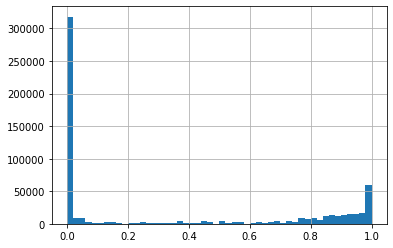

In [11]:
fig, ax = plt.subplots()
df['brand_pct_swf'].hist(bins=50, ax=ax)

In [12]:
df_future = df.loc[df['brand_order_created_date'] > train_test_split_date, :]
df = df.loc[df['brand_order_created_date']< train_test_split_date, :]

In [13]:
df.shape

(348633, 44)

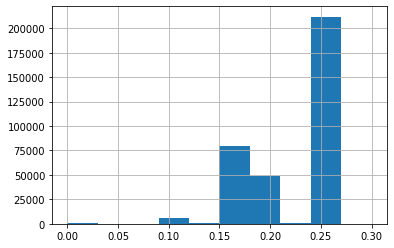

In [14]:
df['first_order_commission'].astype(float).hist()

## EDA

In [15]:
df.head()

,gmv,brand_id,brand_order_created_date,brand_order_id,brand_location,retailer_location,insider_free_freight,commission,brand_age,retailer_age,...,is_same_state,is_same_division,is_same_region,postal_zone,brand_pct_swf,brand_pct_usps,brand_pct_ups,brand_pct_fedex,brand_pct_other,avg_weight_of_products
0,270.00,396,2017-09-20 21:18:22,1207,New England,Pacific West,0.0000,27.0000,Mature,Mature,...,0.0,0.0,0.0,8,0.000000,0.025641,0.000000,0.974359,0.000000,1.939162
1,146.76,7748,2017-11-29 23:30:53,5467,Pacific West,Unknown,0.0000,29.3520,Mature,New,...,0.0,0.0,0.0,6,0.000000,0.075728,0.152427,0.748544,0.023301,1.772928
2,536.00,8907,2018-01-20 06:39:34,9917,Pacific West,Pacific West,0.0000,112.9455,New,Mature,...,0.0,1.0,1.0,5,0.860759,1.000000,0.000000,0.000000,0.000000,8.010137
3,143.88,7749,2018-02-17 16:36:05,13472,Pacific West,New England,0.0000,21.5820,Mature,New,...,0.0,0.0,0.0,5,0.000000,0.096667,0.193333,0.696667,0.013333,1.450634
4,252.00,9343,2018-03-14 20:37:04,16990,South West,Pacific West,0.0000,45.3600,New,New,...,0.0,0.0,0.0,6,0.458333,0.875000,0.000000,0.125000,0.000000,1.427283


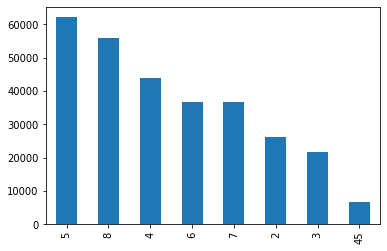

In [16]:
df['postal_zone'].value_counts().plot(kind='bar')

In [17]:
df.dtypes

gmv                                            float64
brand_id                                         int64
brand_order_created_date                datetime64[ns]
brand_order_id                                   int64
brand_location                                  object
retailer_location                               object
insider_free_freight                            object
commission                                     float64
brand_age                                       object
retailer_age                                    object
primary_brand_category                          object
primary_retailer_category                       object
brand_order_type                                object
insider_subscriber                              object
retailer_store_type                             object
freight_type                                    object
number_of_stockists                             object
primary_brand_sub_category                      object
is_elevate

In [18]:
# df['total_shipping_cost_dollars'].fillna(0).hist(bins=50)

#### Columns with NAs

In [19]:
(df.isna().sum()/df.shape[0]).loc[df.isna().sum()/df.shape[0] > 0.05]

retailer_address_type    0.073805
is_same_state            0.169582
is_same_division         0.169582
is_same_region           0.169582
postal_zone              0.169582
dtype: float64

In [20]:
# df['cm_ex_fees_from_insider'].hist(bins=50)

45 is Puerto Rico I think. Notice it's key to get rid of 7, 8 and 45.

In [21]:
# df.groupby('postal_zone')['cm_ex_fees_from_insider'].mean().plot(kind='bar')

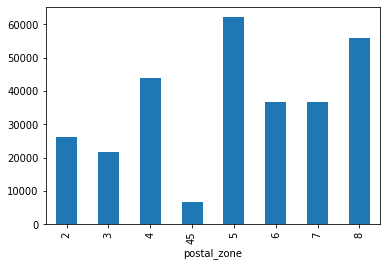

In [22]:
df.groupby('postal_zone')['brand_order_id'].nunique().plot(kind='bar')

Free 1.2% CM improvement if zones 7, 8 and 45 are removed:

In [23]:
df.shape

(348633, 44)

In [24]:
df.loc[df['postal_zone'].notna(), :].shape

(289511, 44)

In [25]:
df.loc[(df['postal_zone'].notna()) 
       & (df['postal_zone'] != '6')
       & (df['postal_zone'] != '7')
       & (df['postal_zone'] != '8')
       & (df['postal_zone'] != '45')
       , :].shape[0] / df.shape[0]

0.4411802669282598

In [26]:
df.columns

Index(['gmv', 'brand_id', 'brand_order_created_date', 'brand_order_id',
       'brand_location', 'retailer_location', 'insider_free_freight',
       'commission', 'brand_age', 'retailer_age', 'primary_brand_category',
       'primary_retailer_category', 'brand_order_type', 'insider_subscriber',
       'retailer_store_type', 'freight_type', 'number_of_stockists',
       'primary_brand_sub_category', 'is_elevate_order',
       'first_order_commission', 'is_ship_with_faire',
       'total_shipping_cost_dollars', 'net_faire_shipping_cost_dollars',
       'returned_gmv_dollars', 'maker_paid_shipping_dollars', 'is_cured',
       'is_rr_cured', 'coalesced_shipping_cost_dollars',
       'micro_avg_net_shipping_cost_fraction', 'retailer_state',
       'retailer_postal_code', 'retailer_address_type', 'brand_state',
       'brand_postal_code', 'is_same_state', 'is_same_division',
       'is_same_region', 'postal_zone', 'brand_pct_swf', 'brand_pct_usps',
       'brand_pct_ups', 'brand_pct_fedex', 

In [27]:
df.loc[df['insider_free_freight']>0, ['postal_zone', 'insider_free_freight']].groupby('postal_zone').sum()

,insider_free_freight
postal_zone,
2,67990.1900
3,64975.5800
4,125393.6600
45,27875.5100
5,199300.2000
6,127760.4700
7,136320.1600
8,227525.1600


In [28]:
df.loc[df['insider_free_freight']>0, ['postal_zone', 'gmv']].groupby('postal_zone').sum()

,gmv
postal_zone,
2,1197962.83
3,996188.16
4,1772442.78
45,246857.64
5,2644187.37
6,1561114.32
7,1544144.64
8,2420172.60


### Macro avg shipping cost differences (which we care about):

In [29]:
# zone 2
101463/1726963.7350

0.05875224704704062

In [30]:
# zone 4
184528.7400 / 2585514.0000

0.07137023431317718

In [31]:
# zone 7
194403.6800 / 2196887.2585

0.08849051276884175

In [32]:
# zone 8
330739.2400 / 3519325.2090

0.09397802713832691

Thus we have 3.5pp difference from Zone 2 to Zone 8 and 2.2 from Zone 4 to Zone 9!

#### and micro_avg differences:

In [33]:
df.loc[(df['postal_zone'].notna())
       & (df['insider_free_freight']>0)
       , :].groupby('postal_zone')['insider_free_freight']

In [34]:
df.loc[(df['postal_zone'].notna()) 
#        & (df['postal_zone'] != '6')
       & (df['postal_zone'] != '7')
       & (df['postal_zone'] != '8')
       & (df['postal_zone'] != '45')
       & (df['insider_free_freight']>0)
       , 'insider_free_freight'].mean()

17.332428351492183

In [35]:
df.loc[(df['postal_zone'].notna())
       & (df['insider_free_freight']>0)
       , 'insider_free_freight'].mean()

19.18671320295319

In [36]:
df.loc[(df['postal_zone'].notna()) 
       & (df['postal_zone'] != '7')
       & (df['postal_zone'] != '8')
       & (df['postal_zone'] != '45')
       & (df['insider_free_freight']>0)
       , 'insider_free_freight'].median()

12.5

## Group by to calculate historical brand_state GMV

TODO: remake this based on past few months

In [37]:
df[['brand_id', 'retailer_state', 'gmv']].dtypes

brand_id            int64
retailer_state     object
gmv               float64
dtype: object

In [38]:
df['gmv'] = df['gmv'].astype(float)

In [39]:
df_b_s_gmv = (df.groupby(['brand_id', 'retailer_state'])['gmv'].sum() / df['gmv'].sum() ).reset_index()

In [40]:
df_b_s_gmv.head()

,brand_id,retailer_state,gmv
0,3,AL,0.000003
1,3,AR,0.000004
2,3,CA,0.000006
3,3,CO,0.000003
4,3,FL,0.000001


#### Adding it back to main dataframe

In [41]:
df.shape

(348633, 44)

In [42]:
df = df.merge(df_b_s_gmv, on=['brand_id', 'retailer_state'])

In [43]:
df.shape

(348633, 45)

In [44]:
df['historical_gmv_fraction'] = df['gmv_y']
df['gmv'] = df['gmv_x']
df.drop(columns=['gmv_x', 'gmv_y'], inplace=True)

Add it to future df

In [45]:
df.columns.tolist()

['brand_id',
 'brand_order_created_date',
 'brand_order_id',
 'brand_location',
 'retailer_location',
 'insider_free_freight',
 'commission',
 'brand_age',
 'retailer_age',
 'primary_brand_category',
 'primary_retailer_category',
 'brand_order_type',
 'insider_subscriber',
 'retailer_store_type',
 'freight_type',
 'number_of_stockists',
 'primary_brand_sub_category',
 'is_elevate_order',
 'first_order_commission',
 'is_ship_with_faire',
 'total_shipping_cost_dollars',
 'net_faire_shipping_cost_dollars',
 'returned_gmv_dollars',
 'maker_paid_shipping_dollars',
 'is_cured',
 'is_rr_cured',
 'coalesced_shipping_cost_dollars',
 'micro_avg_net_shipping_cost_fraction',
 'retailer_state',
 'retailer_postal_code',
 'retailer_address_type',
 'brand_state',
 'brand_postal_code',
 'is_same_state',
 'is_same_division',
 'is_same_region',
 'postal_zone',
 'brand_pct_swf',
 'brand_pct_usps',
 'brand_pct_ups',
 'brand_pct_fedex',
 'brand_pct_other',
 'avg_weight_of_products',
 'historical_gmv_fractio

In [46]:
df_future.loc[:, 'historical_gmv_fraction'] = df_future.merge(df[['brand_id',
                                                           'retailer_state',
                                                           'historical_gmv_fraction']],
                                                       on=['brand_id', 'retailer_state'],
                                                       how='left'
                                                      )

In [47]:
df_future.head()

,gmv,brand_id,brand_order_created_date,brand_order_id,brand_location,retailer_location,insider_free_freight,commission,brand_age,retailer_age,...,is_same_division,is_same_region,postal_zone,brand_pct_swf,brand_pct_usps,brand_pct_ups,brand_pct_fedex,brand_pct_other,avg_weight_of_products,historical_gmv_fraction
855,44.94,11972,2019-08-02 20:24:00,430291,Pacific West,Unknown,0.0000,8.0892,Mature,Mature,...,0.0,0.0,5,0.000000,0.313433,0.194030,0.477612,0.014925,1.880657,0.000035
856,288.00,16020,2019-08-05 22:41:46,435030,Northwest Midwest,Pacific West,14.8000,43.2000,Mature,Mature,...,0.0,0.0,7,0.006849,1.000000,0.000000,0.000000,0.000000,1.267522,0.000035
857,174.00,20265,2019-08-08 02:30:13,440016,South Atlantic,Unknown,0.0000,48.8700,Mature,New,...,NaN,NaN,None,0.450000,0.900000,0.000000,0.000000,0.100000,3.098730,0.000035
858,781.50,27035,2019-08-11 16:14:45,445684,South West,Pacific West,0.0000,0.0000,Mature,New,...,0.0,0.0,7,0.052632,0.442982,0.000000,0.539474,0.017544,1.765517,0.000035
859,104.76,11582,2019-08-13 23:25:42,450982,Pacific West,Middle Atlantic,0.0000,18.8568,Mature,Mature,...,0.0,0.0,8,0.987179,0.185897,0.011218,0.802885,0.000000,5.887683,0.000035


In [48]:
(df.groupby(['brand_id', 'retailer_state'])['historical_gmv_fraction'].mean()).sum()

1.0

In [49]:
df.columns

Index(['brand_id', 'brand_order_created_date', 'brand_order_id',
       'brand_location', 'retailer_location', 'insider_free_freight',
       'commission', 'brand_age', 'retailer_age', 'primary_brand_category',
       'primary_retailer_category', 'brand_order_type', 'insider_subscriber',
       'retailer_store_type', 'freight_type', 'number_of_stockists',
       'primary_brand_sub_category', 'is_elevate_order',
       'first_order_commission', 'is_ship_with_faire',
       'total_shipping_cost_dollars', 'net_faire_shipping_cost_dollars',
       'returned_gmv_dollars', 'maker_paid_shipping_dollars', 'is_cured',
       'is_rr_cured', 'coalesced_shipping_cost_dollars',
       'micro_avg_net_shipping_cost_fraction', 'retailer_state',
       'retailer_postal_code', 'retailer_address_type', 'brand_state',
       'brand_postal_code', 'is_same_state', 'is_same_division',
       'is_same_region', 'postal_zone', 'brand_pct_swf', 'brand_pct_usps',
       'brand_pct_ups', 'brand_pct_fedex', 'brand_

## Convert Data Types

In [50]:
df.dtypes.loc[df.dtypes=='object']

brand_location                     object
retailer_location                  object
insider_free_freight               object
brand_age                          object
retailer_age                       object
primary_brand_category             object
primary_retailer_category          object
brand_order_type                   object
insider_subscriber                 object
retailer_store_type                object
freight_type                       object
number_of_stockists                object
primary_brand_sub_category         object
first_order_commission             object
total_shipping_cost_dollars        object
net_faire_shipping_cost_dollars    object
maker_paid_shipping_dollars        object
coalesced_shipping_cost_dollars    object
retailer_state                     object
retailer_postal_code               object
retailer_address_type              object
brand_state                        object
brand_postal_code                  object
postal_zone                       

#### Floats

In [51]:
to_float_cols = [
    'commission',
    'first_order_commission',
    'gmv',
    'returns',
    'defaults',
#     'support_credits',
#     'referral_credits',
    'insider_free_freight',
#     'reverse_freight',
#     'redistribution',
#     'loss_on_returns',
#     'pmt_processing_fee',
#     'net_contribution_ex_fees_from_insider_and_opex',
#     'net_cp_ex_insider',
    'total_shipping_cost_dollars', 
    'net_faire_shipping_cost_dollars', 
    'returned_gmv_dollars', 
    'return_order_faire_shipping_cost_dollars', 
    'maker_paid_shipping_dollars', 
#     'swf_profit',
]

In [52]:
for c in to_float_cols:
    if c in df.columns.tolist():
        df[c] = df[c].astype(float)
        df_future[c] = df_future[c].astype(float)

#### Ints

In [53]:
to_int_cols = [
#     'retailer_age',
#     'brand_age',
#     'brand_postal_code',
#     'retailer_postal_code',
    'postal_zone',
]

In [54]:
for c in to_int_cols:
    print(c)
    df[c] = df[c].fillna(-99).astype(int)
    df_future[c] = df_future[c].fillna(-99).astype(int)

postal_zone


### One-Hot-Encode some variables

In [55]:
to_ohe_cols = [
    'freight_type',
    'brand_order_type',
    'primary_brand_category',
    'primary_brand_sub_category',
    'primary_retailer_category',
    'number_of_stockists',
    'retailer_age',
    'brand_age',
    'brand_location',
    'retailer_location',
    'retailer_store_type',
    'retailer_address_type',
    'insider_subscriber',
]

In [56]:
df_ohe = pd.get_dummies(df[to_ohe_cols])
df_future_ohe = pd.get_dummies(df_future[to_ohe_cols])

In [57]:
df.shape

(348633, 45)

In [58]:
df = pd.concat([df, df_ohe], axis=1)
df_future = pd.concat([df_future, df_future_ohe], axis=1)

In [59]:
df.shape

(348633, 223)

In [60]:
df.head()

,brand_id,brand_order_created_date,brand_order_id,brand_location,retailer_location,insider_free_freight,commission,brand_age,retailer_age,primary_brand_category,...,retailer_location_South West,retailer_location_Unknown,retailer_store_type_Brick & Mortar Store,retailer_store_type_Online Only,retailer_store_type_Pop Up Store,retailer_store_type_Unknown,retailer_address_type_COMMERCIAL,retailer_address_type_RESIDENTIAL,insider_subscriber_Insider,insider_subscriber_Non-Insider
0,396,2017-09-20 21:18:22,1207,New England,Pacific West,0.00,27.0,Mature,Mature,Home Decor,...,0,0,0,0,0,1,1,0,1,0
1,396,2017-07-31 21:48:39,712,New England,Pacific West,0.00,27.0,Mature,New,Home Decor,...,0,0,0,0,0,1,1,0,0,1
2,396,2017-07-30 19:01:34,664,New England,Pacific West,0.00,29.4,Mature,New,Home Decor,...,0,0,0,0,0,1,1,0,0,1
3,396,2019-01-10 23:18:27,182034,New England,Pacific West,49.98,40.5,Mature,Mature,Home Decor,...,0,0,0,0,0,1,1,0,1,0
4,396,2017-07-30 22:59:55,673,New England,Pacific West,0.00,24.2,Mature,New,Home Decor,...,0,0,0,0,0,1,1,0,0,1


## Collumns to use in model

In [61]:
df.columns.tolist()

['brand_id',
 'brand_order_created_date',
 'brand_order_id',
 'brand_location',
 'retailer_location',
 'insider_free_freight',
 'commission',
 'brand_age',
 'retailer_age',
 'primary_brand_category',
 'primary_retailer_category',
 'brand_order_type',
 'insider_subscriber',
 'retailer_store_type',
 'freight_type',
 'number_of_stockists',
 'primary_brand_sub_category',
 'is_elevate_order',
 'first_order_commission',
 'is_ship_with_faire',
 'total_shipping_cost_dollars',
 'net_faire_shipping_cost_dollars',
 'returned_gmv_dollars',
 'maker_paid_shipping_dollars',
 'is_cured',
 'is_rr_cured',
 'coalesced_shipping_cost_dollars',
 'micro_avg_net_shipping_cost_fraction',
 'retailer_state',
 'retailer_postal_code',
 'retailer_address_type',
 'brand_state',
 'brand_postal_code',
 'is_same_state',
 'is_same_division',
 'is_same_region',
 'postal_zone',
 'brand_pct_swf',
 'brand_pct_usps',
 'brand_pct_ups',
 'brand_pct_fedex',
 'brand_pct_other',
 'avg_weight_of_products',
 'historical_gmv_fractio

## Slim data before group by brand, state

Don't consider any data before start date

In [62]:
print(start_date)

2017-01-01


In [63]:
df.shape

(348633, 223)

### Apply start date cut

In [64]:
df = df.loc[df['brand_order_created_date']>start_date, :]

## Split interactions into train and test sets

In [65]:
# df_test = df.loc[df['brand_order_created_date']>train_test_split_date, :]
# df means df_train
# df = df.loc[df['brand_order_created_date']<=train_test_split_date, :]

In [66]:
df.shape

(348633, 223)

(0, 150)

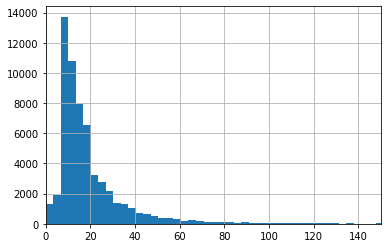

In [67]:
df.loc[df['insider_free_freight']>0, 'insider_free_freight'].hist(bins=500)
plt.xlim(0, 150)

`insider_free_freight` is the same as `total_shipping_cost_dollars` when it's an insider order:

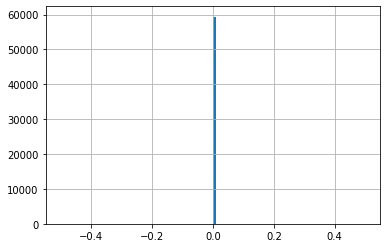

In [68]:
(df.loc[df['insider_free_freight']>0, 'insider_free_freight'] 
 - df.loc[df['insider_free_freight']>0, 'total_shipping_cost_dollars']).hist(bins=100)

In [69]:
slim_cols = [
    'brand_order_id',
    'is_cured',
    'is_rr_cured',
#     'revenue_recognition_date',
    'brand_order_created_date',
#     'first_received_order_created_at',
#     'brand_first_first_active_at',
#     'first_confirmed_order_placed_at',
    'brand_id',
#     'retailer_id',
    'primary_brand_category',
#     'primary_retailer_category',
#     'number_of_stockists',
#     'retailer_age',
#     'brand_age',
#     'brand_order_type',
#     'freight_type',
    'brand_location',
    'avg_weight_of_products', 
    'retailer_location',
#     'brand_first_order_minimum',
#     'summary_channel',
#     'actual_channel',
#     'last_touch_source_signup_conversion',
    'power_retailer',
#     'retailer_qualified_for_terms',
#     'max_retailer_payment_terms_offered',
#     'retailer_min_sales',
#     'retailer_store_type',
#     'insider_subscriber',
    'commission',
    'returns',
    'defaults',
    'support_credits',
    'referral_credits',
    'shipping_rev',
    'swf_profit',
    'insider_free_freight',
    'reverse_freight',
    'redistribution',
    'is_ship_with_faire',
    'loss_on_returns',
    'pmt_processing_fee',
    'net_contribution_ex_fees_from_insider_and_opex',
    'net_cp_ex_insider',
    'cm_ex_fees_from_insider_and_opex',
    'cm_ex_fees_from_insider',
    'is_elevate_order',
    'total_shipping_cost_dollars',
    'net_faire_shipping_cost_dollars',
    'returned_gmv_dollars',
    'return_order_faire_shipping_cost_dollars',
    'maker_paid_shipping_dollars',
    'micro_avg_net_shipping_cost_fraction',
    'retailer_state',
#     'retailer_postal_code',
    'retailer_address_type',
    'brand_state',
#     'brand_postal_code',
    'is_same_state',
    'is_same_division',
    'is_same_region',
    'postal_zone',
    'brand_pct_swf',
    'brand_pct_fedex',
    'brand_pct_ups',
    'brand_pct_usps',
    'historical_gmv_fraction',
    'gmv',
    'freight_type_Freight_Cap',
    'freight_type_Freight_Parity',
    'freight_type_Freight_Profit',
    'freight_type_Insider_Free',
    'freight_type_Not_Yet_Delivered_or_Null',
    'freight_type_Other_Free',
    'brand_order_type_Elevate',
    'brand_order_type_Opening',
    'brand_order_type_Repeat',
    'primary_brand_category_Accessories',
    'primary_brand_category_Beauty',
    'primary_brand_category_Home Decor',
    'primary_brand_category_Jewelry',
    'primary_brand_category_Kids',
    'primary_brand_category_Kitchen',
    'primary_brand_category_Men',
    'primary_brand_category_Other',
    'primary_brand_category_Pets',
    'primary_brand_category_Stationery',
    "primary_brand_category_Women's Apparel",
#     'primary_retailer_category_alcohol',
#     'primary_retailer_category_antique',
#     'primary_retailer_category_arts_crafts',
#     'primary_retailer_category_beauty',
#     'primary_retailer_category_books',
#     'primary_retailer_category_boutique',
#     'primary_retailer_category_bridal',
#     'primary_retailer_category_cafe',
#     'primary_retailer_category_clothing',
#     'primary_retailer_category_clothing_kids',
#     'primary_retailer_category_clothing_men',
#     'primary_retailer_category_clothing_women',
#     'primary_retailer_category_convenience',
#     'primary_retailer_category_fitness',
#     'primary_retailer_category_florist',
#     'primary_retailer_category_furniture',
#     'primary_retailer_category_gift',
#     'primary_retailer_category_grocery',
#     'primary_retailer_category_hardware',
#     'primary_retailer_category_health',
#     'primary_retailer_category_home',
#     'primary_retailer_category_hotel',
#     'primary_retailer_category_jewelry',
#     'primary_retailer_category_lawn_garden',
#     'primary_retailer_category_luggage_bags',
#     'primary_retailer_category_medical',
#     'primary_retailer_category_mercantile_general',
#     'primary_retailer_category_museum',
#     'primary_retailer_category_not found',
#     'primary_retailer_category_office',
#     'primary_retailer_category_other',
#     'primary_retailer_category_pet',
#     'primary_retailer_category_pharmacy',
#     'primary_retailer_category_restaurant_takeaway',
#     'primary_retailer_category_shoes',
#     'primary_retailer_category_skincare',
#     'primary_retailer_category_spa_salon',
#     'primary_retailer_category_specialty_food',
#     'primary_retailer_category_sport_outdoors',
#     'primary_retailer_category_stationery',
#     'primary_retailer_category_toy',
#     'primary_retailer_category_vintage_consignment',
#     'primary_retailer_category_yoga_workout',
    'number_of_stockists_1001-2000',
    'number_of_stockists_2001-10000',
    'number_of_stockists_251-1000',
    'number_of_stockists_51-250',
    'number_of_stockists_<=50',
    'number_of_stockists_Unknown',
#     'retailer_age_Mature',
#     'retailer_age_New',
    'brand_age_Mature',
    'brand_age_New',
    'brand_location_Canada',
    'brand_location_Middle Atlantic',
    'brand_location_New England',
    'brand_location_Northeast Midwest',
    'brand_location_Northwest Midwest',
    'brand_location_Pacific West',
    'brand_location_South Atlantic',
    'brand_location_South East',
    'brand_location_South West',
    'brand_location_Unknown',
    'retailer_location_Canada',
    'retailer_location_Middle Atlantic',
    'retailer_location_New England',
    'retailer_location_Northeast Midwest',
    'retailer_location_Northwest Midwest',
    'retailer_location_Pacific West',
    'retailer_location_South Atlantic',
    'retailer_location_South East',
    'retailer_location_South West',
    'retailer_location_Unknown',
    'retailer_address_type_RESIDENTIAL',
    'retailer_address_type_COMMERCIAL',
#     'retailer_store_type_Brick & Mortar Store',
#     'retailer_store_type_Online Only',
#     'retailer_store_type_Pop Up Store',
#     'retailer_store_type_Unknown',
    'insider_subscriber_Insider',
    'insider_subscriber_Non-Insider',
    'first_order_commission',
    'coalesced_shipping_cost_dollars',
]

In [70]:
slim_cols = [x for x in slim_cols if x in df.columns.tolist()]
df = df[slim_cols]

In [71]:
df_future = df_future[slim_cols]

In [72]:
df.shape

(348633, 85)

## Group by brand and retailer_state

- Add mean of CM and Insider freight fractions
- Count orders to that state

### Build grouped_by dataframe from cartesian product of brands and states:

In [73]:
a = df['brand_id'].unique().tolist()
b = df['retailer_state'].unique().tolist()

index = pd.MultiIndex.from_product([a, b], names = ["brand_id", "retailer_state"])

df_unlabeled = pd.DataFrame(index = index).reset_index()
df_gb = df_unlabeled.copy()

In [74]:
print('# of brands:', df_gb['brand_id'].nunique())
print('# of states:', df_gb['retailer_state'].nunique())
print('df_gb shape:', df_gb.shape)

# of brands: 5190
# of states: 63
df_gb shape: (326970, 2)


In [75]:
50*5523

276150

In [76]:
df_gb.drop_duplicates().shape[0]

326970

In [77]:
df_gb = df_gb.merge(df[['brand_id','retailer_state', 'historical_gmv_fraction']].drop_duplicates(), 
                    on=['brand_id', 'retailer_state'],
                    how='left'
                   )

In [78]:
df_gb['historical_gmv_fraction'] = df_gb['historical_gmv_fraction'].fillna(0) 

In [79]:
df_gb['historical_gmv_fraction'].sum()

0.9999999999999999

In [80]:
df_gb.drop_duplicates().shape[0]

326970

In [81]:
df_gb.shape[0]

326970

In [82]:
df_gb['historical_gmv_fraction'].sum()

0.9999999999999999

In [83]:
df_gb.head()

,brand_id,retailer_state,historical_gmv_fraction
0,396,CA,0.000257
1,396,UT,0.000044
2,396,WA,0.000034
3,396,CT,0.000008
4,396,WY,0.000000


### Create separate brand features df for easier merge later:

Brand features like carrier usage, age, etc

In [84]:
# df[['brand_id', 'brand_age_New']].head(20)

In [85]:
brand_features = [
    'brand_pct_swf',
    'avg_weight_of_products', 
    'first_order_commission',
    'brand_pct_fedex',
    'brand_pct_ups',
    'brand_pct_usps',
    'brand_location',
    'brand_state',
    'brand_location_Canada',
    'brand_location_Middle Atlantic',
    'brand_location_New England',
    'brand_location_Northeast Midwest',
    'brand_location_Northwest Midwest',
    'brand_location_Pacific West',
    'brand_location_South Atlantic',
    'brand_location_South East',
    'brand_location_South West',
    'brand_location_Unknown',
    'number_of_stockists_1001-2000',
    'number_of_stockists_2001-10000',
    'number_of_stockists_251-1000',
    'number_of_stockists_51-250',
    'number_of_stockists_<=50',
    'primary_brand_category',
    'primary_brand_category_Accessories',
    'primary_brand_category_Beauty',
    'primary_brand_category_Home Decor',
    'primary_brand_category_Jewelry',
    'primary_brand_category_Kids',
    'primary_brand_category_Kitchen',
    'primary_brand_category_Men',
    'primary_brand_category_Other',
    'primary_brand_category_Pets',
    'primary_brand_category_Stationery',
    "primary_brand_category_Women's Apparel",
]

In [86]:
df_brand = df[['brand_id'] + brand_features].drop_duplicates()

In [87]:
df_brand.shape

(5190, 36)

In [88]:
df_brand.drop_duplicates().shape

(5190, 36)

In [89]:
df_brand.head()

,brand_id,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,brand_location,brand_state,brand_location_Canada,...,primary_brand_category_Beauty,primary_brand_category_Home Decor,primary_brand_category_Jewelry,primary_brand_category_Kids,primary_brand_category_Kitchen,primary_brand_category_Men,primary_brand_category_Other,primary_brand_category_Pets,primary_brand_category_Stationery,primary_brand_category_Women's Apparel
0,396,0.000000,1.939162,0.15,0.974359,0.000000,0.025641,New England,MA,0,...,0,1,0,0,0,0,0,0,0,0
66,7748,0.000000,1.772928,0.15,0.748544,0.152427,0.075728,Pacific West,WA,0,...,0,0,0,0,1,0,0,0,0,0
75,8907,0.860759,8.010137,0.18,0.000000,0.000000,1.000000,Pacific West,CA,0,...,1,0,0,0,0,0,0,0,0,0
79,7749,0.000000,1.450634,0.15,0.696667,0.193333,0.096667,Pacific West,WA,0,...,0,0,0,0,1,0,0,0,0,0
82,9343,0.458333,1.427283,0.18,0.125000,0.000000,0.875000,South West,AR,0,...,0,0,1,0,0,0,0,0,0,0


Add average `maker_paid_shipping_dollars` for SwF orders because that's extra cost

In [90]:
# df_brand['extra_shipping_cost_dollars'] = df.loc[
#     df['is_ship_with_faire']==true, :
# ].groupby('brand_id')['maker_paid_shipping_dollars'].sum()

In [91]:
df_brand = df_brand.loc[df_brand['brand_location']!='Canada', :]

In [92]:
df_gb = df_gb.merge(df_brand, on='brand_id', how='inner')

In [93]:
df_gb['historical_gmv_fraction'].sum()

0.9792274894722683

In [94]:
df_gb.drop_duplicates()['historical_gmv_fraction'].sum()

0.9792274894722683

### A few easy features to engineer (consider doing in SQL)

In [95]:
df_gb['is_HI'] = df_gb[['brand_state', 'retailer_state']].apply(
    lambda x: 1 if (x['retailer_state'] == 'HI' or x['brand_state'] == 'HI') else 0
    , axis=1
)

In [96]:
df_gb['is_AK'] = df_gb[['brand_state', 'retailer_state']].apply(
    lambda x: 1 if (x['retailer_state'] == 'AK' or x['brand_state'] == 'AK') else 0
    , axis=1
)

In [97]:
df_gb['same_state'] = df_gb[['brand_state', 'retailer_state']].apply(
    lambda x: 1 if x['brand_state'] == x['retailer_state'] else 0
    , axis=1
)

In [98]:
df_gb.columns.tolist()

['brand_id',
 'retailer_state',
 'historical_gmv_fraction',
 'brand_pct_swf',
 'avg_weight_of_products',
 'first_order_commission',
 'brand_pct_fedex',
 'brand_pct_ups',
 'brand_pct_usps',
 'brand_location',
 'brand_state',
 'brand_location_Canada',
 'brand_location_Middle Atlantic',
 'brand_location_New England',
 'brand_location_Northeast Midwest',
 'brand_location_Northwest Midwest',
 'brand_location_Pacific West',
 'brand_location_South Atlantic',
 'brand_location_South East',
 'brand_location_South West',
 'brand_location_Unknown',
 'number_of_stockists_1001-2000',
 'number_of_stockists_2001-10000',
 'number_of_stockists_251-1000',
 'number_of_stockists_51-250',
 'number_of_stockists_<=50',
 'primary_brand_category',
 'primary_brand_category_Accessories',
 'primary_brand_category_Beauty',
 'primary_brand_category_Home Decor',
 'primary_brand_category_Jewelry',
 'primary_brand_category_Kids',
 'primary_brand_category_Kitchen',
 'primary_brand_category_Men',
 'primary_brand_category

### Start feature engineering from group by 

In [99]:
df_gb.shape

(319095, 41)

In [100]:
df_temp = df.groupby(['brand_id', 'retailer_state'])['brand_order_id'].nunique().reset_index()
df_temp.columns = df_temp.columns.tolist()[:-1] + ['num_brand_orders_to_state']

df_gb = df_gb.merge(df_temp, on=['brand_id', 'retailer_state'], how='left')

In [101]:
df_gb.loc[:, 'num_brand_orders_to_state'] = df_gb['num_brand_orders_to_state'].fillna(0)

In [102]:
df_temp = df.groupby(['brand_id'])['brand_order_id'].nunique().reset_index()
df_temp.columns = df_temp.columns.tolist()[:-1] + ['num_brand_orders']

df_gb = df_gb.merge(df_temp, on=['brand_id'], how='left')

In [103]:
df_temp = df.loc[df['is_cured']==1, :].groupby(['brand_id'])['brand_order_id'].nunique().reset_index()
df_temp.columns = df_temp.columns.tolist()[:-1] + ['num_cured_brand_orders']

df_gb = df_gb.merge(df_temp, on=['brand_id'], how='left')

In [104]:
df_temp = df.loc[df['is_rr_cured']==1, :].groupby(['brand_id'])['brand_order_id'].nunique().reset_index()
df_temp.columns = df_temp.columns.tolist()[:-1] + ['num_rr_cured_brand_orders']

df_gb = df_gb.merge(df_temp, on=['brand_id'], how='left')

In [105]:
df_gb.loc[:, 'num_brand_orders_to_state'] = df_gb['num_brand_orders_to_state'].fillna(0)
df_gb.loc[:, 'num_brand_orders'] = df_gb['num_brand_orders'].fillna(0)
df_gb.loc[:, 'num_cured_brand_orders'] = df_gb['num_cured_brand_orders'].fillna(0)
df_gb.loc[:, 'num_rr_cured_brand_orders'] = df_gb['num_rr_cured_brand_orders'].fillna(0)

### Only do brands with at least 4 cured orders

*NOTE*: replace this with cured orders

In [106]:
df_gb['brand_id'].nunique()

5065

#### Only use shipment cured brands 

In [107]:
# df_gb = df_gb.loc[df_gb['num_brand_orders']>=4, :]
# df_gb = df_gb.loc[df_gb['num_cured_brand_orders']>=4, :]

In [108]:
df_gb['brand_id'].nunique()

5065

In [109]:
# df_gb_test = df.groupby(['brand_id', 'retailer_state'])['brand_order_id'].nunique().reset_index()
# df_gb_test.columns = df_gb_test.columns.tolist()[:-1] + ['num_brand_orders_to_state']

In [110]:
df_gb.head()

,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,brand_location,...,primary_brand_category_Pets,primary_brand_category_Stationery,primary_brand_category_Women's Apparel,is_HI,is_AK,same_state,num_brand_orders_to_state,num_brand_orders,num_cured_brand_orders,num_rr_cured_brand_orders
0,396,CA,0.000257,0.0,1.939162,0.15,0.974359,0.0,0.025641,New England,...,0,0,0,0,0,0,66.0,354,354,354
1,396,UT,0.000044,0.0,1.939162,0.15,0.974359,0.0,0.025641,New England,...,0,0,0,0,0,0,9.0,354,354,354
2,396,WA,0.000034,0.0,1.939162,0.15,0.974359,0.0,0.025641,New England,...,0,0,0,0,0,0,7.0,354,354,354
3,396,CT,0.000008,0.0,1.939162,0.15,0.974359,0.0,0.025641,New England,...,0,0,0,0,0,0,2.0,354,354,354
4,396,WY,0.000000,0.0,1.939162,0.15,0.974359,0.0,0.025641,New England,...,0,0,0,0,0,0,0.0,354,354,354


In [111]:
df_gb.shape

(319095, 45)

In [112]:
df_gb = df_gb.drop_duplicates()

In [113]:
df_gb.shape

(319095, 45)

In [114]:
def add_to_df_gb(df_gb,
                 df_full,
                 column,
                 aggtypes = ['mean'],
                 gb_cols = ['brand_id', 'retailer_state'],
                 prefix='bs',
                 how='left',
                 fillna=-99
                ):
    
    if 'mean' in aggtypes:
        df_temp = df_full.groupby(gb_cols)[column].mean().reset_index()
        df_temp.columns = df_temp.columns.tolist()[:-1] + ['mean_'+prefix+'_'+column]
    if 'num' in aggtypes:
        df_temp = df_full.groupby(gb_cols)[column].nunique().reset_index()
        df_temp.columns = df_temp.columns.tolist()[:-1] + ['num_'+prefix+'_'+column]
    if 'sum' in aggtypes:
        df_temp = df_full.groupby(gb_cols)[column].sum().reset_index()
        df_temp.columns = df_temp.columns.tolist()[:-1] + ['sum_'+prefix+'_'+column]
    if 'mode' in aggtypes:
        df_temp = df_full.loc[df_full['postal_zone']!=-99, :].groupby(gb_cols)[column].agg(
            lambda x:x.value_counts().index[0]
        ).reset_index()
        df_temp.columns = df_temp.columns.tolist()[:-1] + ['mode_'+prefix+'_'+column]
    
    df_temp = df_temp.loc[:, set(gb_cols + [x+'_'+prefix+'_'+column for x in aggtypes])]
    new_df = df_gb.merge(df_temp, on=gb_cols, how=how)
    
    if how=='left':
#         print(new_df.columns.tolist())
        new_df.loc[:, [x+'_'+prefix+'_'+column for x in aggtypes]].fillna(fillna, inplace=True)
    
    return new_df

### Add the gb features here:

In [115]:
df_temp2 = df[['brand_id', 'retailer_state', 'postal_zone']].head()

df_temp2.groupby(['brand_id', 'retailer_state'])['postal_zone'].agg(lambda x: x.value_counts().index[0]).reset_index()

,brand_id,retailer_state,postal_zone
0,396,CA,8


In [116]:
df_gb.shape

(319095, 45)

In [117]:
# df.groupby(['brand_id', 'retailer_state'])['postal_zone'].agg(
#     lambda x: x.value_counts().index[0]
# )

In [118]:
state_gb_mean_features = [
    'retailer_address_type_RESIDENTIAL',
#     '',
]

In [119]:
brand_state_gb_mean_features = [
    'net_shipping_cost_fraction',
]

In [120]:
brand_gb_sum_features = [
    'maker_paid_shipping_dollars',
    'gmv',
    'returned_gmv_dollars'
]

In [121]:
brand_gb_mean_features = [
    'brand_age_New',
]

In [122]:
brand_gb_countdistinct_features = [
    'brand_order_id',
]

In [123]:
brand_state_gb_sum_features = [
    'total_shipping_cost_dollars',
    'net_faire_shipping_cost_dollars',
    'coalesced_shipping_cost_dollars',
    'gmv',
]

In [124]:
brand_state_gb_mode_features = [
    'postal_zone',
#     '',
]

In [125]:
df_gb.shape

(319095, 45)

In [126]:
for f in state_gb_mean_features:
    df_gb = add_to_df_gb(df_gb, df, f, gb_cols = ['retailer_state'], prefix='s')
#     df_gb_test = add_to_df_gb(df_gb_test, df_test, f, gb_cols = ['retailer_state'], prefix='s')

In [127]:
df_gb.shape

(319095, 46)

In [128]:
for f in brand_state_gb_mode_features:
    df_gb = add_to_df_gb(df_gb, df, f,
                         gb_cols = ['brand_id', 'retailer_state'],
                         aggtypes=['mode'],
                         prefix='bs'
                        )

In [129]:
df.loc[df['brand_id']==51685, 'brand_state']

231874    OR
331979    OR
347201    OR
Name: brand_state, dtype: object

In [130]:
df.shape

(348633, 85)

### Double check zone distributions

In [131]:
df_gb.loc[(df_gb['brand_state']=='CA') & (df_gb['retailer_state']=='NY'), 'mode_bs_postal_zone'].value_counts()

8.0    446
2.0      9
5.0      5
6.0      4
4.0      3
7.0      3
3.0      3
Name: mode_bs_postal_zone, dtype: int64

In [132]:
df_gb.loc[(df_gb['brand_state']=='IL') & (df_gb['retailer_state']=='NY'), 'mode_bs_postal_zone'].value_counts()

5.0    65
4.0     9
Name: mode_bs_postal_zone, dtype: int64

In [133]:
df_gb.loc[(df_gb['brand_state']=='MA') & (df_gb['retailer_state']=='NY'), 'mode_bs_postal_zone'].value_counts()

3.0    25
2.0    23
4.0     4
5.0     2
8.0     1
Name: mode_bs_postal_zone, dtype: int64

In [134]:
df_gb['mode_bs_postal_zone'].isna().sum()

256687

In [135]:
df_gb['mode_bs_postal_zone'].notna().sum()

62408

In [136]:
df_gb.columns.tolist()

['brand_id',
 'retailer_state',
 'historical_gmv_fraction',
 'brand_pct_swf',
 'avg_weight_of_products',
 'first_order_commission',
 'brand_pct_fedex',
 'brand_pct_ups',
 'brand_pct_usps',
 'brand_location',
 'brand_state',
 'brand_location_Canada',
 'brand_location_Middle Atlantic',
 'brand_location_New England',
 'brand_location_Northeast Midwest',
 'brand_location_Northwest Midwest',
 'brand_location_Pacific West',
 'brand_location_South Atlantic',
 'brand_location_South East',
 'brand_location_South West',
 'brand_location_Unknown',
 'number_of_stockists_1001-2000',
 'number_of_stockists_2001-10000',
 'number_of_stockists_251-1000',
 'number_of_stockists_51-250',
 'number_of_stockists_<=50',
 'primary_brand_category',
 'primary_brand_category_Accessories',
 'primary_brand_category_Beauty',
 'primary_brand_category_Home Decor',
 'primary_brand_category_Jewelry',
 'primary_brand_category_Kids',
 'primary_brand_category_Kitchen',
 'primary_brand_category_Men',
 'primary_brand_category

In [137]:
df_state_locations = df[['retailer_state', 'retailer_location']].drop_duplicates()

In [138]:
df_state_locations = df_state_locations.loc[df_state_locations['retailer_location']!='Unknown', :]

In [139]:
df_state_locations.head()

,retailer_state,retailer_location
0,CA,Pacific West
68,UT,Pacific West
75,WA,Pacific West
79,CT,New England
82,WY,Pacific West


In [140]:
df_state_locations.shape

(61, 2)

In [141]:
df_gb = df_gb.merge(df_state_locations, on='retailer_state')

In [142]:
df_gb['same_location'] = df_gb[['brand_location', 'retailer_location']].apply(
    lambda x: 1 if x['brand_location'] == x['retailer_location'] else 0
    , axis=1
)

#### Impute most likely zone in progressively larger aggregations if RxB pair lacks one

In [143]:
df_temp = add_to_df_gb(df_gb,
                       df,
                       'postal_zone',
                       gb_cols = ['brand_state', 'retailer_state'],
                       aggtypes=['mode'],
                       prefix='rsbs'
                      )

In [144]:
df_temp2 = add_to_df_gb(df_gb,
                       df,
                       'postal_zone',
                       gb_cols = ['brand_state', 'retailer_location'],
                       aggtypes=['mode'],
                       prefix='rlbs'
                      )

In [145]:
df_temp3 = add_to_df_gb(df_gb,
                       df,
                       'postal_zone',
                       gb_cols = ['brand_location', 'retailer_state'],
                       aggtypes=['mode'],
                       prefix='rsbl'
                      )

In [146]:
df_temp4 = add_to_df_gb(df_gb,
                       df,
                       'postal_zone',
                       gb_cols = ['brand_location', 'retailer_location'],
                       aggtypes=['mode'],
                       prefix='rlbl'
                      )

In [147]:
df_gb['mode_bs_postal_zone'].isna().sum() 

246572

In [148]:
df_gb['mode_bs_postal_zone'] = np.where(df_gb["mode_bs_postal_zone"].isnull() == True,
                                     df_temp["mode_rsbs_postal_zone"],
                                     df_gb["mode_bs_postal_zone"] )

df_gb['mode_bs_postal_zone'] = np.where(df_gb["mode_bs_postal_zone"].isnull() == True,
                                     df_temp2["mode_rlbs_postal_zone"],
                                     df_gb["mode_bs_postal_zone"] )

df_gb['mode_bs_postal_zone'] = np.where(df_gb["mode_bs_postal_zone"].isnull() == True,
                                     df_temp3["mode_rsbl_postal_zone"],
                                     df_gb["mode_bs_postal_zone"] )

df_gb['mode_bs_postal_zone'] = np.where(df_gb["mode_bs_postal_zone"].isnull() == True,
                                     df_temp4["mode_rlbl_postal_zone"],
                                     df_gb["mode_bs_postal_zone"] )

In [149]:
df_gb['mode_bs_postal_zone'].isna().sum() 

50650

In [150]:
df_gb.loc[df_gb['mode_bs_postal_zone'].isna()==True, :].head()

,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,brand_location,...,is_AK,same_state,num_brand_orders_to_state,num_brand_orders,num_cured_brand_orders,num_rr_cured_brand_orders,mean_s_retailer_address_type_RESIDENTIAL,mode_bs_postal_zone,retailer_location,same_location
192470,396,AB,0.000032,0.000000,1.939162,0.15,0.974359,0.000000,0.025641,New England,...,0,0,5.0,354,354,354,0.002519,NaN,Canada,0
192471,7748,AB,0.000000,0.000000,1.772928,0.15,0.748544,0.152427,0.075728,Pacific West,...,0,0,0.0,1618,1618,1618,0.002519,NaN,Canada,0
192472,8907,AB,0.000000,0.860759,8.010137,0.18,0.000000,0.000000,1.000000,Pacific West,...,0,0,0.0,153,153,153,0.002519,NaN,Canada,0
192473,7749,AB,0.000002,0.000000,1.450634,0.15,0.696667,0.193333,0.096667,Pacific West,...,0,0,1.0,595,595,595,0.002519,NaN,Canada,0
192474,9343,AB,0.000000,0.458333,1.427283,0.18,0.125000,0.000000,0.875000,South West,...,0,0,0.0,93,93,93,0.002519,NaN,Canada,0


## Still rows with missing zones due to retailers in Canada. Drop them

In [151]:
df_gb.loc[df_gb['mode_bs_postal_zone'].isna(), 'retailer_state'].value_counts()

NB    5065
ON    5065
MB    5065
QC    5065
BC    5065
SK    5065
NS    5065
YT    5065
AB    5065
NL    5065
Name: retailer_state, dtype: int64

In [152]:
df_gb = df_gb.loc[~df_gb['retailer_state'].isin(['SK','QC', 'YT', 'MB', 'NL', 'BC', 'AB', 'NS', 'NB', 'PE', 'ON']),
                  :
                 ]

In [153]:
df_gb['mode_bs_postal_zone'].isna().sum()

0

Only use SwF for the brand extra cost dollars calculation

In [154]:
df_gb.shape

(258315, 49)

In [155]:
df_gb['historical_gmv_fraction'] = df_gb['historical_gmv_fraction'].fillna(0)

In [156]:
for f in brand_gb_mean_features:
    df_gb = add_to_df_gb(df_gb, df, f, 
                         gb_cols = ['brand_id'], aggtypes=['mean'], prefix='b',
                         how='left',
                         fillna=0.5
                        )

In [157]:
for f in brand_gb_sum_features:
    df_gb = add_to_df_gb(df_gb, df, f, 
                         gb_cols = ['brand_id'], aggtypes=['sum'], prefix='b',
                         how='left',
                         fillna=0
                        )

For extra shipping cost calculation

In [158]:
for f in brand_gb_sum_features:
    df_gb = add_to_df_gb(df_gb, df.loc[df['is_ship_with_faire']==True, :], f, 
                         gb_cols = ['brand_id'], aggtypes=['sum'], prefix='b_swf',
                         how='left',
                         fillna=0
                        )

For return rate calculation

In [159]:
for f in brand_gb_sum_features:
    df_gb = add_to_df_gb(df_gb, df.loc[df['is_rr_cured']==1, :], f, 
                         gb_cols = ['brand_id'], aggtypes=['sum'], prefix='b_rr_cured',
                         how='left',
                         fillna=0
                        )

In [160]:
df_gb.shape

(258315, 59)

In [161]:
for f in brand_gb_countdistinct_features:
    df_gb = add_to_df_gb(df_gb, df, f, 
                         gb_cols = ['brand_id'], aggtypes=['num'], prefix='b')

In [162]:
df_gb.shape

(258315, 60)

In [163]:
df_gb.head(10)

,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,brand_location,...,sum_b_maker_paid_shipping_dollars,sum_b_gmv,sum_b_returned_gmv_dollars,sum_b_swf_maker_paid_shipping_dollars,sum_b_swf_gmv,sum_b_swf_returned_gmv_dollars,sum_b_rr_cured_maker_paid_shipping_dollars,sum_b_rr_cured_gmv,sum_b_rr_cured_returned_gmv_dollars,num_b_brand_order_id
0,396,CA,0.000257,0.000000,1.939162,0.15,0.974359,0.000000,0.025641,New England,...,18514.05,125818.20,13287.62,NaN,NaN,NaN,18514.05,125818.20,13287.62,354
1,7748,CA,0.000460,0.000000,1.772928,0.15,0.748544,0.152427,0.075728,Pacific West,...,36566.74,317923.33,44312.97,NaN,NaN,NaN,36566.74,317923.33,44312.97,1618
2,8907,CA,0.000100,0.860759,8.010137,0.18,0.000000,0.000000,1.000000,Pacific West,...,2103.24,62894.50,11610.50,0.0,12735.50,2058.5,2103.24,62894.50,11610.50,153
3,7749,CA,0.000196,0.000000,1.450634,0.15,0.696667,0.193333,0.096667,Pacific West,...,16385.44,153129.12,33285.48,NaN,NaN,NaN,16385.44,153129.12,33285.48,595
4,9343,CA,0.000031,0.458333,1.427283,0.18,0.125000,0.000000,0.875000,South West,...,537.93,27243.66,2000.00,0.0,3960.00,0.0,537.93,27243.66,2000.00,93
5,6986,CA,0.000057,0.000000,5.452301,0.15,0.000000,0.000000,0.000000,Middle Atlantic,...,7722.51,58411.50,7964.00,NaN,NaN,NaN,7722.51,58411.50,7964.00,263
6,8597,CA,0.000048,0.866667,12.367303,0.18,0.644444,0.133333,0.222222,Pacific West,...,1829.21,36356.82,5179.94,0.0,10764.28,585.5,1829.21,36356.82,5179.94,167
7,3581,CA,0.000121,0.000000,1.426609,0.25,0.000000,0.764706,0.235294,Pacific West,...,8135.17,78851.75,13505.25,NaN,NaN,NaN,8135.17,78851.75,13505.25,300
8,4869,CA,0.002686,0.000000,1.921671,0.15,0.981261,0.000000,0.009370,Pacific West,...,98324.83,1002691.65,46271.60,NaN,NaN,NaN,98324.83,1002691.65,46271.60,2624
9,3650,CA,0.000925,0.000000,1.730577,0.15,0.875706,0.118644,0.004036,Middle Atlantic,...,39146.59,456213.00,59189.25,NaN,NaN,NaN,39146.59,456213.00,59189.25,1327


In [164]:
df_gb.shape

(258315, 60)

In [165]:
for f in brand_state_gb_sum_features:
    df_gb = add_to_df_gb(df_gb,
                         df,
                         f,
                         gb_cols = ['brand_id', 'retailer_state'],
                         aggtypes=['sum'],
                         prefix='bs'
                        )

In [166]:
df_gb.head()

,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,brand_location,...,sum_b_swf_gmv,sum_b_swf_returned_gmv_dollars,sum_b_rr_cured_maker_paid_shipping_dollars,sum_b_rr_cured_gmv,sum_b_rr_cured_returned_gmv_dollars,num_b_brand_order_id,sum_bs_total_shipping_cost_dollars,sum_bs_net_faire_shipping_cost_dollars,sum_bs_coalesced_shipping_cost_dollars,sum_bs_gmv
0,396,CA,0.000257,0.000000,1.939162,0.15,0.974359,0.000000,0.025641,New England,...,NaN,NaN,18514.05,125818.20,13287.62,354,3577.30,2195.82,3577.3000,21605.00
1,7748,CA,0.000460,0.000000,1.772928,0.15,0.748544,0.152427,0.075728,Pacific West,...,NaN,NaN,36566.74,317923.33,44312.97,1618,4447.46,2061.62,4447.4600,38627.59
2,8907,CA,0.000100,0.860759,8.010137,0.18,0.000000,0.000000,1.000000,Pacific West,...,12735.5,2058.5,2103.24,62894.50,11610.50,153,387.12,109.78,387.1200,8379.00
3,7749,CA,0.000196,0.000000,1.450634,0.15,0.696667,0.193333,0.096667,Pacific West,...,NaN,NaN,16385.44,153129.12,33285.48,595,1699.52,798.30,1699.5200,16504.45
4,9343,CA,0.000031,0.458333,1.427283,0.18,0.125000,0.000000,0.875000,South West,...,3960.0,0.0,537.93,27243.66,2000.00,93,93.65,42.05,93.6500,2638.00


#### Create the macro_averaged features now that the brand_state group by sums have been performed

In [167]:
df_gb['macro_avg_extra_shipping_cost_fraction'] = df_gb['sum_b_swf_maker_paid_shipping_dollars'].astype(float) / df_gb['sum_b_swf_gmv']

df_gb['macro_avg_shipping_cost_fraction'] = df_gb['sum_bs_total_shipping_cost_dollars'].astype(float) / df_gb['sum_bs_gmv']
df_gb['target_shipping_cost_fraction'] = df_gb['sum_bs_coalesced_shipping_cost_dollars'].astype(float) / df_gb['sum_bs_gmv']

df_gb['macro_avg_net_faire_shipping_cost_fraction'] = df_gb['sum_bs_net_faire_shipping_cost_dollars'].astype(float) / df_gb['sum_bs_gmv']

In [168]:
smoothing_strength = 8

df_gb['sum_b_rr_cured_returned_gmv_dollars'] = df_gb['sum_b_rr_cured_returned_gmv_dollars'].fillna(0)

df_gb['macro_avg_return_rate'] = df_gb['sum_b_rr_cured_returned_gmv_dollars'].astype(float) / df_gb['sum_b_rr_cured_gmv']
avg_rr = df_gb[['brand_id', 'macro_avg_return_rate']].drop_duplicates().mean().values[1]

In [169]:
print(avg_rr)

0.12024462605835437


In [170]:
df_gb['num_b_brand_order_id'] = df_gb['num_b_brand_order_id'].fillna(0)

In [171]:
df_gb['num_rr_cured_brand_orders'] = df_gb['num_rr_cured_brand_orders'].fillna(0)

In [172]:
df_gb.loc[:, 'smoothed_return_rate'] = df_gb.apply(
    lambda x: (smoothing_strength * avg_rr + x['num_rr_cured_brand_orders']*x['macro_avg_return_rate']) \
    / (smoothing_strength + x['num_rr_cured_brand_orders']), axis=1
)

In [173]:
df_gb.loc[df_gb['sum_b_gmv'].isna(), 'brand_id'].nunique()

0

In [174]:
df_gb.loc[df_gb['sum_b_gmv'].notna(), 'brand_id'].nunique()

5065

In [175]:
df_gb['macro_avg_return_rate'].isna().sum()

0

In [176]:
df_gb['smoothed_return_rate'].isna().sum()

0

In [177]:
df_gb.head()

,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,brand_location,...,sum_bs_total_shipping_cost_dollars,sum_bs_net_faire_shipping_cost_dollars,sum_bs_coalesced_shipping_cost_dollars,sum_bs_gmv,macro_avg_extra_shipping_cost_fraction,macro_avg_shipping_cost_fraction,target_shipping_cost_fraction,macro_avg_net_faire_shipping_cost_fraction,macro_avg_return_rate,smoothed_return_rate
0,396,CA,0.000257,0.000000,1.939162,0.15,0.974359,0.000000,0.025641,New England,...,3577.30,2195.82,3577.3000,21605.00,NaN,0.165577,0.165577,0.101635,0.105610,0.105933
1,7748,CA,0.000460,0.000000,1.772928,0.15,0.748544,0.152427,0.075728,Pacific West,...,4447.46,2061.62,4447.4600,38627.59,NaN,0.115137,0.115137,0.053372,0.139383,0.139288
2,8907,CA,0.000100,0.860759,8.010137,0.18,0.000000,0.000000,1.000000,Pacific West,...,387.12,109.78,387.1200,8379.00,0.0,0.046201,0.046201,0.013102,0.184603,0.181405
3,7749,CA,0.000196,0.000000,1.450634,0.15,0.696667,0.193333,0.096667,Pacific West,...,1699.52,798.30,1699.5200,16504.45,NaN,0.102973,0.102973,0.048369,0.217369,0.216080
4,9343,CA,0.000031,0.458333,1.427283,0.18,0.125000,0.000000,0.875000,South West,...,93.65,42.05,93.6500,2638.00,0.0,0.035500,0.035500,0.015940,0.073412,0.077121


#### Cross-check macro average shipping cost increases with zones:

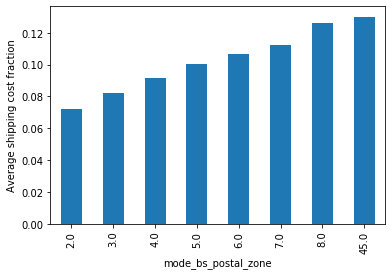

In [178]:
df_gb.groupby('mode_bs_postal_zone')['macro_avg_shipping_cost_fraction'].mean().plot(kind='bar');
plt.ylabel('Average shipping cost fraction');

## Do costs follow expected distributions?

Brands from CA

In [179]:
df_ohe = pd.get_dummies(df_gb['retailer_location'], prefix='retailer_location')
df_gb = pd.concat([df_gb, df_ohe], axis=1)

In [180]:
df_gb.head()

,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,brand_location,...,macro_avg_return_rate,smoothed_return_rate,retailer_location_Middle Atlantic,retailer_location_New England,retailer_location_Northeast Midwest,retailer_location_Northwest Midwest,retailer_location_Pacific West,retailer_location_South Atlantic,retailer_location_South East,retailer_location_South West
0,396,CA,0.000257,0.000000,1.939162,0.15,0.974359,0.000000,0.025641,New England,...,0.105610,0.105933,0,0,0,0,1,0,0,0
1,7748,CA,0.000460,0.000000,1.772928,0.15,0.748544,0.152427,0.075728,Pacific West,...,0.139383,0.139288,0,0,0,0,1,0,0,0
2,8907,CA,0.000100,0.860759,8.010137,0.18,0.000000,0.000000,1.000000,Pacific West,...,0.184603,0.181405,0,0,0,0,1,0,0,0
3,7749,CA,0.000196,0.000000,1.450634,0.15,0.696667,0.193333,0.096667,Pacific West,...,0.217369,0.216080,0,0,0,0,1,0,0,0
4,9343,CA,0.000031,0.458333,1.427283,0.18,0.125000,0.000000,0.875000,South West,...,0.073412,0.077121,0,0,0,0,1,0,0,0


In [181]:
df_gb.head()

,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,brand_location,...,macro_avg_return_rate,smoothed_return_rate,retailer_location_Middle Atlantic,retailer_location_New England,retailer_location_Northeast Midwest,retailer_location_Northwest Midwest,retailer_location_Pacific West,retailer_location_South Atlantic,retailer_location_South East,retailer_location_South West
0,396,CA,0.000257,0.000000,1.939162,0.15,0.974359,0.000000,0.025641,New England,...,0.105610,0.105933,0,0,0,0,1,0,0,0
1,7748,CA,0.000460,0.000000,1.772928,0.15,0.748544,0.152427,0.075728,Pacific West,...,0.139383,0.139288,0,0,0,0,1,0,0,0
2,8907,CA,0.000100,0.860759,8.010137,0.18,0.000000,0.000000,1.000000,Pacific West,...,0.184603,0.181405,0,0,0,0,1,0,0,0
3,7749,CA,0.000196,0.000000,1.450634,0.15,0.696667,0.193333,0.096667,Pacific West,...,0.217369,0.216080,0,0,0,0,1,0,0,0
4,9343,CA,0.000031,0.458333,1.427283,0.18,0.125000,0.000000,0.875000,South West,...,0.073412,0.077121,0,0,0,0,1,0,0,0


In [182]:
df_gb.columns

Index(['brand_id', 'retailer_state', 'historical_gmv_fraction',
       'brand_pct_swf', 'avg_weight_of_products', 'first_order_commission',
       'brand_pct_fedex', 'brand_pct_ups', 'brand_pct_usps', 'brand_location',
       'brand_state', 'brand_location_Canada',
       'brand_location_Middle Atlantic', 'brand_location_New England',
       'brand_location_Northeast Midwest', 'brand_location_Northwest Midwest',
       'brand_location_Pacific West', 'brand_location_South Atlantic',
       'brand_location_South East', 'brand_location_South West',
       'brand_location_Unknown', 'number_of_stockists_1001-2000',
       'number_of_stockists_2001-10000', 'number_of_stockists_251-1000',
       'number_of_stockists_51-250', 'number_of_stockists_<=50',
       'primary_brand_category', 'primary_brand_category_Accessories',
       'primary_brand_category_Beauty', 'primary_brand_category_Home Decor',
       'primary_brand_category_Jewelry', 'primary_brand_category_Kids',
       'primary_brand_ca

In [183]:
df_gb.shape[0]

258315

In [184]:
df_gb = df_gb.loc[df_gb['brand_location']!='Canada', :]

In [185]:
df_gb.shape[0]

258315

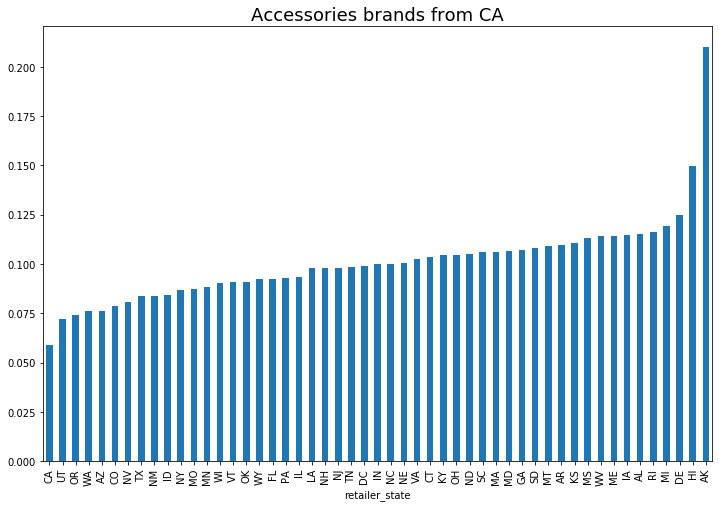

In [186]:
b_state = 'CA'
b_cat = 'Accessories'

plt.figure(figsize=(12, 8));
df_gb.loc[(df_gb['brand_state']==b_state)
           & (df_gb['primary_brand_category']==b_cat)
           , :].groupby('retailer_state')['macro_avg_shipping_cost_fraction'].mean(
).sort_values().plot(kind='bar');

plt.title(b_cat + ' brands from '+b_state, fontsize=18);

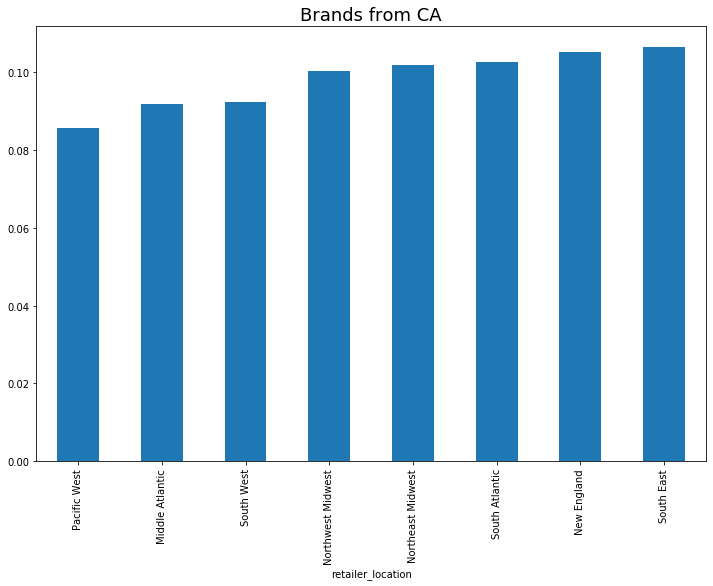

In [187]:
b_state = 'CA'
b_cat = 'Accessories'

plt.figure(figsize=(12, 8));
df_gb.loc[(df_gb['brand_state']==b_state)
           & (df_gb['primary_brand_category']==b_cat)
           , :].groupby('retailer_location')['macro_avg_shipping_cost_fraction'].mean(
).sort_values().plot(kind='bar');

plt.title('Brands from '+b_state, fontsize=18);

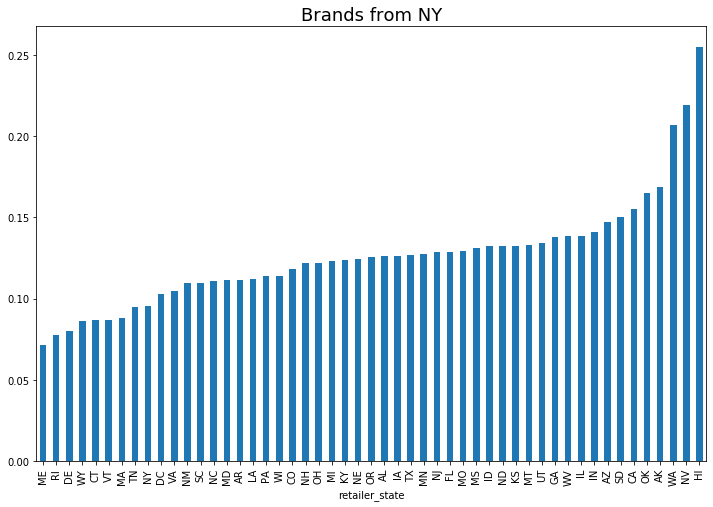

In [188]:
b_state = 'NY'
b_cat = 'Home Decor'

plt.figure(figsize=(12, 8));
df_gb.loc[(df_gb['brand_state']==b_state)
           & (df_gb['primary_brand_category']==b_cat)
           , :].groupby('retailer_state')['macro_avg_shipping_cost_fraction'].mean(
).sort_values().plot(kind='bar');

plt.title('Brands from '+b_state, fontsize=18);

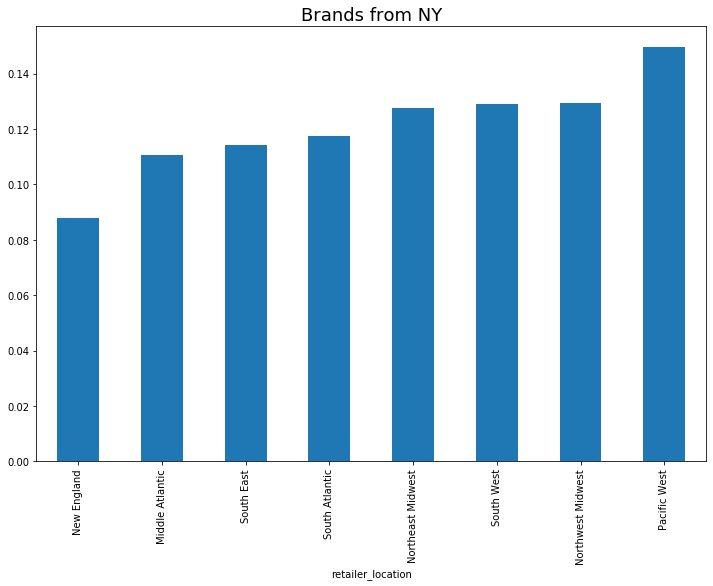

In [189]:
b_state = 'NY'
b_cat = 'Home Decor'

plt.figure(figsize=(12, 8));
df_gb.loc[(df_gb['brand_state']==b_state)
           & (df_gb['primary_brand_category']==b_cat)
           , :].groupby('retailer_location')['macro_avg_shipping_cost_fraction'].mean(
).sort_values().plot(kind='bar');

plt.title('Brands from '+b_state, fontsize=18);

In [190]:
df_gb['mode_bs_postal_zone'].isna().sum() / df_gb.shape[0]

0.0

In [191]:
df_gb = df_gb.loc[df_gb['mode_bs_postal_zone'].notna(), :]

In [192]:
df_gb['mode_bs_postal_zone'] = df_gb['mode_bs_postal_zone'].astype(int)

In [193]:
df_ohe = pd.get_dummies(df_gb['mode_bs_postal_zone'], prefix='postal_zone')
df_gb = pd.concat([df_gb, df_ohe], axis=1)

In [194]:
df_gb.head()

,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,brand_location,...,retailer_location_South East,retailer_location_South West,postal_zone_2,postal_zone_3,postal_zone_4,postal_zone_5,postal_zone_6,postal_zone_7,postal_zone_8,postal_zone_45
0,396,CA,0.000257,0.000000,1.939162,0.15,0.974359,0.000000,0.025641,New England,...,0,0,0,0,0,0,0,0,1,0
1,7748,CA,0.000460,0.000000,1.772928,0.15,0.748544,0.152427,0.075728,Pacific West,...,0,0,0,0,0,0,0,1,0,0
2,8907,CA,0.000100,0.860759,8.010137,0.18,0.000000,0.000000,1.000000,Pacific West,...,0,0,0,1,0,0,0,0,0,0
3,7749,CA,0.000196,0.000000,1.450634,0.15,0.696667,0.193333,0.096667,Pacific West,...,0,0,0,0,0,0,0,1,0,0
4,9343,CA,0.000031,0.458333,1.427283,0.18,0.125000,0.000000,0.875000,South West,...,0,0,0,0,0,0,0,1,0,0


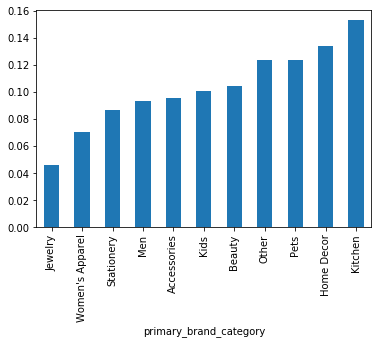

In [195]:
df_gb.groupby('primary_brand_category')['macro_avg_shipping_cost_fraction'].mean().sort_values().plot(kind='bar')

## Declare columns to use

In [196]:
df_gb.columns.tolist()

['brand_id',
 'retailer_state',
 'historical_gmv_fraction',
 'brand_pct_swf',
 'avg_weight_of_products',
 'first_order_commission',
 'brand_pct_fedex',
 'brand_pct_ups',
 'brand_pct_usps',
 'brand_location',
 'brand_state',
 'brand_location_Canada',
 'brand_location_Middle Atlantic',
 'brand_location_New England',
 'brand_location_Northeast Midwest',
 'brand_location_Northwest Midwest',
 'brand_location_Pacific West',
 'brand_location_South Atlantic',
 'brand_location_South East',
 'brand_location_South West',
 'brand_location_Unknown',
 'number_of_stockists_1001-2000',
 'number_of_stockists_2001-10000',
 'number_of_stockists_251-1000',
 'number_of_stockists_51-250',
 'number_of_stockists_<=50',
 'primary_brand_category',
 'primary_brand_category_Accessories',
 'primary_brand_category_Beauty',
 'primary_brand_category_Home Decor',
 'primary_brand_category_Jewelry',
 'primary_brand_category_Kids',
 'primary_brand_category_Kitchen',
 'primary_brand_category_Men',
 'primary_brand_category

#### MVP list of columns

In [197]:
cols_to_use = [
#     'mode_bs_postal_zone',
    'is_AK',
    'is_HI',
    'same_state',
    'avg_weight_of_products', 
    'same_location',
    'postal_zone_2',
    'postal_zone_3',
    'postal_zone_4',
    'postal_zone_5',
    'postal_zone_6',
    'postal_zone_7',
    'postal_zone_8',
    'postal_zone_45',
    'mean_b_brand_age_New',
    'brand_location_Canada',
    'brand_location_Middle Atlantic',
    'brand_location_New England',
    'brand_location_Northeast Midwest',
    'brand_location_Northwest Midwest',
    'brand_location_Pacific West',
    'brand_location_South Atlantic',
    'brand_location_South East',
    'brand_location_South West',
    'brand_location_Unknown',
    'number_of_stockists_1001-2000',
    'number_of_stockists_2001-10000',
    'number_of_stockists_251-1000',
    'number_of_stockists_51-250',
#     'number_of_stockists_<=50',
    'primary_brand_category_Accessories',
    'primary_brand_category_Beauty',
    'primary_brand_category_Home Decor',
    'primary_brand_category_Jewelry',
    'primary_brand_category_Kids',
    'primary_brand_category_Kitchen',
    'primary_brand_category_Men',
    'primary_brand_category_Other',
    'primary_brand_category_Pets',
    'primary_brand_category_Stationery',
    "primary_brand_category_Women's Apparel",
    "macro_avg_extra_shipping_cost_fraction",
    'mean_s_retailer_address_type_RESIDENTIAL',
#     "macro_avg_shipping_cost_fraction",
    'brand_pct_swf',
    'brand_pct_fedex',
    'brand_pct_ups',
    'brand_pct_usps',
#     'brands_historical_shipping_cost_fraction_from_mean'
]

## Regress on mean brand,state CM or shipping_cost_fraction

In [198]:
# target = 'macro_avg_shipping_cost_fraction'
target = 'target_shipping_cost_fraction'
# target = 'cm_per_order_excluding_insider_fees'

In [199]:
# SKLEARN stuff
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [200]:
# [x for x in df_gb.columns.tolist() if x!=target]

In [201]:
df_gb[cols_to_use].isna().sum()

is_AK                                            0
is_HI                                            0
same_state                                       0
avg_weight_of_products                           0
same_location                                    0
postal_zone_2                                    0
postal_zone_3                                    0
postal_zone_4                                    0
postal_zone_5                                    0
postal_zone_6                                    0
postal_zone_7                                    0
postal_zone_8                                    0
postal_zone_45                                   0
mean_b_brand_age_New                             0
brand_location_Canada                            0
brand_location_Middle Atlantic                   0
brand_location_New England                       0
brand_location_Northeast Midwest                 0
brand_location_Northwest Midwest                 0
brand_location_Pacific West    

## Impute some features with specific strategies:

In [202]:
df_gb['macro_avg_extra_shipping_cost_fraction'] = df_gb['macro_avg_extra_shipping_cost_fraction'].fillna(0)

In [203]:
df_gb['brand_pct_swf'] = df_gb['brand_pct_swf'].fillna(0.43)

In [204]:
df_gb['brand_pct_fedex'] = df_gb['brand_pct_fedex'].fillna(0.33)
df_gb['brand_pct_ups'] = df_gb['brand_pct_ups'].fillna(0.33)
df_gb['brand_pct_usps'] = df_gb['brand_pct_usps'].fillna(0.33)

## Create X_train, X_test and X_future

Remember df_gb is built using only static features and non-future data

In [205]:
# df_with_labels = df_gb.loc[df_gb[target]>0, :]

In [206]:
df_gb_future = df_gb.copy()

### Now just replace the label column and the predictions 
#### predictions are the same unless now training on full 'past' data

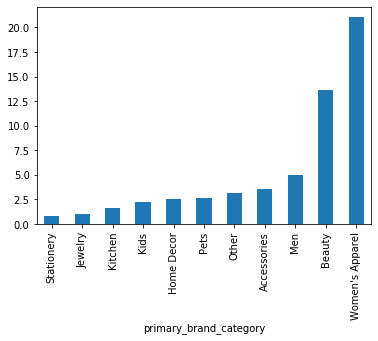

In [207]:
df_future.groupby('primary_brand_category')['avg_weight_of_products'].mean().sort_values().plot(kind='bar')

Remove the previous target columns:

In [208]:
print(brand_state_gb_sum_features)

['total_shipping_cost_dollars', 'net_faire_shipping_cost_dollars', 'coalesced_shipping_cost_dollars', 'gmv']


In [209]:
for c in brand_state_gb_sum_features:
    for cf in df_gb_future.columns.tolist():
        if c in cf:
            print(cf)

sum_bs_total_shipping_cost_dollars
sum_bs_net_faire_shipping_cost_dollars
sum_bs_coalesced_shipping_cost_dollars
historical_gmv_fraction
sum_b_gmv
sum_b_returned_gmv_dollars
sum_b_swf_gmv
sum_b_swf_returned_gmv_dollars
sum_b_rr_cured_gmv
sum_b_rr_cured_returned_gmv_dollars
sum_bs_gmv


In [210]:
df_gb_future.drop(columns = ['sum_bs_total_shipping_cost_dollars',
                             'sum_bs_net_faire_shipping_cost_dollars',
                             'sum_bs_coalesced_shipping_cost_dollars',
                             'sum_b_gmv',
                             'sum_bs_gmv',
                            ], inplace = True)

In [211]:
for f in brand_state_gb_sum_features:
    print(f)
    df_gb_future = add_to_df_gb(df_gb_future,
                         df_future,
                         f, 
                         gb_cols = ['brand_id', 'retailer_state'],
                         aggtypes=['sum'],
                         prefix='bs'
                        )

total_shipping_cost_dollars
net_faire_shipping_cost_dollars
coalesced_shipping_cost_dollars
gmv


In [212]:
df_gb_future.head()

,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,brand_location,...,postal_zone_4,postal_zone_5,postal_zone_6,postal_zone_7,postal_zone_8,postal_zone_45,sum_bs_total_shipping_cost_dollars,sum_bs_net_faire_shipping_cost_dollars,sum_bs_coalesced_shipping_cost_dollars,sum_bs_gmv
0,396,CA,0.000257,0.000000,1.939162,0.15,0.974359,0.000000,0.025641,New England,...,0,0,0,0,1,0,495.67,124.17,495.6700,2822.00
1,7748,CA,0.000460,0.000000,1.772928,0.15,0.748544,0.152427,0.075728,Pacific West,...,0,0,0,1,0,0,1917.79,1064.17,1917.7900,16465.43
2,8907,CA,0.000100,0.860759,8.010137,0.18,0.000000,0.000000,1.000000,Pacific West,...,0,0,0,0,0,0,123.75,67.75,123.7500,1649.00
3,7749,CA,0.000196,0.000000,1.450634,0.15,0.696667,0.193333,0.096667,Pacific West,...,0,0,0,1,0,0,399.38,206.54,399.3800,3772.00
4,9343,CA,0.000031,0.458333,1.427283,0.18,0.125000,0.000000,0.875000,South West,...,0,0,0,1,0,0,NaN,NaN,NaN,NaN


#### Create the macro_averaged features now that the brand_state group by sums have been performed

In [213]:
df_gb_future['macro_avg_extra_shipping_cost_fraction'] = df_gb_future['sum_b_swf_maker_paid_shipping_dollars'].astype(float) / df_gb_future['sum_b_swf_gmv']

df_gb_future['macro_avg_shipping_cost_fraction'] = df_gb_future['sum_bs_total_shipping_cost_dollars'].astype(float) / df_gb_future['sum_bs_gmv']
df_gb_future['target_shipping_cost_fraction'] = df_gb_future['sum_bs_coalesced_shipping_cost_dollars'].astype(float) / df_gb_future['sum_bs_gmv']

In [214]:
df_gb_future['macro_avg_net_faire_shipping_cost_fraction'] = \
df_gb_future['sum_bs_net_faire_shipping_cost_dollars'].astype(float) / df_gb_future['sum_bs_gmv']

In [215]:
df_gb_future['macro_avg_extra_shipping_cost_fraction'] = df_gb_future['macro_avg_extra_shipping_cost_fraction'].fillna(0)

#### Option to target future shipping cost

In [216]:
print(target)

target_shipping_cost_fraction


In [217]:
# df_gb_future.columns.tolist()

In [218]:
if target_future_scf == True:
    df_gb['past_'+target] = df_gb[target]
    df_gb.drop(columns=[target], inplace=True)
    df_gb = df_gb.merge(df_gb_future[['brand_id', 'retailer_state', target]], 
                        on=['brand_id', 'retailer_state']
                       )
    
    cols_to_use = cols_to_use + ['past_'+target]

In [219]:
df_temp = df_gb[['primary_brand_category', 'past_'+target]].groupby(
    'primary_brand_category'
)['past_'+target].mean().reset_index()

In [220]:
df_temp.loc[df_temp['primary_brand_category']=='Beauty', 'past_target_shipping_cost_fraction'].values[0]

0.10409824498686612

Impute the mean of the category

In [221]:
for c in df_temp['primary_brand_category'].unique().tolist():
    df_gb.loc[(df_gb['primary_brand_category']==c), 'past_'+target] = \
    df_gb.loc[(df_gb['primary_brand_category']==c), 'past_'+target].fillna(
        df_temp.loc[df_temp['primary_brand_category']==c, 'past_'+target].values[0]
    )

In [222]:
df_with_labels = df_gb.loc[df_gb[target]>0, :]

In [223]:
print(target)

target_shipping_cost_fraction


In [224]:
df_gb_future = df_gb_future.loc[df_gb_future[target].notna(), :]

In [225]:
df_gb_future[target].isna().sum()

0

In [226]:
df_gb_future[target].notna().sum()

57623

In [227]:
df_with_labels['mode_bs_postal_zone'].value_counts()

5     13662
8     11213
4      8551
6      7595
7      7506
3      3881
2      3821
45     1166
Name: mode_bs_postal_zone, dtype: int64

In [228]:
df_gb_future['mode_bs_postal_zone'].value_counts()

5     13702
8     11240
4      8579
6      7625
7      7528
3      3894
2      3887
45     1168
Name: mode_bs_postal_zone, dtype: int64

In [229]:
y_future = df_gb_future[target]

## Simple split on brand, retailer_state 
### eventually don't do it once split is in time axis

In [230]:
split_size = 0.15

df_train, df_test, y_train, y_test = \
train_test_split(df_with_labels[[x for x in df_with_labels.columns.tolist() if x!=target]],
                 df_with_labels[target],
                 test_size=split_size
                )

In [231]:
df_train.shape

(48785, 86)

In [232]:
df_test.shape

(8610, 86)

In [233]:
X_train = df_train[cols_to_use]
X_test = df_test[cols_to_use]

In [234]:
df_gb.shape

(258315, 87)

In [235]:
# df_train.corr()['macro_avg_shipping_cost_fraction'].sort_values()

## LinearRegression

In [236]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [237]:
std_scaling = StandardScaler() 
# algo = LinearRegression()
algo = Ridge()

steps = [
#             ('std_scaling', StandardScaler()), 
            ('algo', algo)
        ]
pipeline = Pipeline(steps)

parameters = {
                'algo__normalize': [False]
#               'algo__class_weight': ['balanced', None],
#               'algo__n_estimators': [50,100],
#               'algo__max_depth': [4, 6,8],
#               'algo__gamma': [0.1, 0.2],
#               'algo__learning_rate': [0.1, 0.5]
             }

cv1 = RepeatedKFold(n_splits=5, n_repeats=2)
xgb_gsv = GridSearchCV(pipeline, cv = cv1
                   , param_grid = parameters
#                    , scoring = 'neg_mean_squared_error'
                   , scoring = 'r2'
#                    , scoring = 'explained_variance'
#                    , scoring  = 'neg_mean_absolute_error'
#                    , scoring  = 'neg_mean_squared_log_error'
                   , n_jobs=-1, return_train_score=False)


In [238]:
print(cols_to_use)

['is_AK', 'is_HI', 'same_state', 'avg_weight_of_products', 'same_location', 'postal_zone_2', 'postal_zone_3', 'postal_zone_4', 'postal_zone_5', 'postal_zone_6', 'postal_zone_7', 'postal_zone_8', 'postal_zone_45', 'mean_b_brand_age_New', 'brand_location_Canada', 'brand_location_Middle Atlantic', 'brand_location_New England', 'brand_location_Northeast Midwest', 'brand_location_Northwest Midwest', 'brand_location_Pacific West', 'brand_location_South Atlantic', 'brand_location_South East', 'brand_location_South West', 'brand_location_Unknown', 'number_of_stockists_1001-2000', 'number_of_stockists_2001-10000', 'number_of_stockists_251-1000', 'number_of_stockists_51-250', 'primary_brand_category_Accessories', 'primary_brand_category_Beauty', 'primary_brand_category_Home Decor', 'primary_brand_category_Jewelry', 'primary_brand_category_Kids', 'primary_brand_category_Kitchen', 'primary_brand_category_Men', 'primary_brand_category_Other', 'primary_brand_category_Pets', 'primary_brand_category_S

In [239]:
X_train.isna().sum()

is_AK                                       0
is_HI                                       0
same_state                                  0
avg_weight_of_products                      0
same_location                               0
postal_zone_2                               0
postal_zone_3                               0
postal_zone_4                               0
postal_zone_5                               0
postal_zone_6                               0
postal_zone_7                               0
postal_zone_8                               0
postal_zone_45                              0
mean_b_brand_age_New                        0
brand_location_Canada                       0
brand_location_Middle Atlantic              0
brand_location_New England                  0
brand_location_Northeast Midwest            0
brand_location_Northwest Midwest            0
brand_location_Pacific West                 0
brand_location_South Atlantic               0
brand_location_South East         

In [240]:
# Fit grid search
xgb_model_list = xgb_gsv.fit(X_train, y_train)

In [241]:
best_model = xgb_model_list.best_estimator_

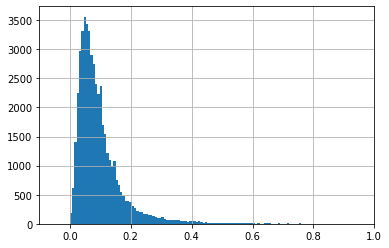

In [242]:
y_train.hist(bins=200)
plt.xlim(-0.1, 1);

In [243]:
X_train.mean()

is_AK                                       0.011028
is_HI                                       0.009142
same_state                                  0.045793
avg_weight_of_products                      4.629646
same_location                               0.186697
postal_zone_2                               0.065778
postal_zone_3                               0.068279
postal_zone_4                               0.148570
postal_zone_5                               0.239910
postal_zone_6                               0.132049
postal_zone_7                               0.131044
postal_zone_8                               0.193912
postal_zone_45                              0.020457
mean_b_brand_age_New                        0.413175
brand_location_Canada                       0.000000
brand_location_Middle Atlantic              0.117741
brand_location_New England                  0.056882
brand_location_Northeast Midwest            0.101507
brand_location_Northwest Midwest            0.

In [244]:
# The coefficients
print('Coefficients: \n', best_model.get_params()['steps'][0][1].coef_)

Coefficients: 
 [ 6.48646409e-02  3.87542946e-02  1.70204457e-04  6.38592414e-05
 -2.55937258e-03 -1.09959269e-02 -7.32883669e-03 -4.55499671e-03
 -1.75882801e-03  2.48656619e-03  5.92772353e-03  8.17944541e-03
  8.04485317e-03  1.20950017e-02  0.00000000e+00 -3.45515205e-03
  1.87727630e-03 -4.68848063e-03 -3.54001591e-03 -4.59464121e-03
 -1.85540791e-03  3.29658612e-03 -6.91877789e-03  1.98786132e-02
  4.91884480e-03  6.04843104e-03 -5.26183671e-03  5.61970497e-05
 -2.57317564e-03 -8.39540919e-04  6.40280845e-03 -1.66932936e-02
  3.75653882e-03  1.92129313e-02  6.03910268e-03  2.59490237e-03
 -5.55768827e-03 -4.56022647e-03 -7.78235873e-03  3.37375425e-01
  7.44482729e-03 -2.24325732e-02 -3.27399095e-02 -3.67356606e-02
 -3.84112264e-02  5.69511198e-01]


In [245]:
y_test_pred = best_model.predict(X_test[cols_to_use])

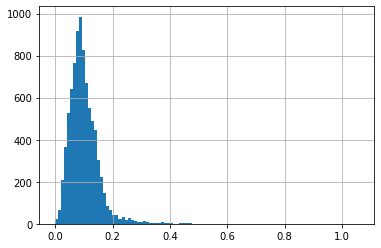

In [246]:
pd.Series(y_test_pred).hist(bins=100)

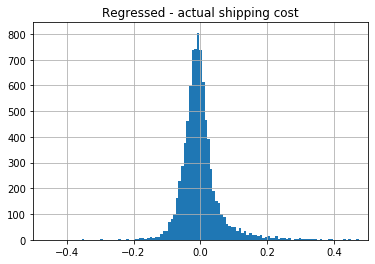

In [247]:
(y_test - y_test_pred).hist(bins=250)
plt.title('Regressed - actual shipping cost');
plt.xlim(-0.5, 0.5);

In [248]:
r2_score(y_test, y_test_pred)

0.31316782463590254

In [249]:
if target_future_scf:
    df_gb_future = df_gb_future.merge(df_gb[['brand_id', 'retailer_state', 'past_'+target]],
                                      on=['brand_id', 'retailer_state']
                                     )

In [250]:
y_future_pred = best_model.predict(df_gb_future[cols_to_use])

0.3346033924048152

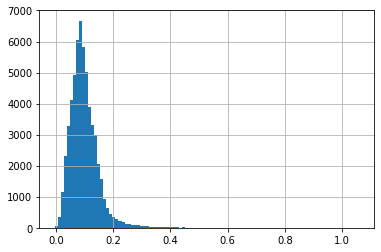

In [251]:
pd.Series(y_future_pred).hist(bins=100)
r2_score(y_future, y_future_pred)

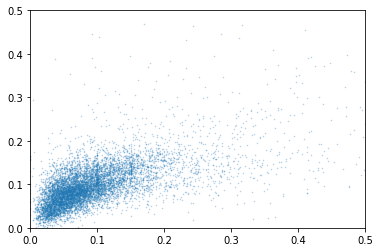

In [252]:
plt.scatter(y_test, y_test_pred, s=0.3, alpha=0.3)
plt.xlim(0,0.5);
plt.ylim(0,0.5);
# plt.xlim(-2000,1000)
# plt.ylim(-2000,1000)

In [253]:
if not target_future_scf:
    plt.scatter(y_future, y_future_pred, s=0.3, alpha=0.3)
    plt.xlim(0,0.5);
    plt.ylim(0,0.5);

### Fraction beyond 20% off

In [254]:
100.0*(abs(y_test_pred - y_test)/y_test_pred > 0.2).sum()/y_test_pred.shape[0]

66.80603948896632

### Fraction beyond 50% off

In [255]:
100.0*(abs(y_test_pred - y_test)/y_test_pred > 0.5).sum()/y_test_pred.shape[0]

27.874564459930312

### Fraction beyond 80% off

In [256]:
100.0*(abs(y_test_pred - y_test)/y_test_pred > 0.8).sum()/y_test_pred.shape[0]

9.32636469221835

In [257]:
df_test.head()

,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,brand_location,...,retailer_location_South West,postal_zone_2,postal_zone_3,postal_zone_4,postal_zone_5,postal_zone_6,postal_zone_7,postal_zone_8,postal_zone_45,past_target_shipping_cost_fraction
3020,32685,CA,0.000011,0.977011,1.769585,0.25,0.678161,0.206897,0.103448,South Atlantic,...,0,0,0,0,0,0,0,1,0,0.056649
26427,4401,NY,0.000043,0.000000,1.433059,0.25,0.000000,0.957265,0.034188,Pacific West,...,0,0,0,0,0,0,0,1,0,0.141948
13181,45360,WA,0.000004,0.988764,1.214923,0.25,0.146067,0.662921,0.191011,Pacific West,...,0,0,0,1,0,0,0,0,0,0.050372
155892,20601,NC,0.000000,0.500000,15.429070,0.25,0.000000,0.000000,1.000000,Pacific West,...,0,0,0,0,0,0,0,1,0,0.104098
127220,11687,KS,0.000002,0.010101,1.905657,0.25,0.000000,0.949495,0.010101,South East,...,0,0,0,0,1,0,0,0,0,0.326390


In [258]:
y_test[:5]

3020      0.035802
26427     0.127194
13181     0.036842
155892    0.156250
127220    0.224516
Name: target_shipping_cost_fraction, dtype: float64

In [259]:
df_val = pd.concat([df_test, y_test], axis=1)

In [260]:
df_val_future = pd.concat([df_gb_future.reset_index(), pd.Series(y_future_pred, name='prediction')], axis=1)

In [261]:
df_val.head()

,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,brand_location,...,postal_zone_2,postal_zone_3,postal_zone_4,postal_zone_5,postal_zone_6,postal_zone_7,postal_zone_8,postal_zone_45,past_target_shipping_cost_fraction,target_shipping_cost_fraction
3020,32685,CA,0.000011,0.977011,1.769585,0.25,0.678161,0.206897,0.103448,South Atlantic,...,0,0,0,0,0,0,1,0,0.056649,0.035802
26427,4401,NY,0.000043,0.000000,1.433059,0.25,0.000000,0.957265,0.034188,Pacific West,...,0,0,0,0,0,0,1,0,0.141948,0.127194
13181,45360,WA,0.000004,0.988764,1.214923,0.25,0.146067,0.662921,0.191011,Pacific West,...,0,0,1,0,0,0,0,0,0.050372,0.036842
155892,20601,NC,0.000000,0.500000,15.429070,0.25,0.000000,0.000000,1.000000,Pacific West,...,0,0,0,0,0,0,1,0,0.104098,0.156250
127220,11687,KS,0.000002,0.010101,1.905657,0.25,0.000000,0.949495,0.010101,South East,...,0,0,0,1,0,0,0,0,0.326390,0.224516


In [262]:
df_val_future.head()

,index,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,...,postal_zone_6,postal_zone_7,postal_zone_8,postal_zone_45,sum_bs_total_shipping_cost_dollars,sum_bs_net_faire_shipping_cost_dollars,sum_bs_coalesced_shipping_cost_dollars,sum_bs_gmv,past_target_shipping_cost_fraction,prediction
0,0,396,CA,0.000257,0.000000,1.939162,0.15,0.974359,0.000000,0.025641,...,0,0,1,0,495.67,124.17,495.6700,2822.00,0.165577,0.153399
1,1,7748,CA,0.000460,0.000000,1.772928,0.15,0.748544,0.152427,0.075728,...,0,1,0,0,1917.79,1064.17,1917.7900,16465.43,0.115137,0.137342
2,2,8907,CA,0.000100,0.860759,8.010137,0.18,0.000000,0.000000,1.000000,...,0,0,0,0,123.75,67.75,123.7500,1649.00,0.046201,0.035854
3,3,7749,CA,0.000196,0.000000,1.450634,0.15,0.696667,0.193333,0.096667,...,0,1,0,0,399.38,206.54,399.3800,3772.00,0.102973,0.129720
4,4,8597,CA,0.000048,0.866667,12.367303,0.18,0.644444,0.133333,0.222222,...,0,0,0,0,44.22,21.52,44.2200,1498.94,0.043408,0.033888


In [263]:
df_val = pd.concat([df_val.reset_index(), pd.Series(y_test_pred)], axis=1)

In [264]:
df_val.columns = df_val.columns.tolist()[:-1] + ['prediction']

In [265]:
df_val.groupby('primary_brand_category')['prediction'].mean()

primary_brand_category
Accessories        0.092669
Beauty             0.095379
Home Decor         0.120044
Jewelry            0.042685
Kids               0.103358
Kitchen            0.146626
Men                0.092962
Other              0.119185
Pets               0.111260
Stationery         0.081077
Women's Apparel    0.069827
Name: prediction, dtype: float64

In [266]:
df_val.groupby('mode_bs_postal_zone')['prediction'].mean()

mode_bs_postal_zone
2     0.067534
3     0.079684
4     0.090905
5     0.094945
6     0.101757
7     0.105306
8     0.117948
45    0.113574
Name: prediction, dtype: float64

In [267]:
df_val.head()

,index,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,...,postal_zone_3,postal_zone_4,postal_zone_5,postal_zone_6,postal_zone_7,postal_zone_8,postal_zone_45,past_target_shipping_cost_fraction,target_shipping_cost_fraction,prediction
0,3020,32685,CA,0.000011,0.977011,1.769585,0.25,0.678161,0.206897,0.103448,...,0,0,0,0,0,1,0,0.056649,0.035802,0.069889
1,26427,4401,NY,0.000043,0.000000,1.433059,0.25,0.000000,0.957265,0.034188,...,0,0,0,0,0,1,0,0.141948,0.127194,0.127478
2,13181,45360,WA,0.000004,0.988764,1.214923,0.25,0.146067,0.662921,0.191011,...,0,1,0,0,0,0,0,0.050372,0.036842,0.070579
3,155892,20601,NC,0.000000,0.500000,15.429070,0.25,0.000000,0.000000,1.000000,...,0,0,0,0,0,1,0,0.104098,0.156250,0.102898
4,127220,11687,KS,0.000002,0.010101,1.905657,0.25,0.000000,0.949495,0.010101,...,0,0,1,0,0,0,0,0.326390,0.224516,0.240168


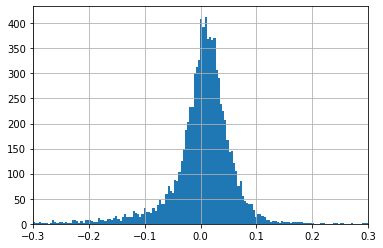

In [268]:
# df_temp = df_val.loc[df_val[target]>0, :]
df_temp = df_val

((df_temp.loc[df_temp[target] > 0, 'prediction'] \
  - df_temp.loc[df_temp[target] > 0, target]) \
#    / df_temp.loc[df_temp[target] > 0, target]
).hist(bins=500)

plt.xlim(-0.3, 0.3);

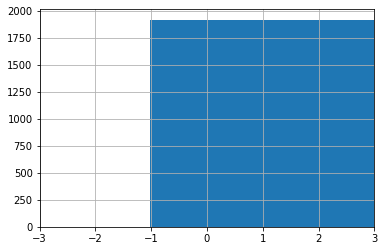

In [269]:
df_temp = df_val.loc[(df_val[target]>0)
                     & (df_val['num_brand_orders_to_state']>5)
                     ,
                     :]

((df_temp.loc[df_temp[target] > 0, 'prediction'] \
  - df_temp.loc[df_temp[target] > 0, target]) \
   / df_temp.loc[df_temp[target] > 0, target]
).hist(bins=200)

plt.xlim(-3, 3);

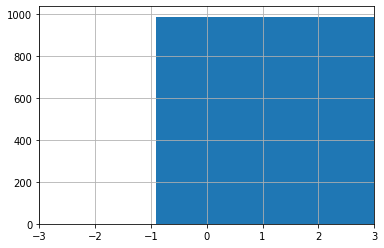

In [270]:
df_temp = df_val.loc[(df_val[target]>0)
                     & (df_val['num_brand_orders_to_state']>10)
                     ,
                     :]

((df_temp.loc[df_temp[target] > 0, 'prediction'] \
  - df_temp.loc[df_temp[target] > 0, target]) \
   / df_temp.loc[df_temp[target] > 0, target]
).hist(bins=200)

plt.xlim(-3, 3);

## Plot predicted shipping costs given brand state

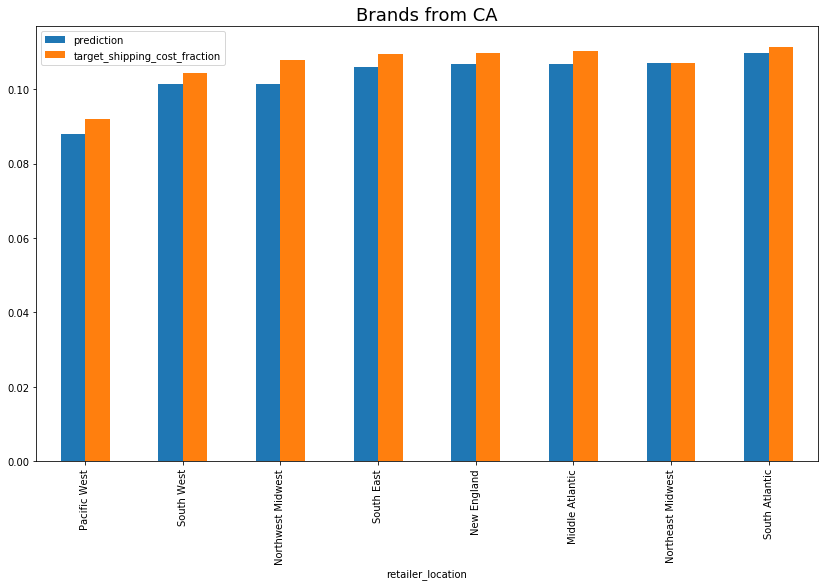

In [271]:
b_state = 'CA'
b_cat = 'Accessories'

fig, ax = plt.subplots(figsize=(14, 8));
df_val_future.loc[(df_val_future['brand_state']==b_state)
#            & (df_val_future['primary_brand_category']==b_cat)
           , :].groupby('retailer_location')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_state, fontsize=18);

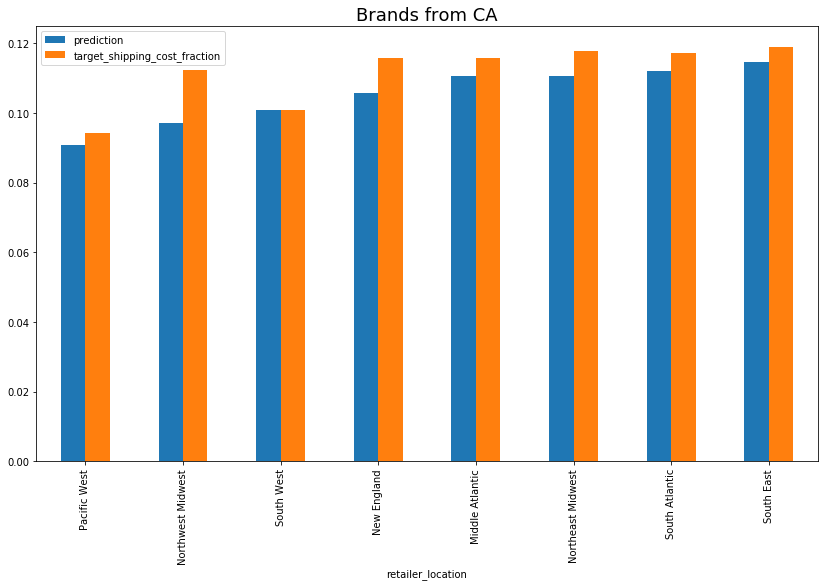

In [272]:
b_state = 'CA'
b_cat = 'Accessories'

fig, ax = plt.subplots(figsize=(14, 8));
df_val.loc[(df_val['brand_state']==b_state)
#            & (df_val['primary_brand_category']==b_cat)
           , :].groupby('retailer_location')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_state, fontsize=18);

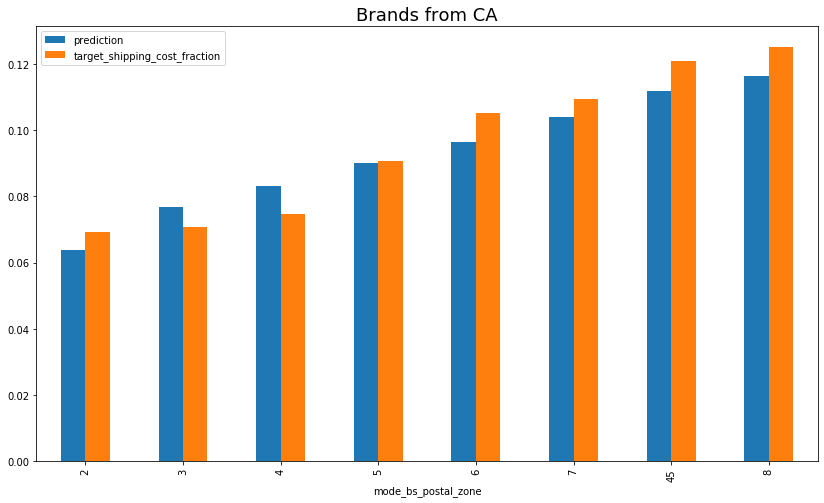

In [273]:
b_state = 'CA'
b_cat = 'Accessories'

fig, ax = plt.subplots(figsize=(14, 8));
df_val.loc[(df_val['brand_state']==b_state)
#            & (df_val['primary_brand_category']==b_cat)
           , :].groupby('mode_bs_postal_zone')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_state, fontsize=18);

In [274]:
# df_val.loc[df_val['brand_location']=='Northwest Midwest', 'brand_state'].value_counts()

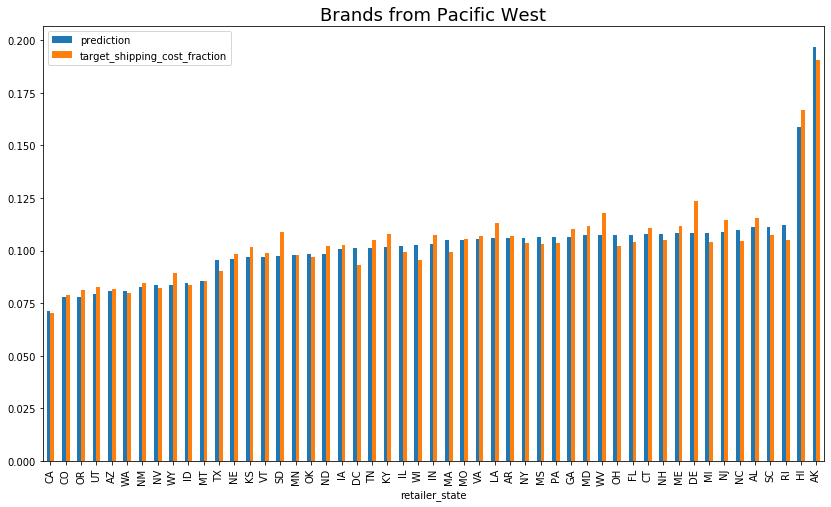

In [275]:
b_loc = 'Pacific West'
b_cat = 'Home Decor'

fig, ax = plt.subplots(figsize=(14, 8));
df_val_future.loc[(df_val_future['brand_location']==b_loc)
#            & (df_val_future['primary_brand_category']==b_cat)
#            & (df_val_future['num_brand_orders_to_state']>5)
           , :].groupby('retailer_state')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_loc, fontsize=18);

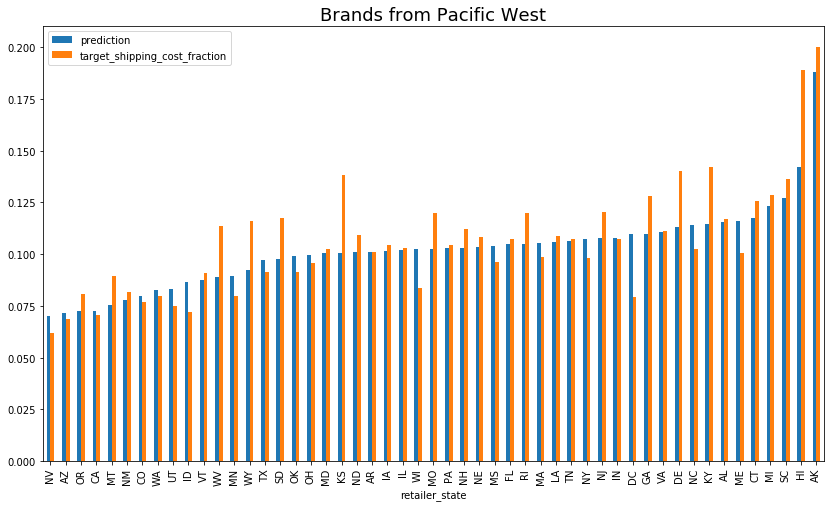

In [276]:
b_loc = 'Pacific West'
b_cat = 'Home Decor'

fig, ax = plt.subplots(figsize=(14, 8));
df_val.loc[(df_val['brand_location']==b_loc)
#            & (df_val['primary_brand_category']==b_cat)
#            & (df_val['num_brand_orders_to_state']>5)
           , :].groupby('retailer_state')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_loc, fontsize=18);

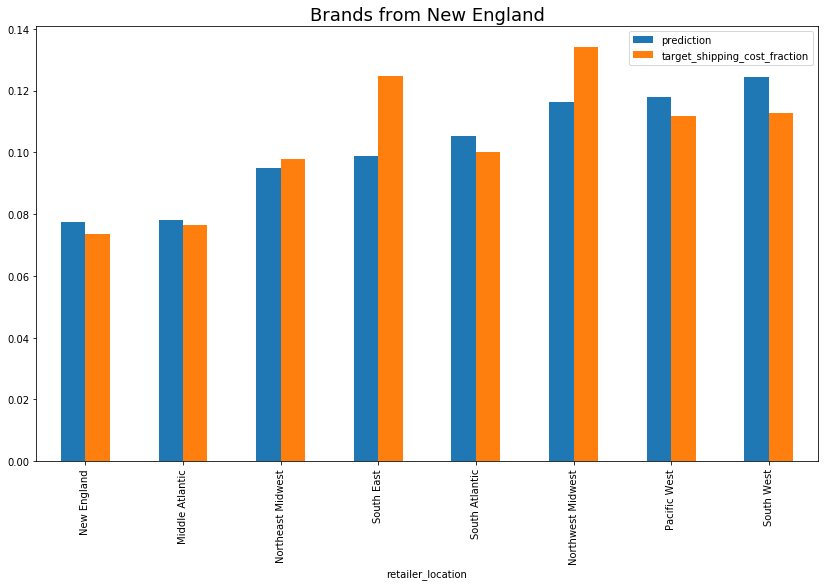

In [277]:
b_loc = 'New England'
b_cat = 'Accessories'

fig, ax = plt.subplots(figsize=(14, 8));
df_val.loc[(df_val['brand_location']==b_loc)
#            & (df_val['primary_brand_category']==b_cat)
           , :].groupby('retailer_location')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_loc, fontsize=18);

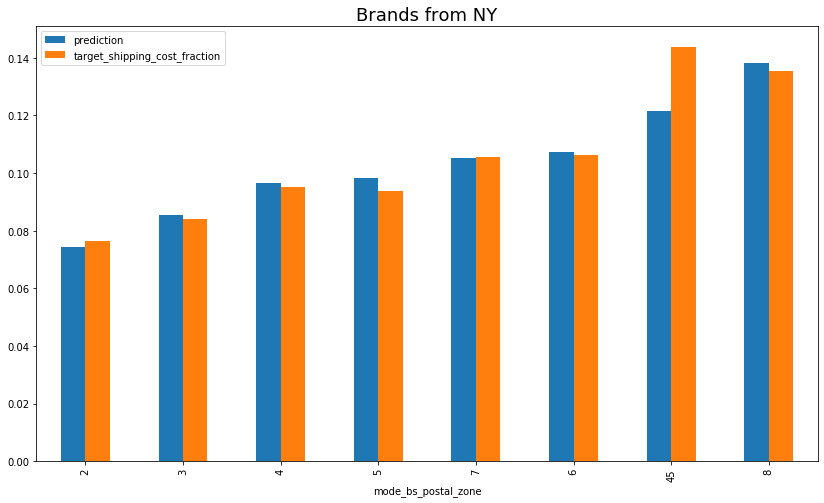

In [278]:
b_state = 'NY'
b_cat = 'Accessories'

fig, ax = plt.subplots(figsize=(14, 8));
df_val.loc[(df_val['brand_state']==b_state)
#            & (df_val['primary_brand_category']==b_cat)
           , :].groupby('mode_bs_postal_zone')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_state, fontsize=18);

In [279]:
# df_val.loc[df_val['brand_location']=='Northwest Midwest', 'brand_state'].value_counts()

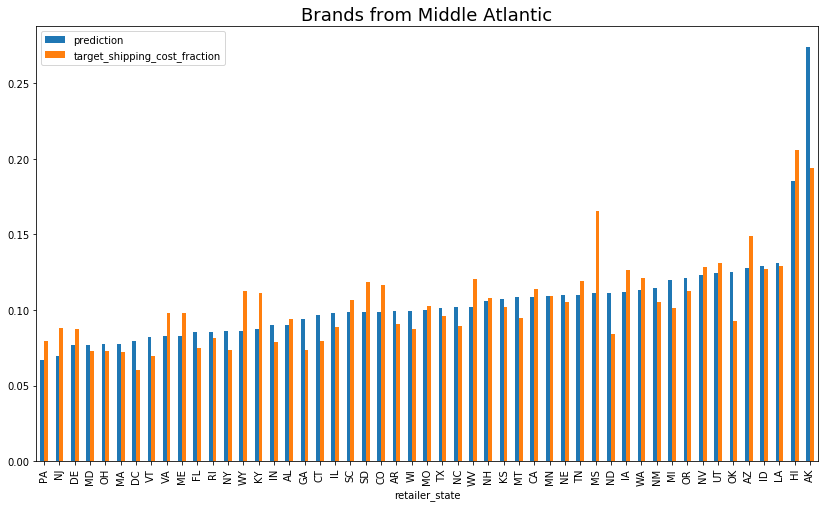

In [280]:
b_loc = 'Middle Atlantic'
b_cat = 'Home Decor'

fig, ax = plt.subplots(figsize=(14, 8));
df_val.loc[(df_val['brand_location']==b_loc)
#            & (df_val['primary_brand_category']==b_cat)
#            & (df_val['num_brand_orders_to_state']>5)
           , :].groupby('retailer_state')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_loc, fontsize=18);

# RandomForest Regressor

In [281]:
from sklearn.ensemble import RandomForestRegressor

In [282]:
std_scaling = StandardScaler() 
algo = RandomForestRegressor()

steps = [
#             ('std_scaling', StandardScaler()), 
            ('algo', RandomForestRegressor())
        ]
pipeline = Pipeline(steps)

parameters = {
#               'algo__class_weight': ['balanced', None],
              'algo__n_estimators': [250],
              'algo__max_depth': [25],
#               'algo__gamma': [0.1, 0.2],
#               'algo__learning_rate': [0.1, 0.5]
             }

cv1 = RepeatedKFold(n_splits=5, n_repeats=2)
rf_model= GridSearchCV(pipeline, cv = cv1
                   , param_grid = parameters
#                    , scoring = 'neg_mean_squared_error'
                   , scoring = 'r2'
#                    , scoring = 'explained_variance'
#                    , scoring  = 'neg_mean_absolute_error'
#                    , scoring  = 'neg_mean_squared_log_error'
                   , n_jobs=-1, return_train_score=False)


In [283]:
# Fit grid search
best_model = rf_model.fit(X_train, y_train)

In [284]:
best_model = best_model.best_estimator_

In [285]:
best_model.get_params()

{'memory': None,
 'steps': [('algo',
   RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
                         max_features='auto', max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, n_estimators=250,
                         n_jobs=None, oob_score=False, random_state=None,
                         verbose=0, warm_start=False))],
 'verbose': False,
 'algo': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0,

In [286]:
y_train_pred = best_model.predict(X_train[cols_to_use])

In [287]:
y_test_pred = best_model.predict(X_test[cols_to_use])

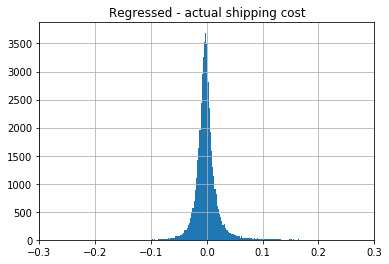

In [288]:
(y_train - y_train_pred).hist(bins=400)
plt.title('Regressed - actual shipping cost');
plt.xlim(-0.3, 0.3);

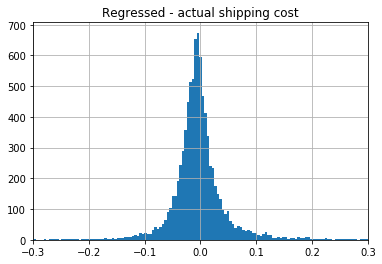

In [289]:
(y_test - y_test_pred).hist(bins=400)
plt.title('Regressed - actual shipping cost');
plt.xlim(-0.3, 0.3);

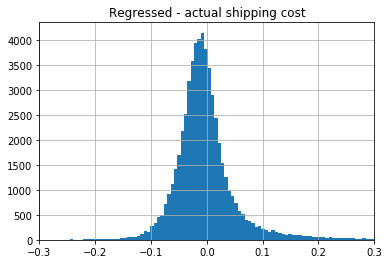

In [290]:
(y_future - y_future_pred).hist(bins=400)
plt.title('Regressed - actual shipping cost');
plt.xlim(-0.3, 0.3);

In [291]:
r2_score(y_test, y_test_pred)

0.5108206014671772

In [292]:
r2_score(y_future, y_future_pred)

0.3346033924048152

In [293]:
((y_test - y_test_pred)/y_test_pred).mean()

-0.0005753060666149642

(0, 0.5)

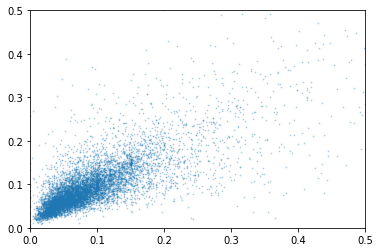

In [294]:
plt.scatter(y_test, y_test_pred, s=0.5, alpha=0.3)
plt.xlim(0,0.5)
plt.ylim(0,0.5)
# plt.xlim(-2000,1000)
# plt.ylim(-2000,1000)

(0, 0.5)

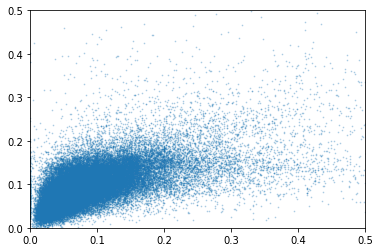

In [295]:
plt.scatter(y_future, y_future_pred, s=0.5, alpha=0.3)
plt.xlim(0,0.5)
plt.ylim(0,0.5)
# plt.xlim(-2000,1000)
# plt.ylim(-2000,1000)

### Fraction beyond 30% off

In [296]:
100.0*(abs(y_test_pred - y_test)/abs(y_test_pred) > 0.3).sum()/y_test_pred.shape[0]

42.009291521486645

In [297]:
100.0*(abs(y_future_pred - y_future)/abs(y_future_pred) > 0.3).sum()/y_future_pred.shape[0]

51.92544643631883

### Fraction beyond 50% off

In [298]:
100.0*(abs(y_test_pred - y_test)/abs(y_test_pred) > 0.5).sum()/y_test_pred.shape[0]

18.86178861788618

In [299]:
100.0*(abs(y_future_pred - y_future)/abs(y_future_pred) > 0.5).sum()/y_future_pred.shape[0]

27.714627839577947

### Fraction beyond 80% off

In [300]:
100.0*(abs(y_test_pred - y_test)/abs(y_test_pred) > 0.8).sum()/y_test_pred.shape[0]

5.86527293844367

In [301]:
100.0*(abs(y_future_pred - y_future)/abs(y_future_pred) > 0.8).sum()/y_future_pred.shape[0]

9.338285059785155

In [302]:
df_val = pd.concat([df_test, y_test], axis=1)

In [303]:
df_val.head()

,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,brand_location,...,postal_zone_2,postal_zone_3,postal_zone_4,postal_zone_5,postal_zone_6,postal_zone_7,postal_zone_8,postal_zone_45,past_target_shipping_cost_fraction,target_shipping_cost_fraction
3020,32685,CA,0.000011,0.977011,1.769585,0.25,0.678161,0.206897,0.103448,South Atlantic,...,0,0,0,0,0,0,1,0,0.056649,0.035802
26427,4401,NY,0.000043,0.000000,1.433059,0.25,0.000000,0.957265,0.034188,Pacific West,...,0,0,0,0,0,0,1,0,0.141948,0.127194
13181,45360,WA,0.000004,0.988764,1.214923,0.25,0.146067,0.662921,0.191011,Pacific West,...,0,0,1,0,0,0,0,0,0.050372,0.036842
155892,20601,NC,0.000000,0.500000,15.429070,0.25,0.000000,0.000000,1.000000,Pacific West,...,0,0,0,0,0,0,1,0,0.104098,0.156250
127220,11687,KS,0.000002,0.010101,1.905657,0.25,0.000000,0.949495,0.010101,South East,...,0,0,0,1,0,0,0,0,0.326390,0.224516


In [304]:
df_val = pd.concat([df_val.reset_index(), pd.Series(y_test_pred)], axis=1)

In [305]:
df_val.columns = df_val.columns.tolist()[:-1] + ['prediction']

In [306]:
df_val.groupby('primary_brand_category')['prediction'].mean()

primary_brand_category
Accessories        0.094189
Beauty             0.097605
Home Decor         0.119491
Jewelry            0.044373
Kids               0.106625
Kitchen            0.146940
Men                0.094259
Other              0.137352
Pets               0.115306
Stationery         0.082126
Women's Apparel    0.071236
Name: prediction, dtype: float64

In [307]:
df_val.groupby('mode_bs_postal_zone')['prediction'].mean()

mode_bs_postal_zone
2     0.076314
3     0.087398
4     0.093353
5     0.095139
6     0.101191
7     0.105092
8     0.116514
45    0.117183
Name: prediction, dtype: float64

In [308]:
df_val.head()

,index,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,...,postal_zone_3,postal_zone_4,postal_zone_5,postal_zone_6,postal_zone_7,postal_zone_8,postal_zone_45,past_target_shipping_cost_fraction,target_shipping_cost_fraction,prediction
0,3020,32685,CA,0.000011,0.977011,1.769585,0.25,0.678161,0.206897,0.103448,...,0,0,0,0,0,1,0,0.056649,0.035802,0.052888
1,26427,4401,NY,0.000043,0.000000,1.433059,0.25,0.000000,0.957265,0.034188,...,0,0,0,0,0,1,0,0.141948,0.127194,0.125944
2,13181,45360,WA,0.000004,0.988764,1.214923,0.25,0.146067,0.662921,0.191011,...,0,1,0,0,0,0,0,0.050372,0.036842,0.061872
3,155892,20601,NC,0.000000,0.500000,15.429070,0.25,0.000000,0.000000,1.000000,...,0,0,0,0,0,1,0,0.104098,0.156250,0.074480
4,127220,11687,KS,0.000002,0.010101,1.905657,0.25,0.000000,0.949495,0.010101,...,0,0,1,0,0,0,0,0.326390,0.224516,0.248015


In [309]:
df_val_future = pd.concat([df_gb_future.reset_index(), pd.Series(y_future_pred, name='prediction')], axis=1)

In [310]:
df_val_future.groupby('mode_bs_postal_zone')['prediction'].mean()

mode_bs_postal_zone
2     0.070918
3     0.080582
4     0.090101
5     0.096125
6     0.099918
7     0.105767
8     0.117657
45    0.113058
Name: prediction, dtype: float64

### Plots again

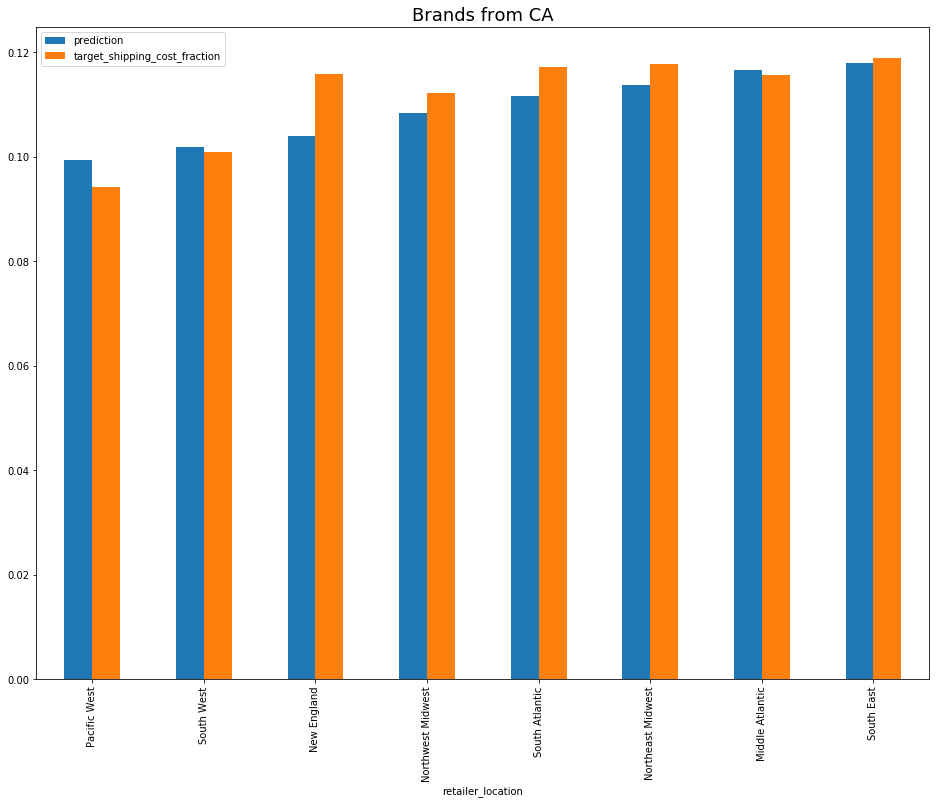

In [311]:
b_state = 'CA'
b_cat = 'Accessories'

fig, ax = plt.subplots(figsize=(16, 12));
df_val.loc[(df_val['brand_state']==b_state)
#            & (df_val['primary_brand_category']==b_cat)
           , :].groupby('retailer_location')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_state, fontsize=18);

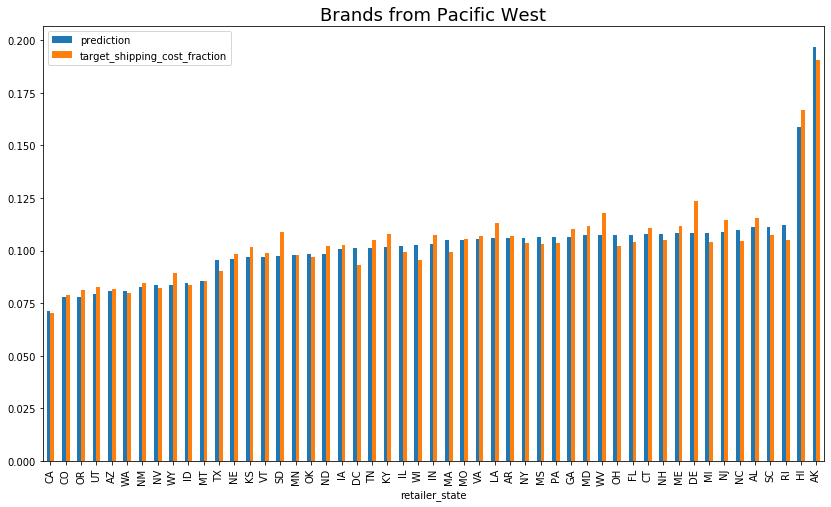

In [312]:
b_loc = 'Pacific West'
b_cat = 'Home Decor'

fig, ax = plt.subplots(figsize=(14, 8));
df_val_future.loc[(df_val_future['brand_location']==b_loc)
#            & (df_val_future['primary_brand_category']==b_cat)
#            & (df_val_future['num_brand_orders_to_state']>5)
           , :].groupby('retailer_state')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_loc, fontsize=18);

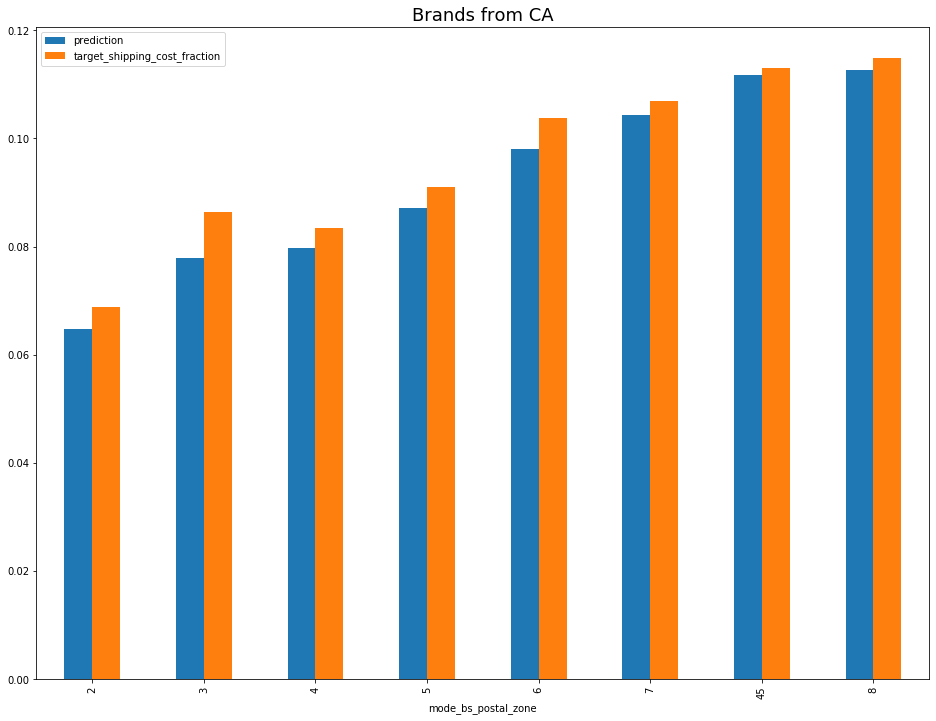

In [313]:
b_state = 'CA'
b_cat = 'Accessories'

fig, ax = plt.subplots(figsize=(16, 12));
df_val_future.loc[(df_val_future['brand_state']==b_state)
#            & (df_val_future['primary_brand_category']==b_cat)
           , :].groupby('mode_bs_postal_zone')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_state, fontsize=18);

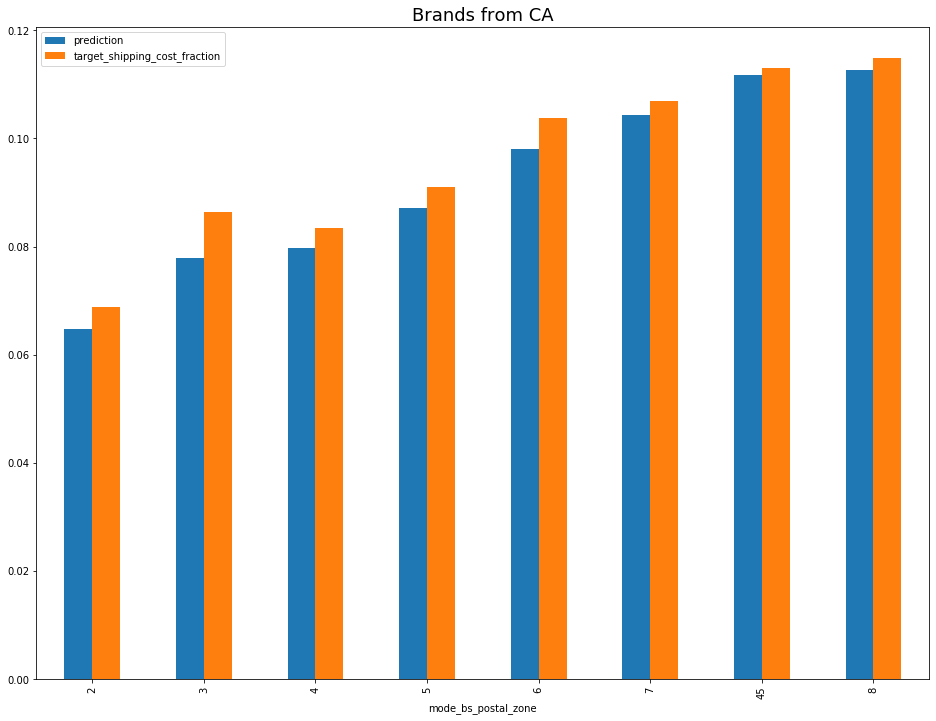

In [314]:
b_state = 'CA'
b_cat = 'Accessories'

fig, ax = plt.subplots(figsize=(16, 12));
df_val_future.loc[(df_val_future['brand_state']==b_state)
#            & (df_val_future['primary_brand_category']==b_cat)
           , :].groupby('mode_bs_postal_zone')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_state, fontsize=18);

In [315]:
# df_val.loc[df_val['brand_location']=='Northwest Midwest', 'brand_state'].value_counts()

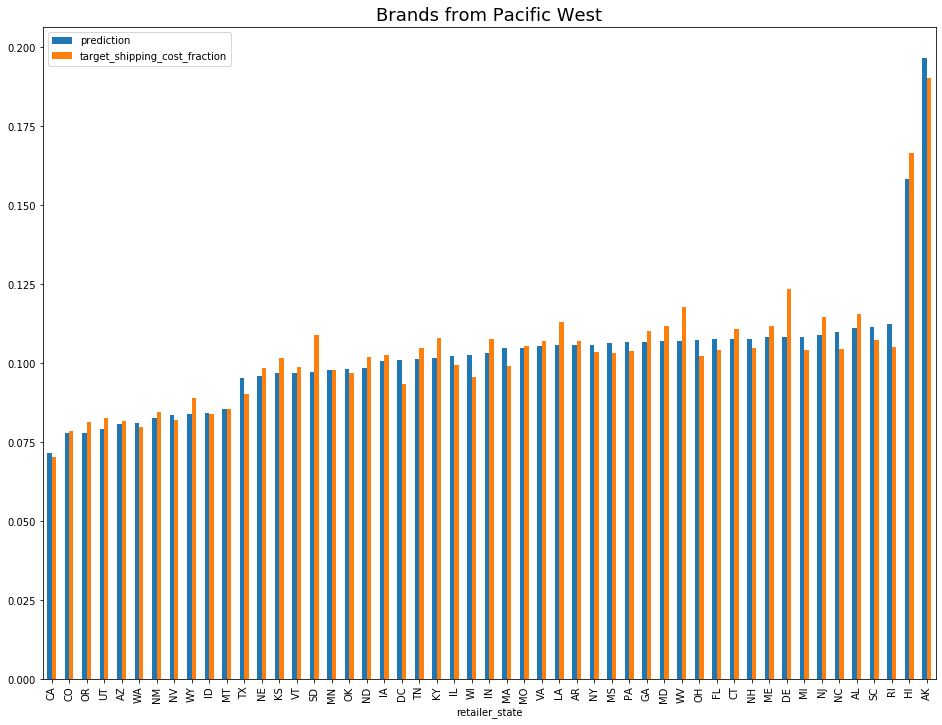

In [316]:
b_loc = 'Pacific West'
b_cat = 'Home Decor'

fig, ax = plt.subplots(figsize=(16, 12));
df_val_future.loc[(df_val_future['brand_location']==b_loc)
#            & (df_val_future['primary_brand_category']==b_cat)
#            & (df_val_future['num_brand_orders_to_state']>5)
           , :].groupby('retailer_state')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_loc, fontsize=18);

plt.show();

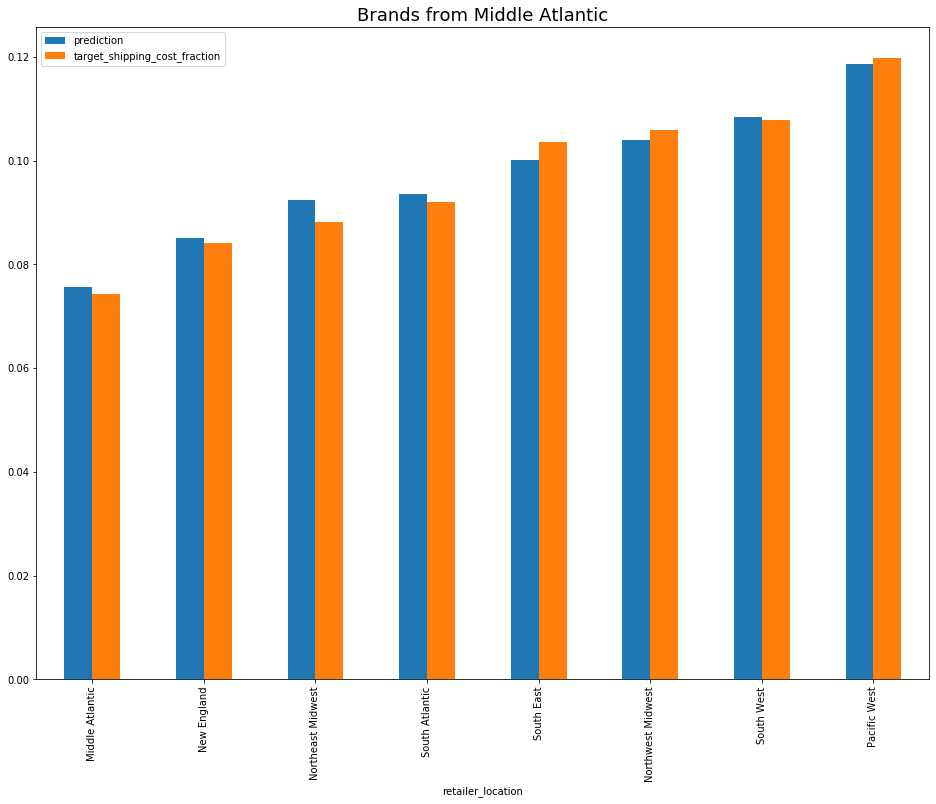

In [317]:
b_loc = 'Middle Atlantic'
b_cat = 'Accessories'

fig, ax = plt.subplots(figsize=(16, 12));
df_val_future.loc[(df_val_future['brand_location']==b_loc)
#            & (df_val_future['primary_brand_category']==b_cat)
           , :].groupby('retailer_location')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_loc, fontsize=18);

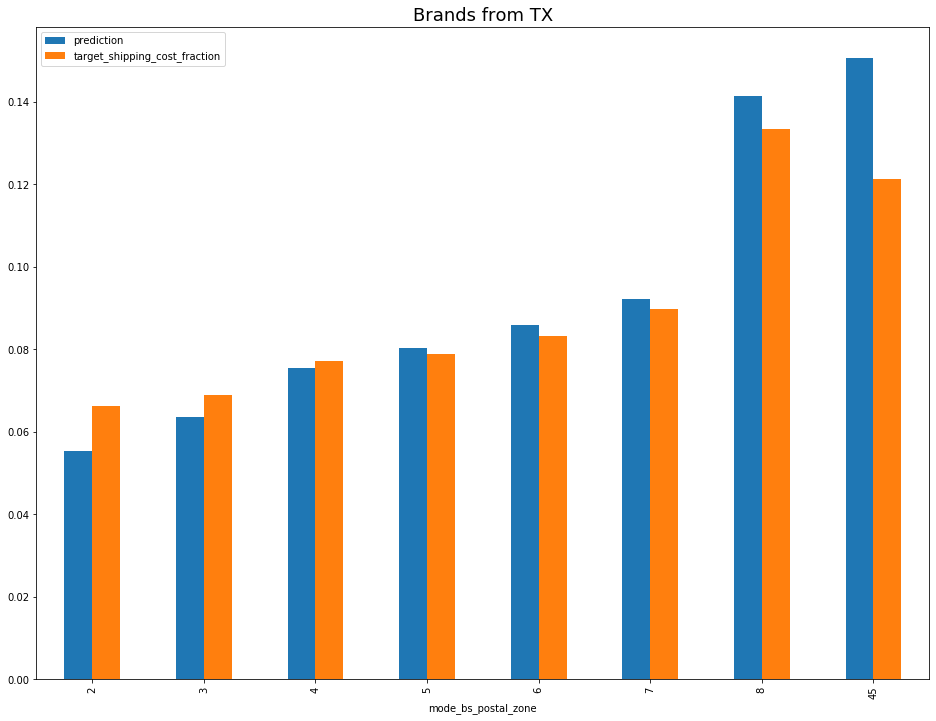

In [318]:
b_state = 'TX'
b_cat = 'Accessories'

fig, ax = plt.subplots(figsize=(16, 12));
df_val_future.loc[(df_val_future['brand_state']==b_state)
#            & (df_val_future['primary_brand_category']==b_cat)
           , :].groupby('mode_bs_postal_zone')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_state, fontsize=18);

In [319]:
# df_val.loc[df_val['brand_location']=='Northwest Midwest', 'brand_state'].value_counts()

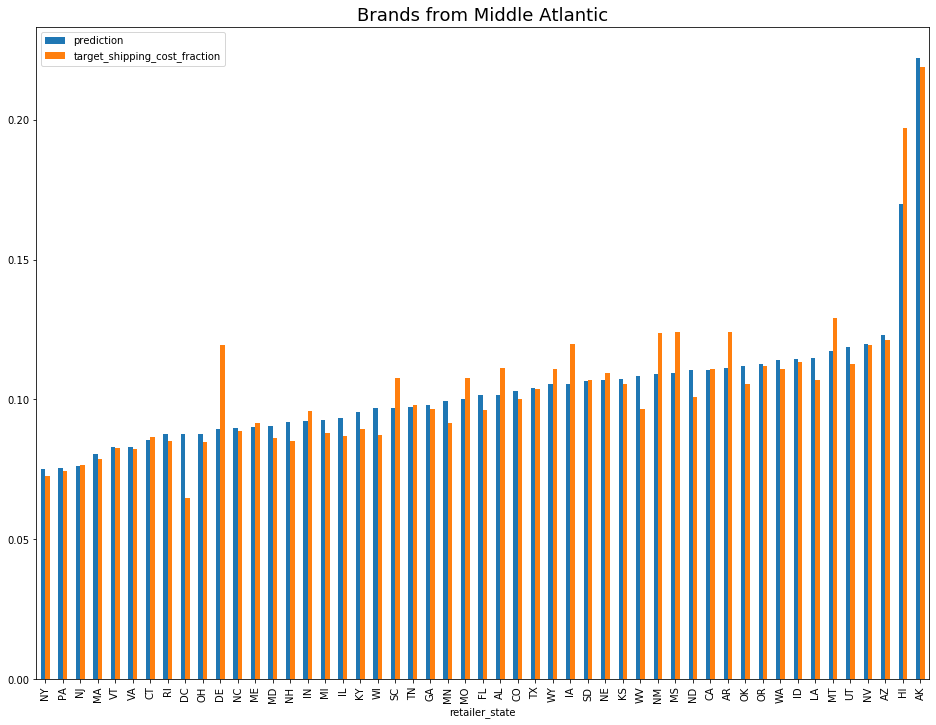

In [320]:
b_loc = 'Middle Atlantic'
b_cat = 'Home Decor'

fig, ax = plt.subplots(figsize=(16, 12));
df_val_future.loc[(df_val_future['brand_location']==b_loc)
#            & (df_val_future['primary_brand_category']==b_cat)
#            & (df_val_future['num_brand_orders_to_state']>5)
           , :].groupby('retailer_state')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_loc, fontsize=18);

### Add predictions to df_gb

In [321]:
df_gb.head()

,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,brand_location,...,postal_zone_2,postal_zone_3,postal_zone_4,postal_zone_5,postal_zone_6,postal_zone_7,postal_zone_8,postal_zone_45,past_target_shipping_cost_fraction,target_shipping_cost_fraction
0,396,CA,0.000257,0.000000,1.939162,0.15,0.974359,0.000000,0.025641,New England,...,0,0,0,0,0,0,1,0,0.165577,0.175645
1,7748,CA,0.000460,0.000000,1.772928,0.15,0.748544,0.152427,0.075728,Pacific West,...,0,0,0,0,0,1,0,0,0.115137,0.116474
2,8907,CA,0.000100,0.860759,8.010137,0.18,0.000000,0.000000,1.000000,Pacific West,...,0,1,0,0,0,0,0,0,0.046201,0.075045
3,7749,CA,0.000196,0.000000,1.450634,0.15,0.696667,0.193333,0.096667,Pacific West,...,0,0,0,0,0,1,0,0,0.102973,0.105880
4,9343,CA,0.000031,0.458333,1.427283,0.18,0.125000,0.000000,0.875000,South West,...,0,0,0,0,0,1,0,0,0.035500,NaN


In [322]:
y_test_pred = best_model.predict(df_gb[cols_to_use])

In [323]:
df_gb = pd.concat([df_gb.reset_index(), pd.Series(y_test_pred)], axis=1)

In [324]:
df_gb.columns = df_gb.columns.tolist()[:-1] + ['prediction']

In [325]:
df_gb.groupby('primary_brand_category')['prediction'].mean()

primary_brand_category
Accessories        0.096095
Beauty             0.101922
Home Decor         0.123359
Jewelry            0.044883
Kids               0.110587
Kitchen            0.153994
Men                0.105085
Other              0.143464
Pets               0.099202
Stationery         0.088329
Women's Apparel    0.078454
Name: prediction, dtype: float64

In [326]:
df_gb.groupby('mode_bs_postal_zone')['prediction'].mean()

mode_bs_postal_zone
2     0.083744
3     0.091425
4     0.094174
5     0.097470
6     0.099935
7     0.102442
8     0.117351
45    0.107628
Name: prediction, dtype: float64

# Now train an XGB regressor (Put on hold for now)

In [327]:
from xgboost import XGBRegressor, DMatrix, cv, plot_importance
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV, ParameterGrid

In [328]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [329]:
params = {
      'subsample': [0.8]
    , 'n_estimators': [220]
    , 'min_child_weight': [2]
    , 'max_depth': [12]
    , 'colsample_bytree': [0.9]
    , 'learning_rate': [0.02]
}

In [330]:
xgb = XGBRegressor(learning_rate=0.02, silent=True, nthread=1)

folds = 5
param_comb = 5

skf = KFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = GridSearchCV(xgb, param_grid=params             
# random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, random_state=1001 
                                   , scoring='r2'                 
#                                    , scoring='explained_variance'
#                                    , scoring='neg_mean_absolute_error'
#                                    , scoring='neg_median_absolute_error'
                                   , n_jobs=4, cv=skf.split(X_train,y_train), verbose=3
                                   
                            )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train[cols_to_use], y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:   52.4s remaining:  1.3min
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  1.7min finished
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



 Time taken: 0 hours 2 minutes and 40.91 seconds.


In [331]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 All results:
{'mean_fit_time': array([50.69176803]), 'std_fit_time': array([1.54455761]), 'mean_score_time': array([0.66987166]), 'std_score_time': array([0.08748155]), 'param_colsample_bytree': masked_array(data=[0.9],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_learning_rate': masked_array(data=[0.02],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[12],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[2],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[220],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_subsample': masked_array(data=[0.8],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'colsample_bytree': 0.9, 'learning_rate': 0.02, 'max_depth': 12, 'min_ch

In [332]:
# folds = 5

# # Here we go
# start_time = timer(None) # timing starts from this point for "start_time" variable

# # skf = KFold(n_splits=folds, shuffle = True, random_state = 1001)
# # for train_index, test_index in skf.split(X_train, y_train):

# error_list = []
# model_list = []
# param_grid = ParameterGrid(params)
# for p in param_grid:
# #     print(p)
#     xgb = XGBRegressor(**p)
# #     print("Trying out model:\n", xgb)
#     xgb.fit(X_train[cols_to_use], y_train)
    
#     y_future_pred = xgb.predict(df_gb_future[cols_to_use])
    
#     e = r2_score(df_gb_future[target], y_future_pred)
#     print(e)
#     error_list.append(e)
#     model_list.append(xgb)
    
# timer(start_time) # timing ends here for "start_time" variable

In [333]:
# import operator
# index, value = max(enumerate(error_list), key=operator.itemgetter(1))
# print(index, value)
# print('Best parameter set:', param_grid[index])
# xgb_model= model_list[index]

In [334]:
xgb_model = random_search.best_estimator_

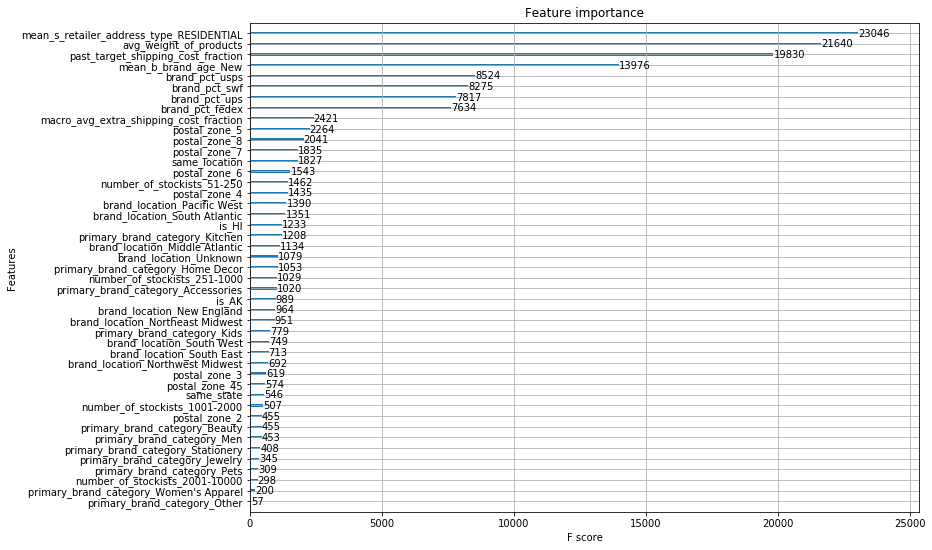

In [335]:
fig, ax = plt.subplots(figsize=(12, 9));
plot_importance(xgb_model.get_booster(), importance_type='weight', ax=ax);

In [336]:
# fig, ax = plt.subplots(figsize=(20, 15));
# plot_importance(xgb_model.get_booster(), importance_type='gain', ax=ax);

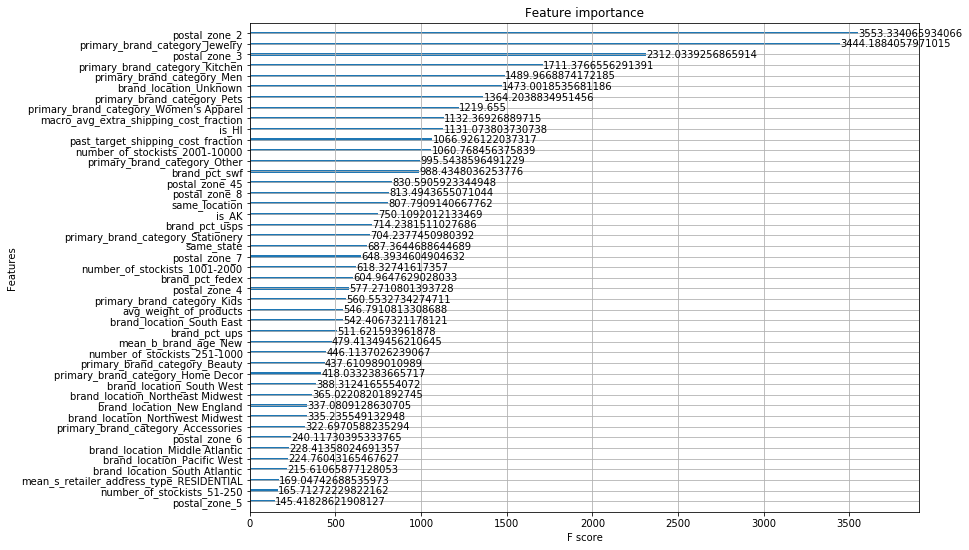

In [337]:
fig, ax = plt.subplots(figsize=(12, 9));
plot_importance(xgb_model.get_booster(), importance_type='cover', ax=ax);

In [338]:
y_test_pred = xgb_model.predict(X_test[cols_to_use])

In [339]:
y_future_pred = xgb_model.predict(df_gb_future[cols_to_use])

In [340]:
r2_score(y_test, y_test_pred)

0.5288651328293852

In [341]:
r2_score(y_future, y_future_pred)

0.7329450515543116

(0, 0.5)

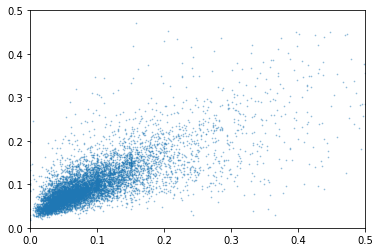

In [342]:
plt.scatter(y_test, y_test_pred, s=0.5, alpha=0.4)
plt.xlim(0,0.5)
plt.ylim(0,0.5)

(0, 0.5)

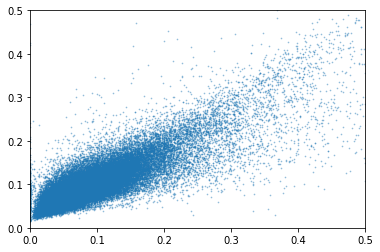

In [343]:
plt.scatter(y_future, y_future_pred, s=0.5, alpha=0.4)
plt.xlim(0,0.5)
plt.ylim(0,0.5)

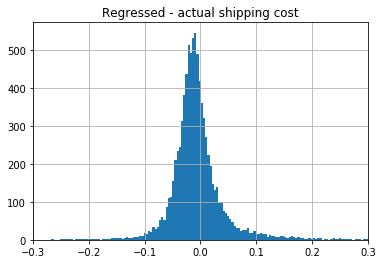

In [344]:
(y_test - y_test_pred).hist(bins=400)
plt.title('Regressed - actual shipping cost');
plt.xlim(-0.3, 0.3);

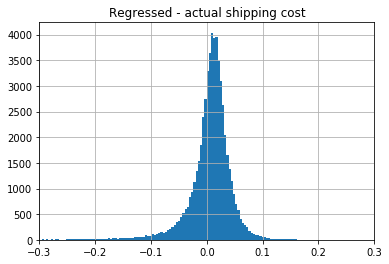

In [345]:
(y_future_pred - y_future).hist(bins=400)
plt.title('Regressed - actual shipping cost');
plt.xlim(-0.3, 0.3);

In [346]:
(y_test - y_test_pred).std()

0.05955417931185427

In [347]:
(y_future - y_future_pred).std()

0.0451506935354484

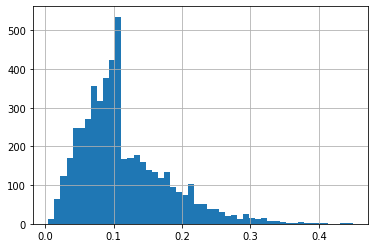

In [348]:
df_gb[['brand_id','smoothed_return_rate']].drop_duplicates()['smoothed_return_rate'].hist(bins=50)

In [349]:
df_val = pd.concat([df_test, y_test], axis=1)

In [350]:
df_val.head()

,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,brand_location,...,postal_zone_2,postal_zone_3,postal_zone_4,postal_zone_5,postal_zone_6,postal_zone_7,postal_zone_8,postal_zone_45,past_target_shipping_cost_fraction,target_shipping_cost_fraction
3020,32685,CA,0.000011,0.977011,1.769585,0.25,0.678161,0.206897,0.103448,South Atlantic,...,0,0,0,0,0,0,1,0,0.056649,0.035802
26427,4401,NY,0.000043,0.000000,1.433059,0.25,0.000000,0.957265,0.034188,Pacific West,...,0,0,0,0,0,0,1,0,0.141948,0.127194
13181,45360,WA,0.000004,0.988764,1.214923,0.25,0.146067,0.662921,0.191011,Pacific West,...,0,0,1,0,0,0,0,0,0.050372,0.036842
155892,20601,NC,0.000000,0.500000,15.429070,0.25,0.000000,0.000000,1.000000,Pacific West,...,0,0,0,0,0,0,1,0,0.104098,0.156250
127220,11687,KS,0.000002,0.010101,1.905657,0.25,0.000000,0.949495,0.010101,South East,...,0,0,0,1,0,0,0,0,0.326390,0.224516


In [351]:
df_val = pd.concat([df_val.reset_index(drop=True), pd.Series(y_test_pred)], axis=1)

In [352]:
df_val.columns = df_val.columns.tolist()[:-1] + ['prediction']

In [353]:
df_val.groupby('primary_brand_category')['prediction'].mean()

primary_brand_category
Accessories        0.097266
Beauty             0.100385
Home Decor         0.122240
Jewelry            0.049568
Kids               0.109545
Kitchen            0.149995
Men                0.097601
Other              0.141532
Pets               0.115539
Stationery         0.084905
Women's Apparel    0.074832
Name: prediction, dtype: float32

In [354]:
df_val.groupby('mode_bs_postal_zone')['prediction'].mean()

mode_bs_postal_zone
2     0.075991
3     0.088352
4     0.096293
5     0.099159
6     0.103965
7     0.108512
8     0.120880
45    0.120150
Name: prediction, dtype: float32

In [355]:
df_val.head()

,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,brand_location,...,postal_zone_3,postal_zone_4,postal_zone_5,postal_zone_6,postal_zone_7,postal_zone_8,postal_zone_45,past_target_shipping_cost_fraction,target_shipping_cost_fraction,prediction
0,32685,CA,0.000011,0.977011,1.769585,0.25,0.678161,0.206897,0.103448,South Atlantic,...,0,0,0,0,0,1,0,0.056649,0.035802,0.065691
1,4401,NY,0.000043,0.000000,1.433059,0.25,0.000000,0.957265,0.034188,Pacific West,...,0,0,0,0,0,1,0,0.141948,0.127194,0.142404
2,45360,WA,0.000004,0.988764,1.214923,0.25,0.146067,0.662921,0.191011,Pacific West,...,0,1,0,0,0,0,0,0.050372,0.036842,0.056729
3,20601,NC,0.000000,0.500000,15.429070,0.25,0.000000,0.000000,1.000000,Pacific West,...,0,0,0,0,0,1,0,0.104098,0.156250,0.101809
4,11687,KS,0.000002,0.010101,1.905657,0.25,0.000000,0.949495,0.010101,South East,...,0,0,1,0,0,0,0,0.326390,0.224516,0.205794


In [356]:
df_val_future = pd.concat([df_gb_future.reset_index(drop=True), pd.Series(y_future_pred, name='prediction')], axis=1)

In [357]:
df_val_future.groupby('mode_bs_postal_zone')['prediction'].mean()

mode_bs_postal_zone
2     0.078061
3     0.087478
4     0.095789
5     0.101054
6     0.103722
7     0.109155
8     0.121243
45    0.116225
Name: prediction, dtype: float32

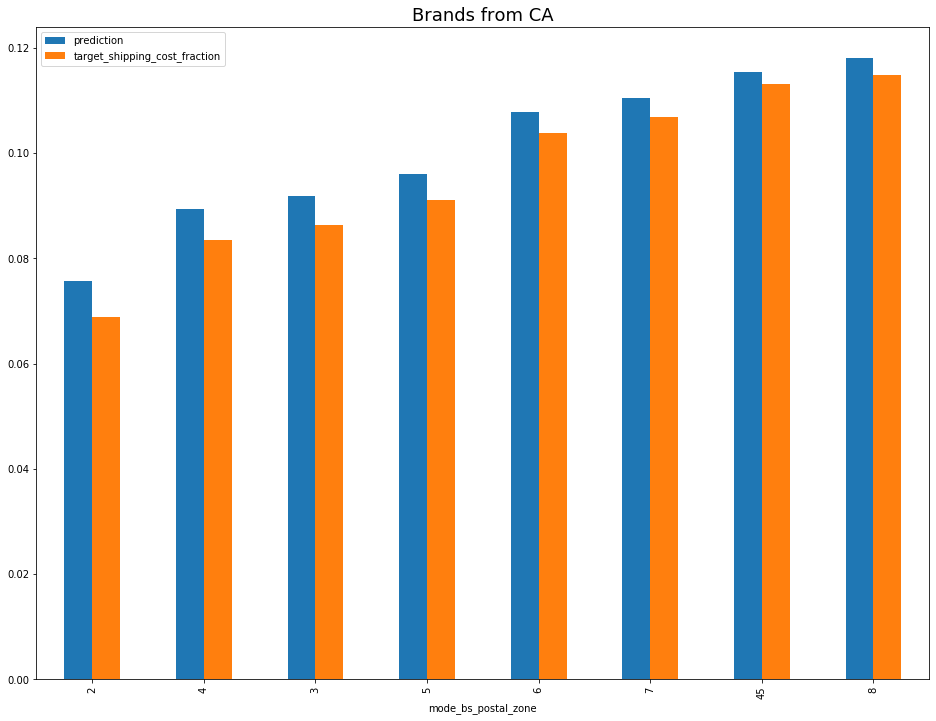

In [358]:
b_state = 'CA'
b_cat = 'Accessories'

fig, ax = plt.subplots(figsize=(16, 12));
df_val_future.loc[(df_val_future['brand_state']==b_state)
#            & (df_val_future['primary_brand_category']==b_cat)
           , :].groupby('mode_bs_postal_zone')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_state, fontsize=18);

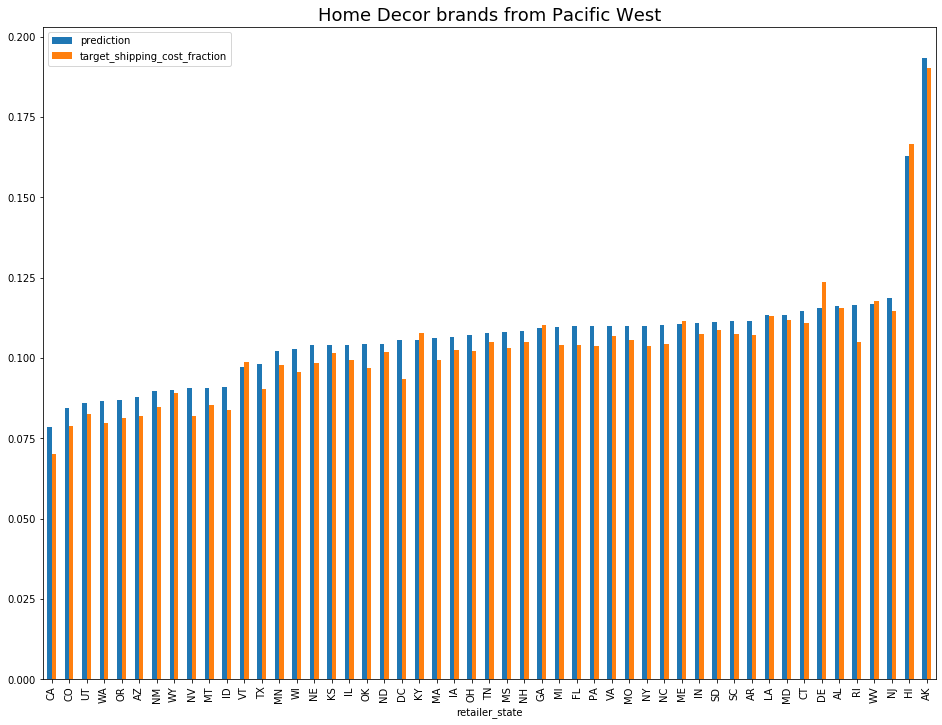

In [359]:
b_loc = 'Pacific West'
b_cat = 'Home Decor'

fig, ax = plt.subplots(figsize=(16, 12));
df_val_future.loc[(df_val_future['brand_location']==b_loc)
#            & (df_val_future['primary_brand_category']==b_cat)
#            & (df_val_future['num_brand_orders_to_state']>5)
           , :].groupby('retailer_state')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title(b_cat+' brands from '+b_loc, fontsize=18);

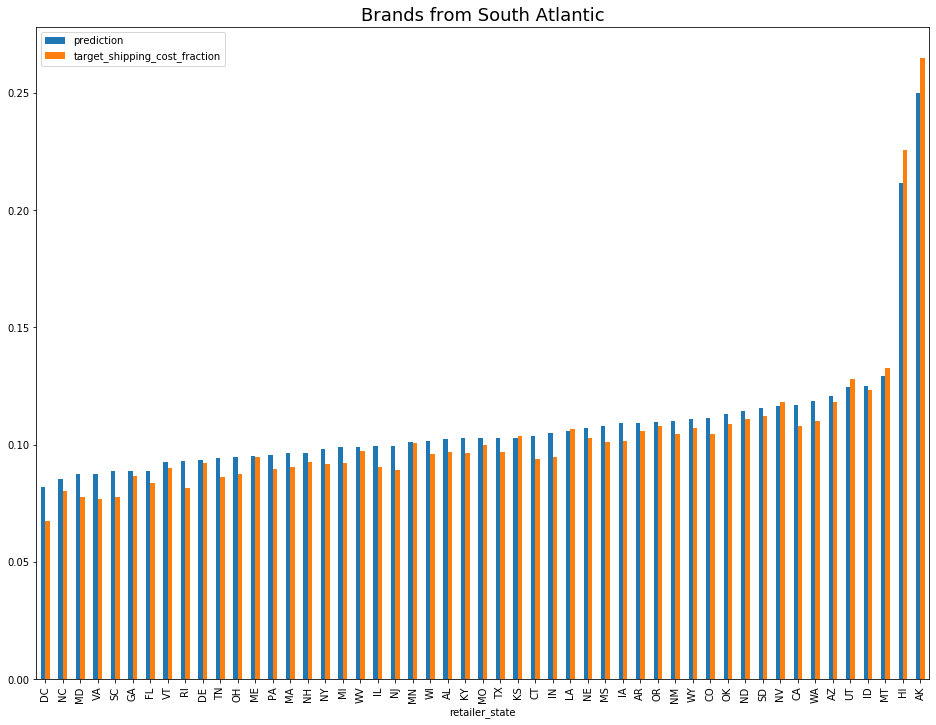

In [360]:
b_loc = 'South Atlantic'
b_cat = 'Home Decor'

fig, ax = plt.subplots(figsize=(16, 12));
df_val_future.loc[(df_val_future['brand_location']==b_loc)
#            & (df_val_future['primary_brand_category']==b_cat)
#            & (df_val_future['num_brand_orders_to_state']>5)
           , :].groupby('retailer_state')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_loc, fontsize=18);

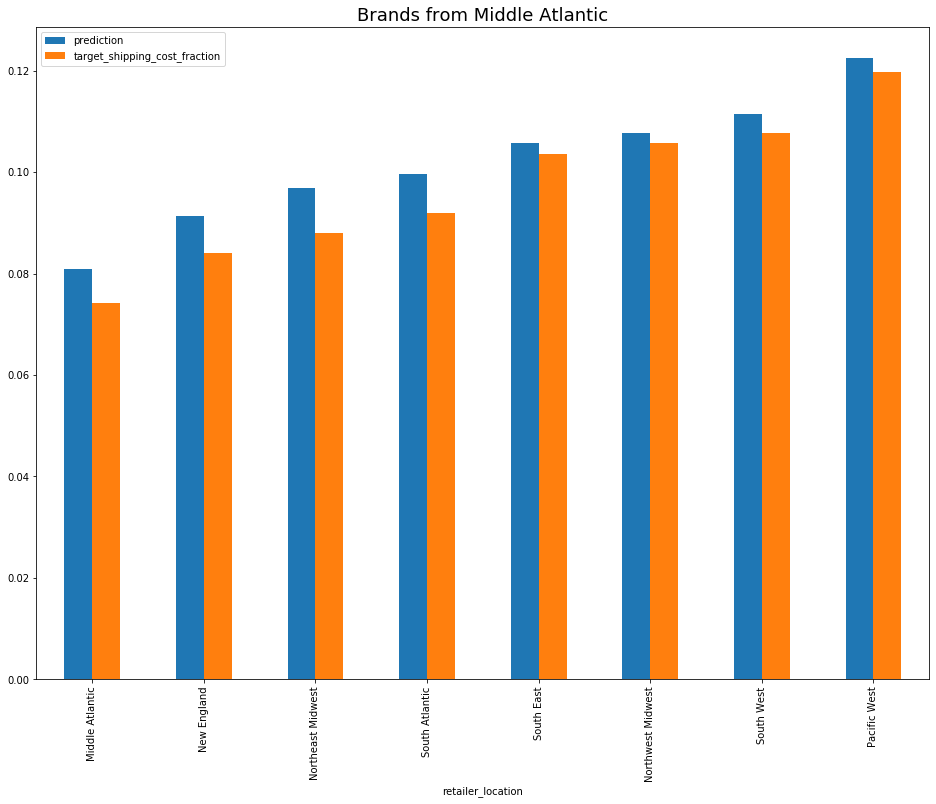

In [361]:
b_loc = 'Middle Atlantic'
b_cat = 'Accessories'

fig, ax = plt.subplots(figsize=(16, 12));
df_val_future.loc[(df_val_future['brand_location']==b_loc)
#            & (df_val_future['primary_brand_category']==b_cat)
           , :].groupby('retailer_location')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_loc, fontsize=18);

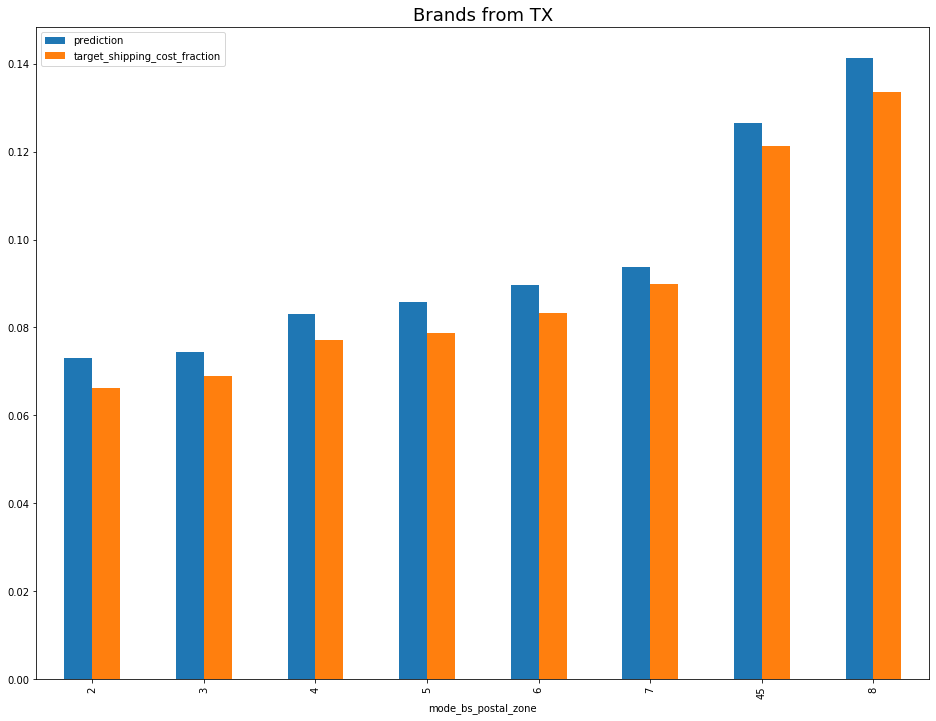

In [362]:
b_state = 'TX'
b_cat = 'Accessories'

fig, ax = plt.subplots(figsize=(16, 12));
df_val_future.loc[(df_val_future['brand_state']==b_state)
#            & (df_val_future['primary_brand_category']==b_cat)
           , :].groupby('mode_bs_postal_zone')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_state, fontsize=18);

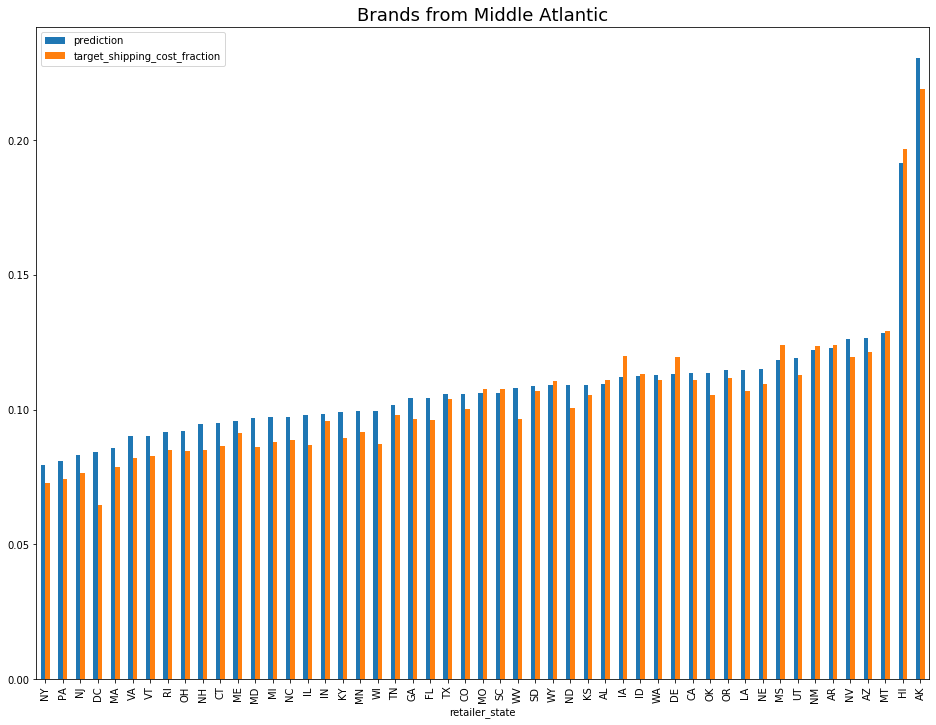

In [363]:
b_loc = 'Middle Atlantic'
b_cat = 'Home Decor'

fig, ax = plt.subplots(figsize=(16, 12));
df_val_future.loc[(df_val_future['brand_location']==b_loc)
#            & (df_val_future['primary_brand_category']==b_cat)
#            & (df_val_future['num_brand_orders_to_state']>5)
           , :].groupby('retailer_state')['prediction', target].mean(
).sort_values(by='prediction').plot(kind='bar', ax=ax);

plt.title('Brands from '+b_loc, fontsize=18);

In [364]:
df_val_future.loc[df_val_future['brand_state']=='NY',
                  ['retailer_state','prediction']].groupby('retailer_state')['prediction'].mean().sort_values()

retailer_state
NY    0.079887
NJ    0.087243
MA    0.087675
DC    0.088142
PA    0.089832
VT    0.090965
VA    0.092987
ME    0.095052
RI    0.095605
KY    0.096463
OH    0.096640
TN    0.099720
NC    0.100206
NH    0.100515
MN    0.100637
IL    0.101032
MI    0.101103
WI    0.101897
MD    0.102349
CT    0.102534
IN    0.103072
CO    0.105722
AL    0.105740
GA    0.106887
WV    0.108209
MO    0.108887
TX    0.108894
FL    0.110267
ND    0.110812
ID    0.110872
WA    0.112274
SC    0.113162
IA    0.114273
LA    0.114359
OK    0.114682
WY    0.115681
OR    0.115709
SD    0.117344
CA    0.118330
KS    0.119099
NE    0.119764
NM    0.122802
UT    0.124438
MS    0.125119
AZ    0.127275
AR    0.130969
MT    0.133683
DE    0.137206
NV    0.139367
HI    0.218563
AK    0.237853
Name: prediction, dtype: float32

In [365]:
df_val_future.loc[df_val_future['brand_state']=='CA',
                  ['retailer_state','prediction']].groupby('retailer_state')['prediction'].mean().sort_values()

retailer_state
CA    0.076493
NV    0.085967
CO    0.091124
UT    0.091303
NM    0.091428
AZ    0.091912
VT    0.094340
OR    0.095139
WA    0.095788
MT    0.095820
ID    0.096434
WY    0.099543
TX    0.100368
MN    0.105251
DC    0.106005
IL    0.107388
ND    0.107434
WI    0.108255
KY    0.108704
MA    0.109044
OK    0.109164
FL    0.110591
NY    0.110721
TN    0.110755
KS    0.110832
MS    0.110854
ME    0.111134
NE    0.111195
IA    0.111206
OH    0.111516
VA    0.112295
PA    0.112837
NH    0.113773
MO    0.114034
MI    0.114395
SC    0.114938
NC    0.114993
IN    0.115076
GA    0.115386
DE    0.116520
CT    0.117622
MD    0.117676
LA    0.119472
SD    0.119705
AL    0.120559
AR    0.121280
NJ    0.124697
WV    0.125804
RI    0.126354
HI    0.168926
AK    0.216093
Name: prediction, dtype: float32

### Add predictions to df_gb

In [366]:
if use_xgb_model:
    df_gb['prediction'] = xgb_model.predict(df_gb[cols_to_use])
else:
    df_gb['prediction'] = best_model.predict(df_gb[cols_to_use])

In [367]:
df_gb.groupby('primary_brand_category')['prediction'].mean()

primary_brand_category
Accessories        0.100033
Beauty             0.106433
Home Decor         0.128260
Jewelry            0.050441
Kids               0.112842
Kitchen            0.157977
Men                0.106767
Other              0.143795
Pets               0.104921
Stationery         0.091053
Women's Apparel    0.082331
Name: prediction, dtype: float32

In [368]:
df_gb.groupby('mode_bs_postal_zone')['prediction'].mean()

mode_bs_postal_zone
2     0.083616
3     0.091594
4     0.097718
5     0.101663
6     0.103976
7     0.107231
8     0.123246
45    0.112052
Name: prediction, dtype: float32

## Hack away from the bottom to keep 30% of historical GMV:

In [369]:
df_gb[['brand_id', 'primary_brand_category']].drop_duplicates()['primary_brand_category'].value_counts()

Accessories        900
Home Decor         788
Beauty             770
Jewelry            711
Kitchen            640
Stationery         573
Kids               226
Women's Apparel    194
Men                101
Other               94
Pets                68
Name: primary_brand_category, dtype: int64

### Blended commission as function of 1st order commission

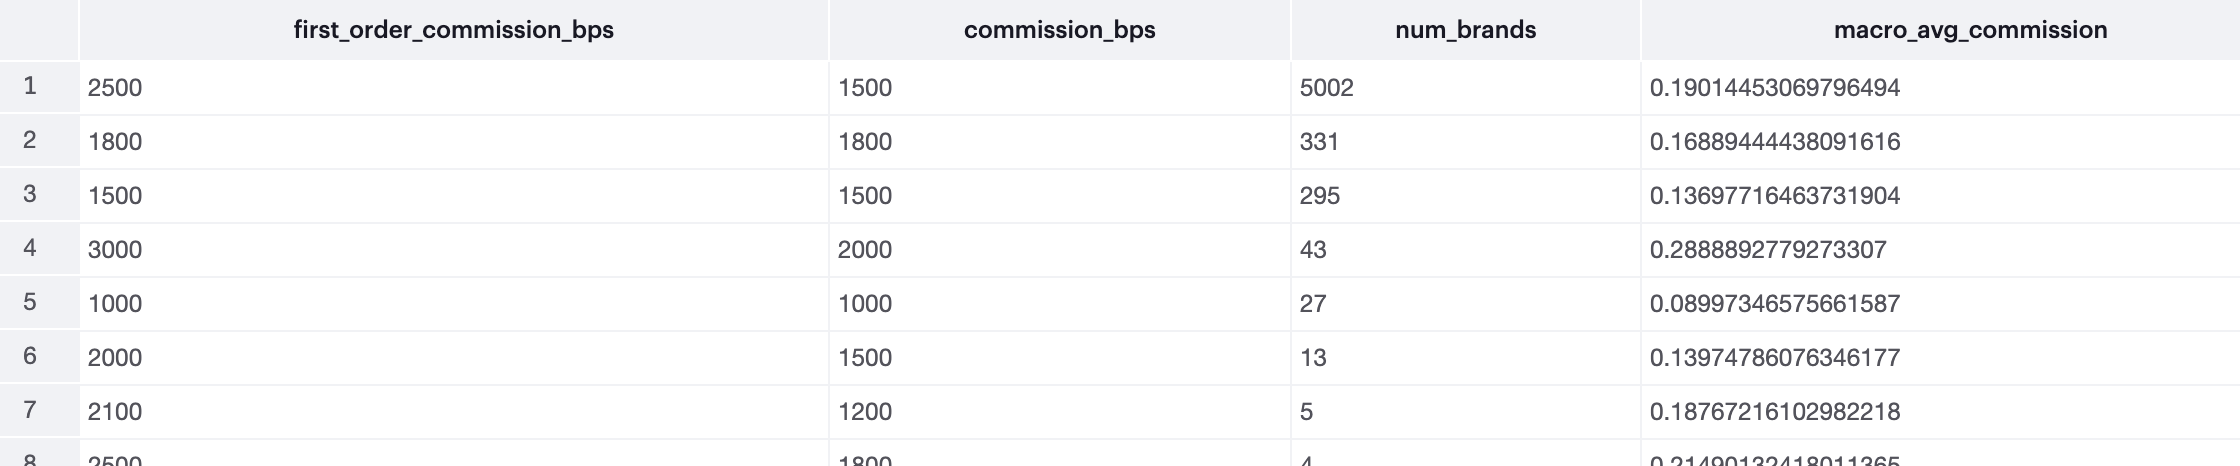

In [370]:
0.169/0.18

0.938888888888889

In [371]:
0.137/0.15

0.9133333333333334

In [372]:
0.19/0.25

0.76

In [373]:
df_gb['first_order_commission'].value_counts()

0.250    218637
0.180     16932
0.150     14790
0.000      3927
0.100      1275
0.200       816
0.300       816
0.210       357
0.120       153
0.220       102
0.110       102
0.125       102
0.070        51
0.050        51
0.170        51
0.230        51
0.240        51
0.010        51
Name: first_order_commission, dtype: int64

In [374]:
df_gb['blended_commission'] = df_gb['first_order_commission'].apply(
    lambda x: 0.19 if x >= 0.25 else 0.92*x
)

In [375]:
# df_gb['simplified_commission'] = -1.0*df_gb['prediction']

df_gb['simplified_commission'] = df_gb['blended_commission'] \
                               - 0.5*df_gb['smoothed_return_rate'] \
                               - df_gb['prediction']

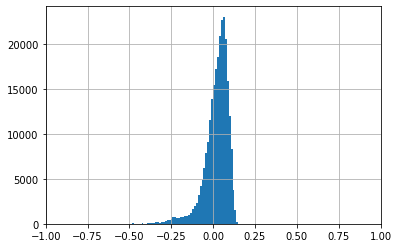

In [376]:
df_gb['simplified_commission'].hist(bins=100)
plt.xlim(-1.0, 1.0);

In [377]:
df_gb.shape

(258315, 91)

In [378]:
df_gb = df_gb.sort_values('simplified_commission', ascending=False)

In [379]:
df_gb.head()

,index,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,...,postal_zone_5,postal_zone_6,postal_zone_7,postal_zone_8,postal_zone_45,past_target_shipping_cost_fraction,target_shipping_cost_fraction,prediction,blended_commission,simplified_commission
184801,184801,5954,VT,0.000256,0.0,0.522108,0.25,0.0,0.0,0.656250,...,0,0,0,0,0,0.007853,0.005869,0.018994,0.19,0.162261
17656,17656,5954,CT,0.000015,0.0,0.522108,0.25,0.0,0.0,0.656250,...,0,0,0,0,0,0.009316,0.000032,0.021369,0.19,0.159886
179736,179736,5954,NH,0.000019,0.0,0.522108,0.25,0.0,0.0,0.656250,...,0,0,0,0,0,0.012366,0.011225,0.022579,0.19,0.158676
30721,30721,32760,OH,0.000007,0.0,1.001305,0.25,0.0,0.0,0.989247,...,0,0,1,0,0,0.007319,0.018910,0.026301,0.19,0.154944
187736,187736,32760,MT,0.000008,0.0,1.001305,0.25,0.0,0.0,0.989247,...,0,0,0,0,0,0.008124,0.019365,0.026931,0.19,0.154314


In [380]:
for t in range(20):
    df_top = df_gb.head(int(5*t*df_gb.shape[0]/100.0))
    print('Top {0}%: {1:.2f}'.format(int(5*t), df_top['historical_gmv_fraction'].sum()))

Top 0%: 0.00
Top 5%: 0.11
Top 10%: 0.17
Top 15%: 0.22
Top 20%: 0.27
Top 25%: 0.31
Top 30%: 0.36
Top 35%: 0.42
Top 40%: 0.46
Top 45%: 0.51
Top 50%: 0.55
Top 55%: 0.59
Top 60%: 0.64
Top 65%: 0.69
Top 70%: 0.74
Top 75%: 0.78
Top 80%: 0.82
Top 85%: 0.87
Top 90%: 0.91
Top 95%: 0.95


## Only brands with >=4 rr_cured orders

In [381]:
df_gb['historical_gmv_fraction'].sum()

0.9740295074134251

In [382]:
df_gb = df_gb.loc[df_gb['num_rr_cured_brand_orders']>=4, :]

In [383]:
df_gb['historical_gmv_fraction'].sum()

0.9679615493139923

### Simplified top selection

In [384]:
df_gb[['first_order_commission', 'smoothed_return_rate', 'prediction']].isna().sum()

first_order_commission    0
smoothed_return_rate      0
prediction                0
dtype: int64

In [385]:
df_gb.shape

(209304, 91)

In [386]:
df_gb.head(1000)['simplified_commission'].mean()

0.13612507873591456

In [387]:
df_gb.tail(1000)['simplified_commission'].mean()

-0.4106243712967364

In [388]:
df_top = df_gb.head(int(28*df_gb.shape[0]/100.0))
print('Top {0}%: {1:.2f}'.format(42, df_top['historical_gmv_fraction'].sum()))

Top 42%: 0.32


In [389]:
df_top.loc[df_top['primary_brand_category']=='Jewelry', 'blended_commission'].mean()

0.18887234466939262

### Stratified top selection

In [390]:
overall_top_fraction = 28

In [391]:
top_fractions = {
    'Accessories': 0.9*overall_top_fraction,
    'Beauty': .98*overall_top_fraction,
    'Home Decor': 0.98*overall_top_fraction,
    'Jewelry': 0.875*overall_top_fraction,
    'Kitchen': 0.9*overall_top_fraction,
    'Kids': 1.*overall_top_fraction,
    'Men': 0.82*overall_top_fraction,
    'Other': 0.8*overall_top_fraction,
    'Pets': .98*overall_top_fraction,
    'Stationery': .9*overall_top_fraction,
    "Women\'s Apparel": 1.*overall_top_fraction,
}

In [392]:
top_df_dict = {}
for c in df_gb['primary_brand_category'].unique().tolist():
    print(c)
    t = top_fractions[c] + 25
    cat_gmv_fraction = df_gb.loc[df_gb['primary_brand_category'] == c, 'historical_gmv_fraction'].sum()
    
    df_c_gb = df_gb.loc[df_gb['primary_brand_category'] == c, :]
#     .sort_values(by='simplified_commission',ascending=False)
    df_c_top = df_c_gb.head(int(t*df_c_gb.shape[0]/100.0))
    print('Top {0}% in {1}: {2:.2f}'.format(t, c, df_c_top['historical_gmv_fraction'].sum() / cat_gmv_fraction) )
    top_df_dict[c] = df_c_top

Jewelry
Top 49.5% in Jewelry: 0.54
Stationery
Top 50.2% in Stationery: 0.54
Pets
Top 52.44% in Pets: 0.58
Kitchen
Top 50.2% in Kitchen: 0.57
Home Decor
Top 52.44% in Home Decor: 0.61
Accessories
Top 50.2% in Accessories: 0.54
Beauty
Top 52.44% in Beauty: 0.56
Women's Apparel
Top 53.0% in Women's Apparel: 0.69
Kids
Top 53.0% in Kids: 0.63
Men
Top 47.959999999999994% in Men: 0.61
Other
Top 47.400000000000006% in Other: 0.63


In [393]:
df_stratified_top = pd.DataFrame().reindex_like(df_gb.head(0))

In [394]:
for c, df_c in top_df_dict.items():
#     print(df_c['mode_bs_postal_zone'].isna().sum())pol
    df_stratified_top = pd.concat([df_stratified_top, df_c], axis=0)
#     print(df_stratified_top.head())

In [395]:
df_stratified_top.head()

,index,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,...,postal_zone_5,postal_zone_6,postal_zone_7,postal_zone_8,postal_zone_45,past_target_shipping_cost_fraction,target_shipping_cost_fraction,prediction,blended_commission,simplified_commission
184801,184801.0,5954.0,VT,0.000256,0.0,0.522108,0.25,0.0,0.0,0.656250,...,0.0,0.0,0.0,0.0,0.0,0.007853,0.005869,0.018994,0.19,0.162261
17656,17656.0,5954.0,CT,0.000015,0.0,0.522108,0.25,0.0,0.0,0.656250,...,0.0,0.0,0.0,0.0,0.0,0.009316,0.000032,0.021369,0.19,0.159886
179736,179736.0,5954.0,NH,0.000019,0.0,0.522108,0.25,0.0,0.0,0.656250,...,0.0,0.0,0.0,0.0,0.0,0.012366,0.011225,0.022579,0.19,0.158676
30721,30721.0,32760.0,OH,0.000007,0.0,1.001305,0.25,0.0,0.0,0.989247,...,0.0,0.0,1.0,0.0,0.0,0.007319,0.018910,0.026301,0.19,0.154944
187736,187736.0,32760.0,MT,0.000008,0.0,1.001305,0.25,0.0,0.0,0.989247,...,0.0,0.0,0.0,0.0,0.0,0.008124,0.019365,0.026931,0.19,0.154314


In [396]:
df_stratified_top.shape

(106708, 91)

In [397]:
df_top.shape

(58605, 91)

In [398]:
df_stratified_top['mode_bs_postal_zone'].isna().sum()

0

In [399]:
df_gb[['brand_id', 'primary_brand_category']].drop_duplicates()['primary_brand_category'].value_counts()

Accessories        711
Home Decor         665
Beauty             586
Jewelry            582
Kitchen            541
Stationery         501
Kids               201
Women's Apparel    146
Men                 67
Pets                58
Other               46
Name: primary_brand_category, dtype: int64

In [400]:
df_top[['brand_id', 'primary_brand_category']].drop_duplicates()['primary_brand_category'].value_counts()

Jewelry            454
Accessories        378
Stationery         355
Beauty             297
Home Decor         288
Kitchen            181
Kids                93
Women's Apparel     58
Pets                37
Men                 31
Other               17
Name: primary_brand_category, dtype: int64

In [401]:
df_stratified_top[['brand_id', 'primary_brand_category']].drop_duplicates()['primary_brand_category'].value_counts()

Home Decor         541
Accessories        498
Beauty             467
Kitchen            467
Jewelry            366
Stationery         363
Kids               156
Women's Apparel    109
Men                 54
Pets                41
Other               36
Name: primary_brand_category, dtype: int64

In [402]:
df_stratified_top['mode_bs_postal_zone'].isna().sum()

0

### High commission, no zone >= 6 selection

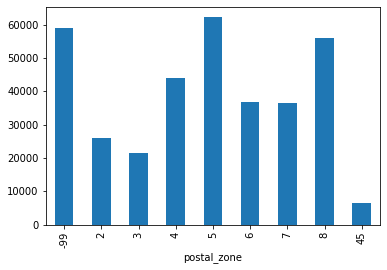

In [403]:
df.groupby('postal_zone')['brand_order_id'].nunique().plot(kind='bar')

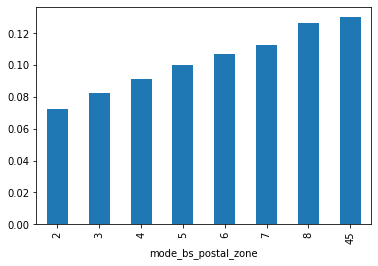

In [404]:
df_gb.groupby('mode_bs_postal_zone')['macro_avg_shipping_cost_fraction'].mean().plot(kind='bar')

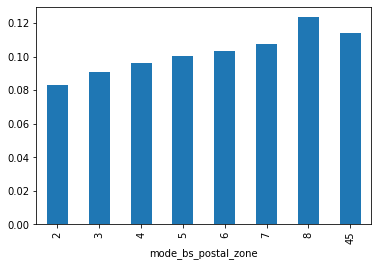

In [405]:
df_gb.groupby('mode_bs_postal_zone')['prediction'].mean().plot(kind='bar')

In [406]:
df_gb.columns

Index(['index', 'brand_id', 'retailer_state', 'historical_gmv_fraction',
       'brand_pct_swf', 'avg_weight_of_products', 'first_order_commission',
       'brand_pct_fedex', 'brand_pct_ups', 'brand_pct_usps', 'brand_location',
       'brand_state', 'brand_location_Canada',
       'brand_location_Middle Atlantic', 'brand_location_New England',
       'brand_location_Northeast Midwest', 'brand_location_Northwest Midwest',
       'brand_location_Pacific West', 'brand_location_South Atlantic',
       'brand_location_South East', 'brand_location_South West',
       'brand_location_Unknown', 'number_of_stockists_1001-2000',
       'number_of_stockists_2001-10000', 'number_of_stockists_251-1000',
       'number_of_stockists_51-250', 'number_of_stockists_<=50',
       'primary_brand_category', 'primary_brand_category_Accessories',
       'primary_brand_category_Beauty', 'primary_brand_category_Home Decor',
       'primary_brand_category_Jewelry', 'primary_brand_category_Kids',
       'primary

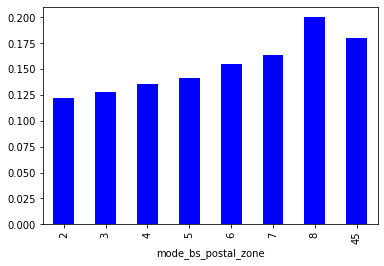

In [407]:
# fig, ax = plt.subplots(figsize=(12, 9));
width=0.35

bar1 = df_gb.loc[(df_gb['primary_brand_category']=='Kitchen')
#           & (df_gb['num_brand_orders_to_state']>5)
          , :].groupby(
    'mode_bs_postal_zone'
)['prediction'].mean().plot(kind='bar', label='Prediction', color='b');

plt.show()

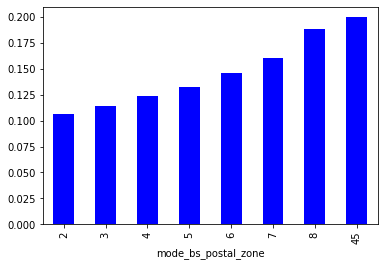

In [408]:
bar2 = df_gb.loc[(df_gb['primary_brand_category']=='Kitchen')
#           & (df_gb['num_brand_orders_to_state']>5)
          , :].groupby(
    'mode_bs_postal_zone'
)[target].mean().plot(kind='bar', label='Label', color='b');

# plt.bar(x=[(x) for x in bar1.index], height=bar1.values, label='Label', color='r', width=width)
# plt.bar(x=[(x+width) for x in bar2.index], height=bar2.values, label='Prediction', color='b', width=width)

# plt.legend(loc='best');

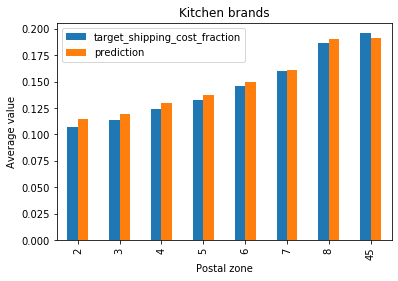

In [409]:
# fig, ax = plt.subplots(figsize=(12, 9));

b_cat = 'Kitchen'
df_val_future.loc[(df_val_future['primary_brand_category']==b_cat)
#           & (df_val_future['num_brand_orders_to_state']>5)
          , :].groupby(
    'mode_bs_postal_zone'
)[target, 'prediction'].mean().plot(kind='bar');

# plt.bar(x=[(x) for x in bar1.index], height=bar1.values, label='Label', color='r', width=width)
# plt.bar(x=[(x+width) for x in bar2.index], height=bar2.values, label='Prediction', color='b', width=width)

# plt.legend(loc='best');

plt.title(b_cat+' brands');
plt.xlabel('Postal zone');
plt.ylabel('Average value');
plt.show();

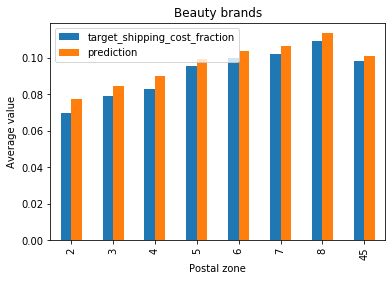

In [410]:
# fig, ax = plt.subplots(figsize=(12, 9));

b_cat = 'Beauty'
df_val_future.loc[(df_val_future['primary_brand_category']==b_cat)
#           & (df_val_future['num_brand_orders_to_state']>5)
          , :].groupby(
    'mode_bs_postal_zone'
)[target, 'prediction'].mean().plot(kind='bar');

# plt.bar(x=[(x) for x in bar1.index], height=bar1.values, label='Label', color='r', width=width)
# plt.bar(x=[(x+width) for x in bar2.index], height=bar2.values, label='Prediction', color='b', width=width)

# plt.legend(loc='best');

plt.title(b_cat+' brands');
plt.xlabel('Postal zone');
plt.ylabel('Average value');

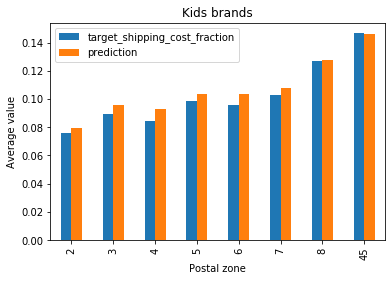

In [411]:
# fig, ax = plt.subplots(figsize=(12, 9));

b_cat = 'Kids'
df_val_future.loc[(df_val_future['primary_brand_category']==b_cat)
#           & (df_val_future['num_brand_orders_to_state']>5)
          , :].groupby(
    'mode_bs_postal_zone'
)[target, 'prediction'].mean().plot(kind='bar');

# plt.bar(x=[(x) for x in bar1.index], height=bar1.values, label='Label', color='r', width=width)
# plt.bar(x=[(x+width) for x in bar2.index], height=bar2.values, label='Prediction', color='b', width=width)

# plt.legend(loc='best');

plt.title(b_cat+' brands');
plt.xlabel('Postal zone');
plt.ylabel('Average value');

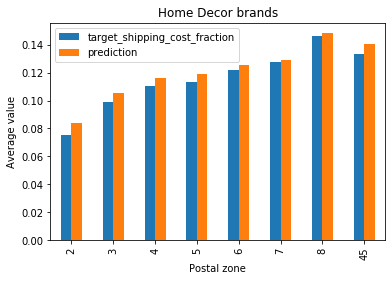

In [412]:
# fig, ax = plt.subplots(figsize=(12, 9));

b_cat = 'Home Decor'
df_val_future.loc[(df_val_future['primary_brand_category']==b_cat)
#           & (df_val_future['num_brand_orders_to_state']>5)
          , :].groupby(
    'mode_bs_postal_zone'
)[target, 'prediction'].mean().plot(kind='bar');

# plt.bar(x=[(x) for x in bar1.index], height=bar1.values, label='Label', color='r', width=width)
# plt.bar(x=[(x+width) for x in bar2.index], height=bar2.values, label='Prediction', color='b', width=width)

# plt.legend(loc='best');

plt.title(b_cat+' brands');
plt.xlabel('Postal zone');
plt.ylabel('Average value');

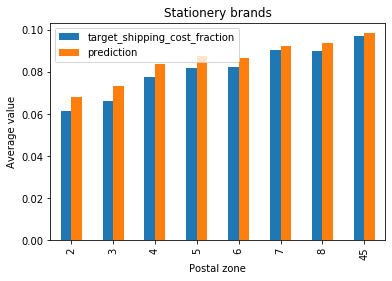

In [413]:
# fig, ax = plt.subplots(figsize=(12, 9));

b_cat = 'Stationery'
df_val_future.loc[(df_val_future['primary_brand_category']==b_cat)
#           & (df_val_future['num_brand_orders_to_state']>5)
          , :].groupby(
    'mode_bs_postal_zone'
)[target, 'prediction'].mean().plot(kind='bar');

# plt.bar(x=[(x) for x in bar1.index], height=bar1.values, label='Label', color='r', width=width)
# plt.bar(x=[(x+width) for x in bar2.index], height=bar2.values, label='Prediction', color='b', width=width)

# plt.legend(loc='best');

plt.title(b_cat+' brands');
plt.xlabel('Postal zone');
plt.ylabel('Average value');

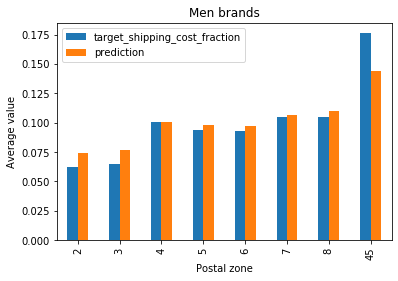

In [414]:
# fig, ax = plt.subplots(figsize=(12, 9));

b_cat = 'Men'
df_val_future.loc[(df_val_future['primary_brand_category']==b_cat)
#           & (df_val_future['num_brand_orders_to_state']>5)
          , :].groupby(
    'mode_bs_postal_zone'
)[target, 'prediction'].mean().plot(kind='bar');

# plt.bar(x=[(x) for x in bar1.index], height=bar1.values, label='Label', color='r', width=width)
# plt.bar(x=[(x+width) for x in bar2.index], height=bar2.values, label='Prediction', color='b', width=width)

# plt.legend(loc='best');

plt.title(b_cat+' brands');
plt.xlabel('Postal zone');
plt.ylabel('Average value');

In [415]:
df_gb.shape

(209304, 91)

In [416]:
df_gb['prediction'].shape

(209304,)

In [417]:
df_val['prediction'].isna().sum()

0

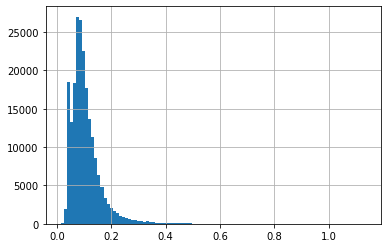

In [418]:
df_gb['prediction'].hist(bins=100)

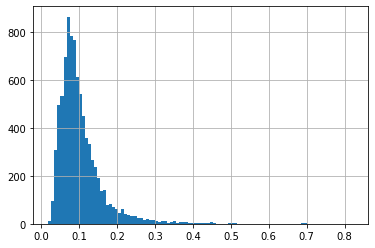

In [419]:
df_val['prediction'].hist(bins=100)

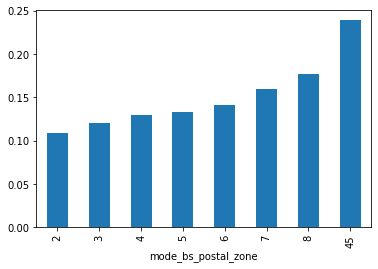

In [420]:
df_val.loc[df_val['primary_brand_category']=='Kitchen', :].groupby(
    'mode_bs_postal_zone'
)[target].mean().plot(kind='bar')

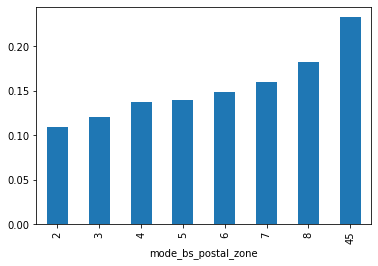

In [421]:
df_val.loc[df_val['primary_brand_category']=='Kitchen', :].groupby(
    'mode_bs_postal_zone'
)['prediction'].mean().plot(kind='bar')

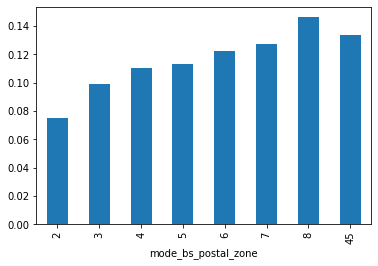

In [422]:
df_val_future.loc[df_val_future['primary_brand_category']=='Home Decor', :].groupby(
    'mode_bs_postal_zone'
)[target].mean().plot(kind='bar')

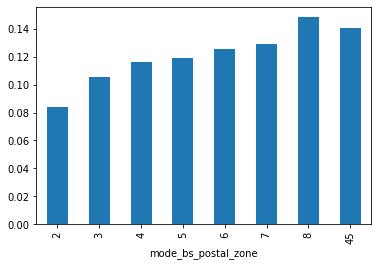

In [423]:
df_val_future.loc[df_val_future['primary_brand_category']=='Home Decor', :].groupby(
    'mode_bs_postal_zone'
)['prediction'].mean().plot(kind='bar')

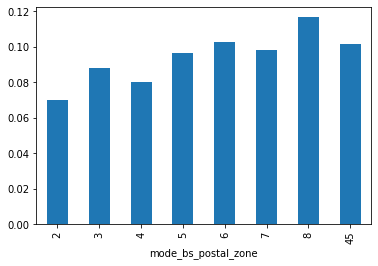

In [424]:
df_val.loc[df_val['primary_brand_category']=='Beauty', :].groupby(
    'mode_bs_postal_zone'
)[target].mean().plot(kind='bar')

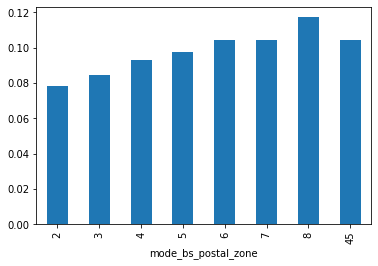

In [425]:
df_val.loc[df_val['primary_brand_category']=='Beauty', :].groupby(
    'mode_bs_postal_zone'
)['prediction'].mean().plot(kind='bar')

In [426]:
df_top_vetoes = df_gb.loc[(df_gb['first_order_commission']==0.25) 
                   & (df_gb['mode_bs_postal_zone'] < 6)
                   , :
                  ]

In [427]:
df_gb['mode_bs_postal_zone'].value_counts()

5     48038
8     44972
6     32789
4     30236
7     28483
3     11942
2      8997
45     3847
Name: mode_bs_postal_zone, dtype: int64

In [428]:
df_top_vetoes['historical_gmv_fraction'].sum()

0.30840368108361393

In [429]:
df.shape

(348633, 85)

In [430]:
df.head(10)

,brand_order_id,is_cured,is_rr_cured,brand_order_created_date,brand_id,primary_brand_category,brand_location,avg_weight_of_products,retailer_location,commission,...,retailer_location_South Atlantic,retailer_location_South East,retailer_location_South West,retailer_location_Unknown,retailer_address_type_RESIDENTIAL,retailer_address_type_COMMERCIAL,insider_subscriber_Insider,insider_subscriber_Non-Insider,first_order_commission,coalesced_shipping_cost_dollars
0,1207,1,1,2017-09-20 21:18:22,396,Home Decor,New England,1.939162,Pacific West,27.0,...,0,0,0,0,0,1,1,0,0.15,41.5300
1,712,1,1,2017-07-31 21:48:39,396,Home Decor,New England,1.939162,Pacific West,27.0,...,0,0,0,0,0,1,0,1,0.15,41.5300
2,664,1,1,2017-07-30 19:01:34,396,Home Decor,New England,1.939162,Pacific West,29.4,...,0,0,0,0,0,1,0,1,0.15,52.9800
3,182034,1,1,2019-01-10 23:18:27,396,Home Decor,New England,1.939162,Pacific West,40.5,...,0,0,0,0,0,1,1,0,0.15,49.9800
4,673,1,1,2017-07-30 22:59:55,396,Home Decor,New England,1.939162,Pacific West,24.2,...,0,0,0,0,0,1,0,1,0.15,55.3600
5,454,1,1,2017-06-12 18:59:24,396,Home Decor,New England,1.939162,Pacific West,31.2,...,0,0,0,0,1,0,0,1,0.15,30.0000
6,1971,1,1,2017-10-19 19:10:05,396,Home Decor,New England,1.939162,Unknown,32.6,...,0,0,0,1,0,1,0,1,0.15,49.3900
7,66539,1,1,2018-09-05 16:41:36,396,Home Decor,New England,1.939162,Pacific West,30.6,...,0,0,0,0,0,1,0,1,0.15,37.2600
8,154711,1,1,2018-12-07 01:44:04,396,Home Decor,New England,1.939162,Pacific West,51.6,...,0,0,0,0,0,1,1,0,0.15,59.1600
9,120519,1,1,2018-11-04 05:26:40,396,Home Decor,New England,1.939162,Pacific West,32.4,...,0,0,0,0,0,1,1,0,0.15,29.1200


## Plot number of brands in each state

#### Pick your top selection

In [431]:
# df_top_final = df_top
df_top_final = df_stratified_top
# df_top_final = df_top_vetoes

In [432]:
df_top_final.shape

(106708, 91)

In [433]:
df_top_final['historical_gmv_fraction'].sum()

0.5557223301777007

In [434]:
df_top_final.loc[df_top_final['mode_bs_postal_zone']<8, 'historical_gmv_fraction'].sum()

0.46701537626959594

In [435]:
df_top_final.loc[df_top_final['mode_bs_postal_zone']<7, 'historical_gmv_fraction'].sum()

0.4048972976569392

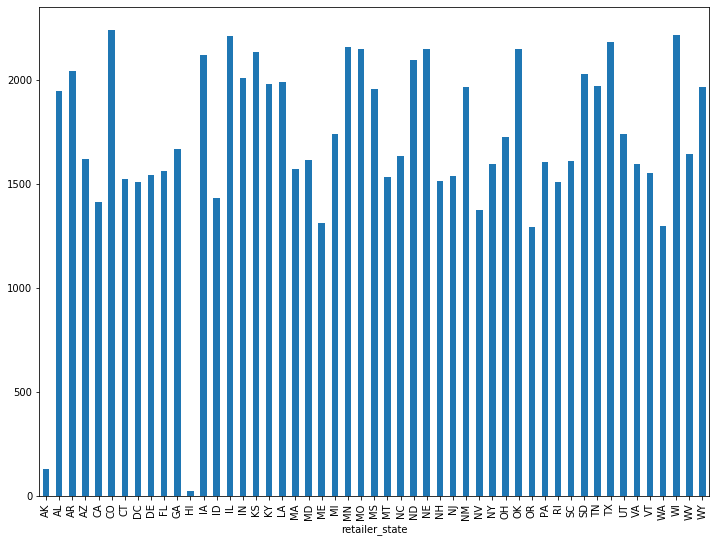

In [436]:
fig, ax = plt.subplots(figsize=(12,9));
df_top_final.loc[df_top_final['mode_bs_postal_zone']<8, :].groupby('retailer_state')['brand_id'].nunique().plot(kind='bar');

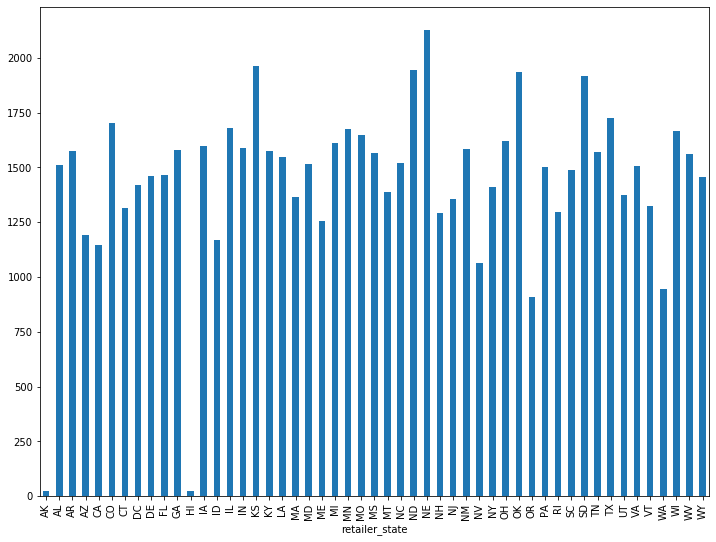

In [437]:
fig, ax = plt.subplots(figsize=(12,9));
df_top_final.loc[df_top_final['mode_bs_postal_zone']<7, :].groupby('retailer_state')['brand_id'].nunique().plot(kind='bar');

Now let's make some plots

In [438]:
df_top_final['mode_bs_postal_zone'].isna().sum()

0

In [439]:
df_top_final['mode_bs_postal_zone'].notna().sum()

106708

In [440]:
df_gb['mode_bs_postal_zone'].isna().sum()/df_gb.shape[0]

0.0

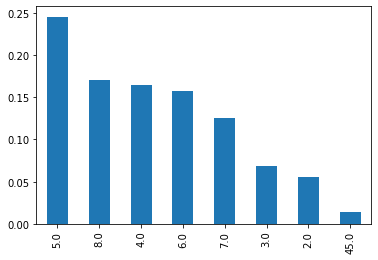

In [441]:
(df_top_final['mode_bs_postal_zone'].value_counts()/ df_top_final.shape[0]).plot(kind='bar')

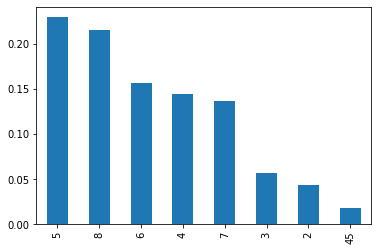

In [442]:
(df_gb['mode_bs_postal_zone'].value_counts()/ df_gb.shape[0]).plot(kind='bar')

In [443]:
df_gb.loc[df_gb['brand_id']==8718, 'retailer_state'].unique()

array(['MI', 'NV', 'IL', 'IN', 'OH', 'WI', 'NC', 'MA', 'NJ', 'NH', 'CO',
       'MN', 'PA', 'WY', 'CT', 'AL', 'ID', 'SC', 'OR', 'IA', 'NY', 'SD',
       'MD', 'KS', 'WV', 'NE', 'DE', 'UT', 'VT', 'TN', 'ME', 'AR', 'AK',
       'RI', 'OK', 'MO', 'TX', 'LA', 'MS', 'KY', 'ND', 'GA', 'CA', 'FL',
       'WA', 'NM', 'HI', 'VA', 'DC', 'AZ', 'MT'], dtype=object)

In [444]:
df_gb['historical_gmv_fraction'].sum()

0.9679615493139923

In [445]:
df_top_final['historical_gmv_fraction'].sum()

0.5557223301777007

In [446]:
df_top_final.head()

,index,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,...,postal_zone_5,postal_zone_6,postal_zone_7,postal_zone_8,postal_zone_45,past_target_shipping_cost_fraction,target_shipping_cost_fraction,prediction,blended_commission,simplified_commission
184801,184801.0,5954.0,VT,0.000256,0.0,0.522108,0.25,0.0,0.0,0.656250,...,0.0,0.0,0.0,0.0,0.0,0.007853,0.005869,0.018994,0.19,0.162261
17656,17656.0,5954.0,CT,0.000015,0.0,0.522108,0.25,0.0,0.0,0.656250,...,0.0,0.0,0.0,0.0,0.0,0.009316,0.000032,0.021369,0.19,0.159886
179736,179736.0,5954.0,NH,0.000019,0.0,0.522108,0.25,0.0,0.0,0.656250,...,0.0,0.0,0.0,0.0,0.0,0.012366,0.011225,0.022579,0.19,0.158676
30721,30721.0,32760.0,OH,0.000007,0.0,1.001305,0.25,0.0,0.0,0.989247,...,0.0,0.0,1.0,0.0,0.0,0.007319,0.018910,0.026301,0.19,0.154944
187736,187736.0,32760.0,MT,0.000008,0.0,1.001305,0.25,0.0,0.0,0.989247,...,0.0,0.0,0.0,0.0,0.0,0.008124,0.019365,0.026931,0.19,0.154314


In [447]:
df_top_final.loc[df_top_final['primary_brand_category']=='Accessories', 'brand_id'].nunique()

498

In [448]:
df_gb['brand_id'].nunique()

4104

#### Remove zone 45

In [449]:
df_top_final = df_top_final.loc[~(df_top_final['mode_bs_postal_zone']==45), :]

In [450]:
df_top_final[['brand_id', 'primary_brand_category']].drop_duplicates()['primary_brand_category'].value_counts()

Home Decor         540
Accessories        497
Beauty             467
Kitchen            467
Jewelry            366
Stationery         363
Kids               156
Women's Apparel    109
Men                 54
Pets                41
Other               36
Name: primary_brand_category, dtype: int64

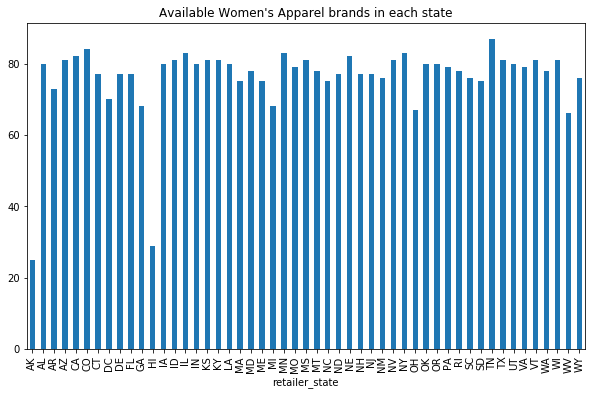

In [451]:
cat = 'Women\'s Apparel'
fig, ax = plt.subplots(figsize=(10,6));
df_top_final.loc[df_top_final['primary_brand_category']==cat, :].groupby('retailer_state')['brand_id'].nunique().plot(kind='bar')
plt.title('Available '+cat+' brands in each state');

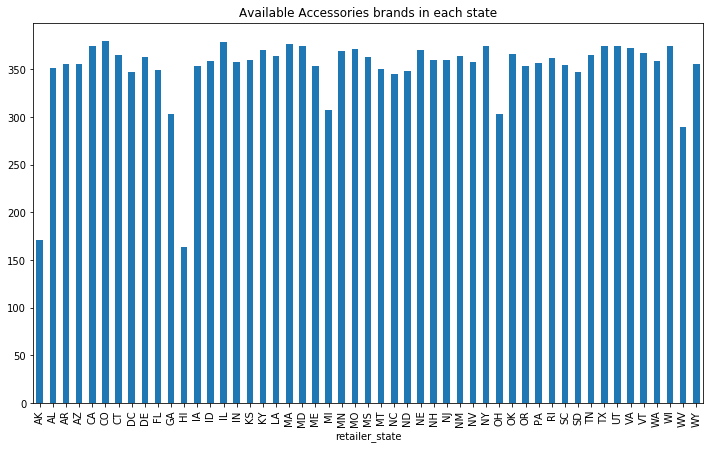

In [452]:
cat = 'Accessories'
fig, ax = plt.subplots(figsize=(12,7));
df_top_final.loc[df_top_final['primary_brand_category']==cat, :].groupby('retailer_state')['brand_id'].nunique().plot(kind='bar')
plt.title('Available '+cat+' brands in each state');

Text(0.5, 1.0, 'Available Kitchen brands in each state')

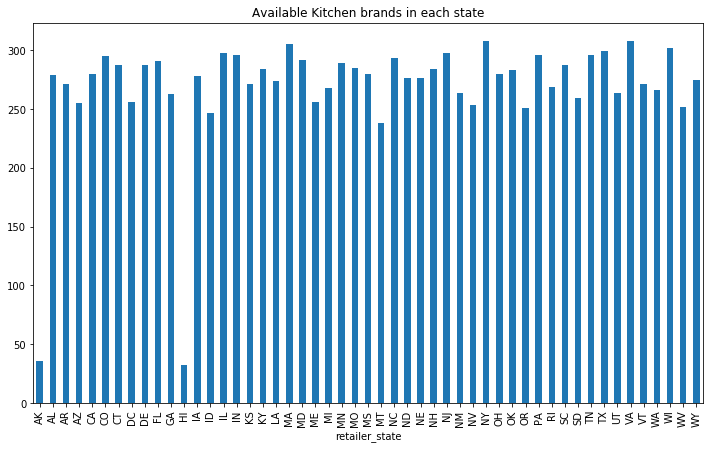

In [453]:
cat = 'Kitchen'
fig, ax = plt.subplots(figsize=(12,7));
df_top_final.loc[df_top_final['primary_brand_category']==cat, :].groupby('retailer_state')['brand_id'].nunique().plot(kind='bar')
plt.title('Available '+cat+' brands in each state')

In [454]:
df_top_final.loc[df_top_final['primary_brand_category']=='Kitchen',
                 :].groupby('retailer_state')['brand_id'].nunique().mean()

268.6862745098039

In [455]:
df_top_final.loc[df_top_final['primary_brand_category']=='Home Decor',
                 :].groupby('retailer_state')['brand_id'].nunique().mean()

344.4313725490196

Text(0.5, 1.0, 'Available Home Decor brands in each state')

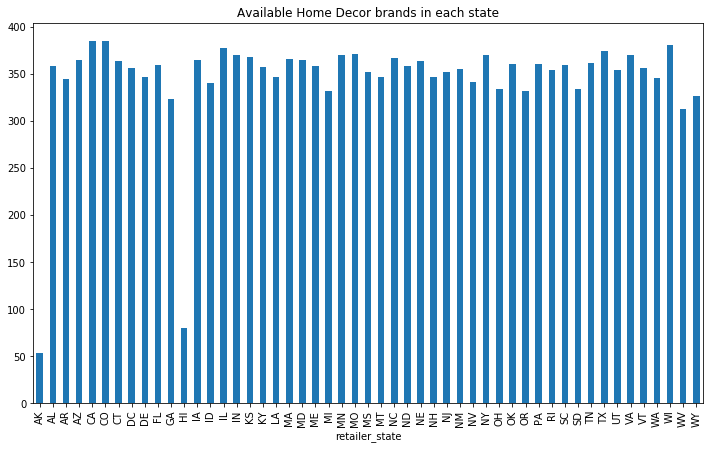

In [456]:
cat = 'Home Decor'
fig, ax = plt.subplots(figsize=(12,7));
df_top_final.loc[df_top_final['primary_brand_category']==cat, :].groupby('retailer_state')['brand_id'].nunique().plot(kind='bar')
plt.title('Available '+cat+' brands in each state')

In [457]:
df_top_final = df_top_final.loc[~df_top_final['retailer_state'].isin(['HI','AK']), :]

#### Remove zone 8 for Kitchen and Home Decor

In [458]:
df_top_final = df_top_final.loc[
    ~(
        (df_top_final['primary_brand_category']=='Home Decor')
        & (df_top_final['mode_bs_postal_zone']==8)
    )
    , :
]

In [459]:
df_top_final = df_top_final.loc[
    ~(
        (df_top_final['primary_brand_category']=='Kitchen')
        & (df_top_final['mode_bs_postal_zone']==8)
    )
    , :
]

#### Home Decor and Kitchen after removing zone 8

Text(0.5, 1.0, 'Available Kitchen brands in each state')

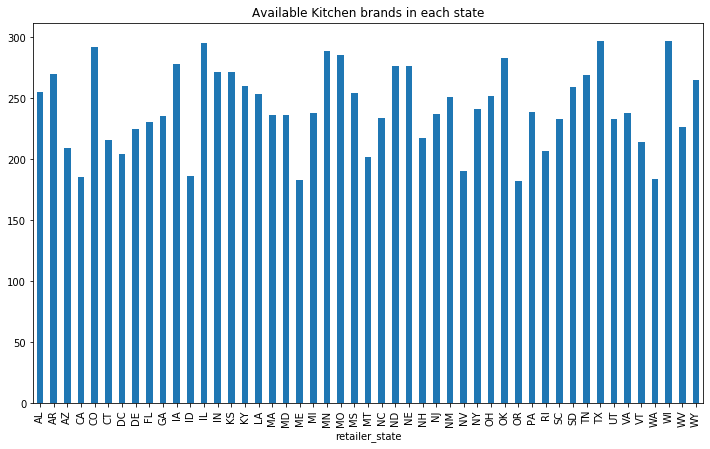

In [460]:
cat = 'Kitchen'
fig, ax = plt.subplots(figsize=(12,7));
df_top_final.loc[df_top_final['primary_brand_category']==cat, :].groupby('retailer_state')['brand_id'].nunique().plot(kind='bar')
plt.title('Available '+cat+' brands in each state')

Text(0.5, 1.0, 'Available Home Decor brands in each state')

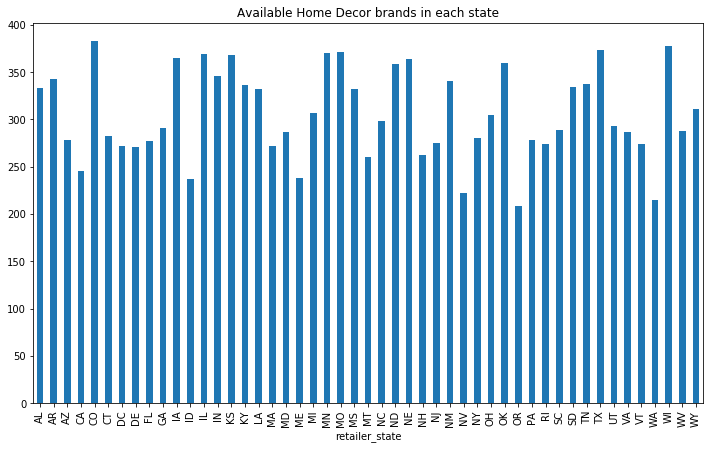

In [461]:
cat = 'Home Decor'
fig, ax = plt.subplots(figsize=(12,7));
df_top_final.loc[df_top_final['primary_brand_category']==cat, :].groupby('retailer_state')['brand_id'].nunique().plot(kind='bar')
plt.title('Available '+cat+' brands in each state')

In [462]:
df_top_final.loc[df_top_final['primary_brand_category']=='Kitchen',
                 :].groupby('retailer_state')['brand_id'].nunique().mean()

242.0

In [463]:
df_top_final.loc[df_top_final['primary_brand_category']=='Home Decor',
                 :].groupby('retailer_state')['brand_id'].nunique().mean()

305.42857142857144

Text(0.5, 1.0, 'Available Jewelry brands in each state')

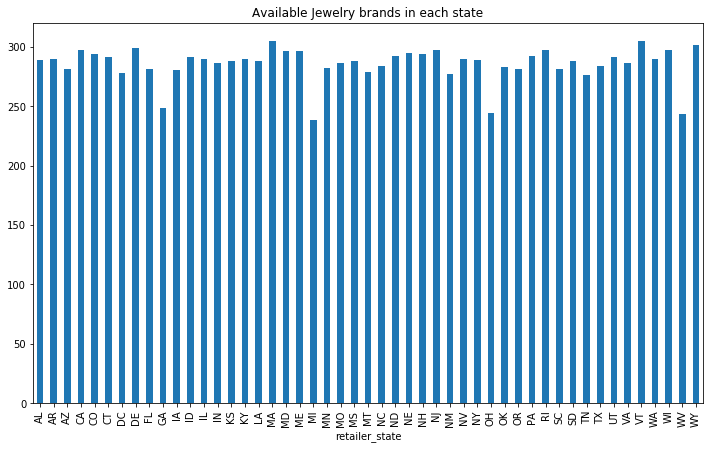

In [464]:
cat = 'Jewelry'
fig, ax = plt.subplots(figsize=(12,7));
df_top_final.loc[df_top_final['primary_brand_category']==cat, :].groupby('retailer_state')['brand_id'].nunique().plot(kind='bar')
plt.title('Available '+cat+' brands in each state')

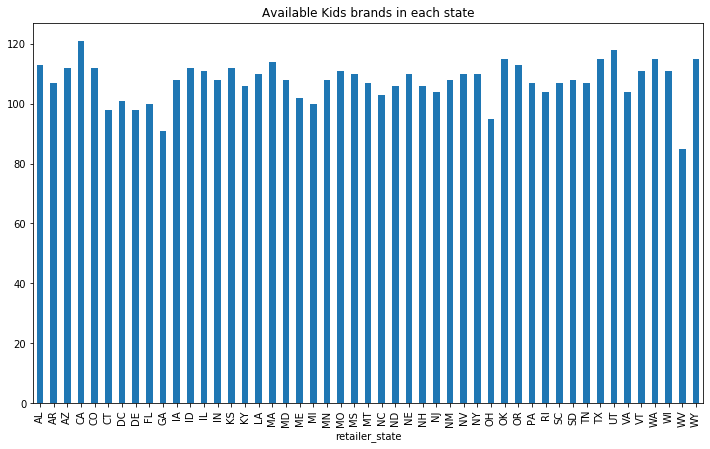

In [465]:
cat = 'Kids'
fig, ax = plt.subplots(figsize=(12,7));
df_top_final.loc[df_top_final['primary_brand_category']==cat, :].groupby('retailer_state')['brand_id'].nunique().plot(kind='bar')
plt.title('Available '+cat+' brands in each state');

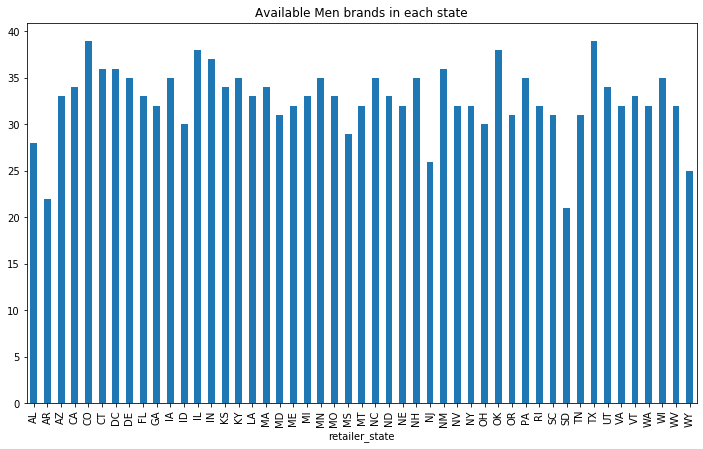

In [466]:
cat = 'Men'
fig, ax = plt.subplots(figsize=(12,7));
df_top_final.loc[df_top_final['primary_brand_category']==cat, :].groupby('retailer_state')['brand_id'].nunique().plot(kind='bar')
plt.title('Available '+cat+' brands in each state');

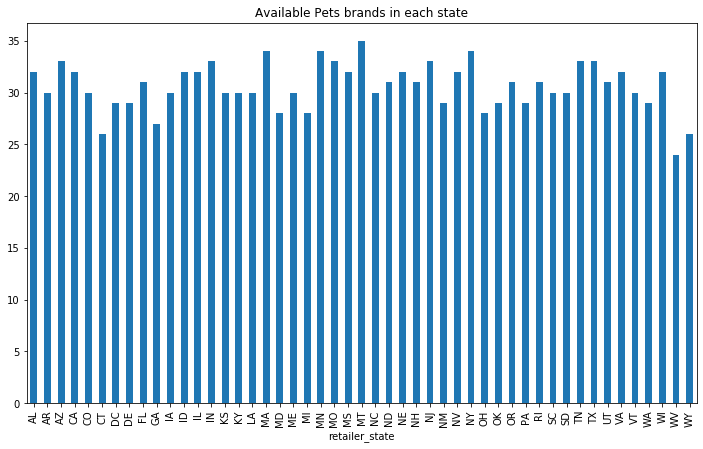

In [467]:
cat = 'Pets'
fig, ax = plt.subplots(figsize=(12,7));
df_top_final.loc[df_top_final['primary_brand_category']==cat, :].groupby('retailer_state')['brand_id'].nunique().plot(kind='bar')
plt.title('Available '+cat+' brands in each state');

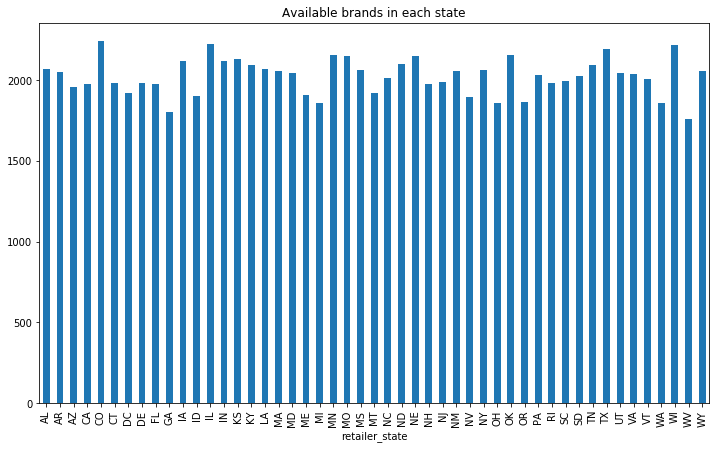

In [468]:
fig, ax = plt.subplots(figsize=(12,7));
df_top_final.groupby('retailer_state')['brand_id'].nunique().plot(kind='bar')
plt.title('Available brands in each state');

## Tests

Check the brands in CA are different than the ones in NY

In [469]:
df_top_final['historical_gmv_fraction'].sum()

0.5227422999404333

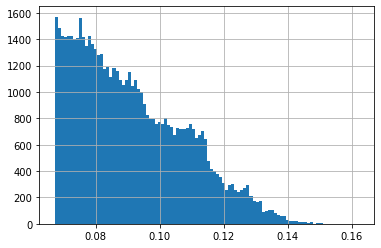

In [470]:
df_top['simplified_commission'].hist(bins=100)

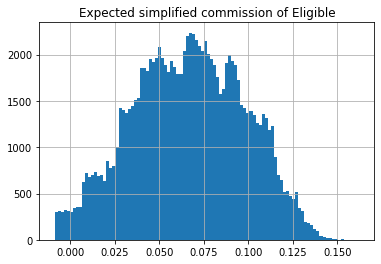

In [471]:
df_stratified_top['simplified_commission'].hist(bins=100);
plt.title('Expected simplified commission of Eligible');

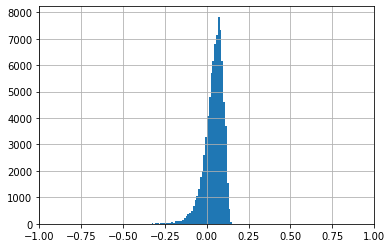

In [472]:
df_top_vetoes['simplified_commission'].hist(bins=100)
plt.xlim(-1.0, 1.0);

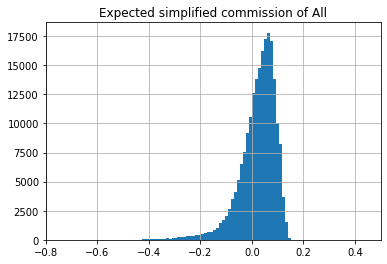

In [473]:
df_gb['simplified_commission'].hist(bins=100);
plt.xlim(-0.8, 0.5);
plt.title('Expected simplified commission of All');

#### Simplified commission

In [474]:
df_gb['simplified_commission'].mean()

0.021670875642625636

In [475]:
df_top['simplified_commission'].mean()

0.09100915793435624

In [476]:
df_stratified_top['simplified_commission'].mean()

0.06645626972312078

In [477]:
df_top_vetoes['simplified_commission'].mean()

0.040970457586558824

#### First order commission

In [478]:
df_gb[['brand_id','first_order_commission']].drop_duplicates().mean()

brand_id                  16623.405458
first_order_commission        0.234644
dtype: float64

In [479]:
df_top[['brand_id','first_order_commission']].drop_duplicates().mean()

brand_id                  17505.465966
first_order_commission        0.245537
dtype: float64

In [480]:
# df_stratified_top['first_order_commission'].mean()
df_stratified_top[['brand_id','first_order_commission']].drop_duplicates().mean()

brand_id                  17392.694642
first_order_commission        0.242261
dtype: float64

In [481]:
df_gb['first_order_commission'].mean()

0.23464424951267054

In [482]:
df_stratified_top['first_order_commission'].mean()

0.24552610863290478

#### Return Rates

In [483]:
df_gb[['brand_id','smoothed_return_rate']].drop_duplicates().mean()

brand_id                16623.405458
smoothed_return_rate        0.111481
dtype: float64

In [484]:
df_top[['brand_id','smoothed_return_rate']].drop_duplicates().mean()

brand_id                17505.465966
smoothed_return_rate        0.074290
dtype: float64

In [485]:
# df_stratified_top['first_order_commission'].mean()
df_stratified_top[['brand_id','smoothed_return_rate']].drop_duplicates().mean()

brand_id                17392.694642
smoothed_return_rate        0.089118
dtype: float64

In [486]:
df_gb['smoothed_return_rate'].mean()

0.11148112874069858

In [487]:
df_stratified_top['smoothed_return_rate'].mean()

0.07651101132076453

#### SwF Adoption

In [488]:
df_gb[['brand_id', 'brand_pct_swf']].drop_duplicates().mean()

brand_id         16623.405458
brand_pct_swf        0.431297
dtype: float64

In [489]:
df_top[['brand_id', 'brand_pct_swf']].drop_duplicates().mean()

brand_id         17505.465966
brand_pct_swf        0.512910
dtype: float64

In [490]:
df_stratified_top[['brand_id', 'brand_pct_swf']].drop_duplicates().mean()

brand_id         17392.694642
brand_pct_swf        0.481599
dtype: float64

In [491]:
df_gb[['brand_id', 'brand_pct_swf']].drop_duplicates().mean()

brand_id         16623.405458
brand_pct_swf        0.431297
dtype: float64

In [492]:
df_gb['brand_pct_swf'].mean()

0.43129701885750077

In [493]:
df_stratified_top['brand_pct_swf'].mean()

0.5450525213472718

#### Postal zones

In [494]:
df_gb['mode_bs_postal_zone'].mean()

6.421090853495394

In [495]:
df_stratified_top['mode_bs_postal_zone'].mean()

6.024421786557709

In [496]:
df_gb.loc[df_gb['primary_brand_category']=='Kitchen', 'mode_bs_postal_zone'].mean()

6.325432206154181

In [497]:
df_stratified_top.loc[df_stratified_top['primary_brand_category']=='Kitchen', 'mode_bs_postal_zone'].mean()

5.672851985559567

In [498]:
df_gb.loc[df_gb['primary_brand_category']=='Home Decor', 'mode_bs_postal_zone'].mean()

6.279404393336282

In [499]:
df_stratified_top.loc[df_stratified_top['primary_brand_category']=='Home Decor', 'mode_bs_postal_zone'].mean()

5.8189485521506885

In [500]:
df_gb.loc[df_gb['primary_brand_category']=='Jewelry', 'mode_bs_postal_zone'].mean()

6.3974799541809855

In [501]:
df_stratified_top.loc[df_stratified_top['primary_brand_category']=='Jewelry', 'mode_bs_postal_zone'].mean()

6.160699700517288

In [502]:
df_gb.loc[:, 'mode_bs_postal_zone'].value_counts() \
/ df_gb.shape[0]

5     0.229513
8     0.214865
6     0.156657
4     0.144460
7     0.136084
3     0.057056
2     0.042985
45    0.018380
Name: mode_bs_postal_zone, dtype: float64

In [503]:
df_stratified_top.loc[:, 'mode_bs_postal_zone'].value_counts() \
/df_stratified_top.shape[0]

5.0     0.245755
8.0     0.170222
4.0     0.164477
6.0     0.156970
7.0     0.125220
3.0     0.067961
2.0     0.055094
45.0    0.014301
Name: mode_bs_postal_zone, dtype: float64

In [504]:
df_gb.loc[df_gb['primary_brand_category']=='Kitchen', 'mode_bs_postal_zone'].value_counts() \
/ df_gb.loc[df_gb['primary_brand_category']=='Kitchen', :].shape[0]

5     0.229241
8     0.224385
6     0.147258
4     0.143924
7     0.134573
3     0.059041
2     0.045703
45    0.015875
Name: mode_bs_postal_zone, dtype: float64

In [505]:
df_stratified_top.loc[df_stratified_top['primary_brand_category']=='Kitchen',
                      'mode_bs_postal_zone'].value_counts() \
/df_stratified_top.loc[df_stratified_top['primary_brand_category']=='Kitchen', :].shape[0]

5.0     0.269025
4.0     0.182166
6.0     0.145560
8.0     0.131697
7.0     0.118845
3.0     0.078412
2.0     0.063682
45.0    0.010614
Name: mode_bs_postal_zone, dtype: float64

In [506]:
df_stratified_top.loc[(df_stratified_top['primary_brand_category']=='Kitchen')
                      & (df_stratified_top['mode_bs_postal_zone']==8),
                      'brand_pct_swf'
                     ].mean()

0.5889724414124929

In [507]:
df_stratified_top.loc[(df_stratified_top['primary_brand_category']=='Kitchen')
                      & (df_stratified_top['mode_bs_postal_zone']==8),
                      'smoothed_return_rate'
                     ].mean()

0.07290710760549941

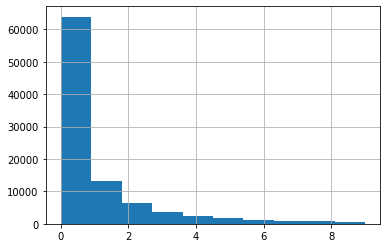

In [508]:
df_top_final.loc[df_top_final['num_brand_orders_to_state']<10, 'num_brand_orders_to_state'].hist(bins=10)

In [509]:
df_gb[target].mean()

0.09820310978322898

In [510]:
df_top[target].mean()

0.0551653845082387

In [511]:
df_stratified_top[target].mean()

0.07069166788451606

In [512]:
df_top_vetoes[target].mean()

0.08806001667630825

In [513]:
df_gb['brand_pct_swf'].mean()

0.43129701885750077

In [514]:
df_gb['brand_pct_fedex'].mean()

0.16430267369390814

In [515]:
df_top_final[['primary_brand_category','brand_id']].drop_duplicates().head(10)

,primary_brand_category,brand_id
184801,Jewelry,5954.0
30721,Jewelry,32760.0
137667,Jewelry,9581.0
37873,Jewelry,4912.0
5888,Jewelry,11773.0
1019,Jewelry,14134.0
89016,Jewelry,7113.0
1843,Jewelry,14359.0
154098,Jewelry,10094.0
143182,Jewelry,11747.0


In [516]:
df_top_final.head()

,index,brand_id,retailer_state,historical_gmv_fraction,brand_pct_swf,avg_weight_of_products,first_order_commission,brand_pct_fedex,brand_pct_ups,brand_pct_usps,...,postal_zone_5,postal_zone_6,postal_zone_7,postal_zone_8,postal_zone_45,past_target_shipping_cost_fraction,target_shipping_cost_fraction,prediction,blended_commission,simplified_commission
184801,184801.0,5954.0,VT,0.000256,0.0,0.522108,0.25,0.0,0.0,0.656250,...,0.0,0.0,0.0,0.0,0.0,0.007853,0.005869,0.018994,0.19,0.162261
17656,17656.0,5954.0,CT,0.000015,0.0,0.522108,0.25,0.0,0.0,0.656250,...,0.0,0.0,0.0,0.0,0.0,0.009316,0.000032,0.021369,0.19,0.159886
179736,179736.0,5954.0,NH,0.000019,0.0,0.522108,0.25,0.0,0.0,0.656250,...,0.0,0.0,0.0,0.0,0.0,0.012366,0.011225,0.022579,0.19,0.158676
30721,30721.0,32760.0,OH,0.000007,0.0,1.001305,0.25,0.0,0.0,0.989247,...,0.0,0.0,1.0,0.0,0.0,0.007319,0.018910,0.026301,0.19,0.154944
187736,187736.0,32760.0,MT,0.000008,0.0,1.001305,0.25,0.0,0.0,0.989247,...,0.0,0.0,0.0,0.0,0.0,0.008124,0.019365,0.026931,0.19,0.154314


In [517]:
df_top_final.loc[(df_top_final['brand_state']=='CA')
                & (df_top_final['primary_brand_category']=='Kitchen')
                , ['retailer_state', 'prediction']].groupby('retailer_state')['prediction'].mean().sort_values()

retailer_state
SC    0.087461
CA    0.087539
NJ    0.106220
TX    0.106561
AZ    0.106979
WA    0.109016
CO    0.110024
MA    0.111268
CT    0.111673
OR    0.112215
IL    0.112343
MN    0.112897
MT    0.113030
IA    0.113736
MO    0.115143
KS    0.115296
NY    0.115512
UT    0.115758
NV    0.116316
NM    0.116449
PA    0.116901
MD    0.117175
WI    0.117271
OK    0.117546
WY    0.117582
NE    0.117584
AR    0.117958
ID    0.118339
MS    0.118857
AL    0.119097
ND    0.120019
KY    0.121280
SD    0.121330
LA    0.121513
MI    0.122063
FL    0.122423
TN    0.122556
IN    0.122891
OH    0.128249
ME    0.166115
Name: prediction, dtype: float32

In [518]:
df_top_final.loc[(df_top_final['brand_state']=='NY')
                & (df_top_final['primary_brand_category']=='Kitchen')
                , ['retailer_state', 'prediction']].groupby('retailer_state')['prediction'].mean().sort_values()

retailer_state
UT    0.077372
WA    0.082945
CA    0.093370
NY    0.098885
PA    0.106937
OH    0.107631
MA    0.108394
MD    0.108562
DC    0.111073
NJ    0.111331
WI    0.112675
ME    0.112966
MI    0.113420
NC    0.113972
IL    0.114300
NH    0.114800
VA    0.114988
VT    0.115860
CO    0.116375
IN    0.118213
TN    0.118592
AR    0.119265
WV    0.119404
TX    0.119897
MN    0.120120
SC    0.120163
CT    0.120184
LA    0.120226
GA    0.120362
KY    0.120702
FL    0.121208
AL    0.122139
RI    0.122378
SD    0.123646
MO    0.124865
OK    0.125197
NE    0.125755
ND    0.126505
MS    0.126755
KS    0.128499
IA    0.128702
DE    0.129027
WY    0.131717
NM    0.132854
Name: prediction, dtype: float32

In [519]:
df_gb['brand_pct_swf'].mean()

0.43129701885750077

In [520]:
df_gb['prediction'].mean()

0.105107956

In [521]:
df_top['prediction'].mean()

0.06483146

In [522]:
df_stratified_top['prediction'].mean()

0.08357588

In [523]:
df_top_vetoes['prediction'].mean()

0.09557871

In [524]:
cat = 'Kitchen'

brands_CA = df_top_final.loc[(df_top_final['primary_brand_category']==cat)
                       & (df_top_final['retailer_state']=='CA')
                       , 'brand_id'].unique()
brands_NY = df_top_final.loc[(df_top_final['primary_brand_category']==cat)
                       & (df_top_final['retailer_state']=='NY')
                       , 'brand_id'].unique()

In [525]:
brands_CA.shape

(185,)

In [526]:
brands_NY.shape

(241,)

In [527]:
brands_CA[:5]

array([14260., 23678., 26602., 36513., 59708.])

In [528]:
brands_NY[:5]

array([ 9327., 32067., 34029., 28212.,  5338.])

In [529]:
pd.Series(brands_CA).append(pd.Series(brands_NY)).nunique()

371

## Add new or uncured brands

In [556]:
query_brands_low_zones = \
'''
WITH new_arrivals AS (
  SELECT 
      bls.brand_id
    , b.based_in_state as brand_state
  
  FROM etl.core_brand_lifetime_summary bls
  JOIN production.brands b
    ON b.id = bls.brand_id
  WHERE bls.brand_first_first_active_at > getdate() - interval '22 days'
)

, uncured_brands AS (
  SELECT 
        bos.brand_id
      , b.based_in_state as brand_state
      , COUNT(DISTINCT CASE WHEN bos.brand_order_created_date < getdate() - interval '70 days' THEN bos.brand_order_id END) 
        as num_cured_brand_orders
  
  FROM production.brands b
  LEFT JOIN etl.brand_order_summary bos
    ON bos.brand_id = b.id
  WHERE b.active=true
  
  GROUP BY 1, 2
  HAVING num_cured_brand_orders < 4
)

SELECT *
FROM new_arrivals
WHERE brand_state is not null
UNION

SELECT brand_id, brand_state
FROM uncured_brands
WHERE brand_state is not null
  AND brand_id is not null
'''

In [557]:
df_brands_low_zones = query_to_df(query_brands_low_zones)

INFO:sqlalchemy.engine.base.Engine:select version()
INFO:sqlalchemy.engine.base.Engine:{}
INFO:sqlalchemy.engine.base.Engine:select current_schema()
INFO:sqlalchemy.engine.base.Engine:{}
INFO:sqlalchemy.engine.base.Engine:SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
INFO:sqlalchemy.engine.base.Engine:{}
INFO:sqlalchemy.engine.base.Engine:SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
INFO:sqlalchemy.engine.base.Engine:{}
INFO:sqlalchemy.engine.base.Engine:/* INTERMIX_ID: eyJmb3JtYXQiOiAiaW50ZXJtaXgiLCAidmVyc2lvbiI6ICIxIiwgInBsdWdpbiI6ICJpbnRlcm1peC1weXRob24tcGx1Z2luIiwgInBsdWdpbl92ZXIiOiAiMC43IiwgImFwcCI6ICJkYXRhc2NpZW5jZS1kZWZhdWx0IiwgInVzZXIiOiAiIiwgImFwcF92ZXIiOiAiSEVBRCIsICJkYWciOiAiZGVmYXVsdCIsICJ0YXNrIjogImRlZmF1bHQiLCAiYXQiOiAiMjAxOS0xMS0zMFQyMDo0OTowMS4wOTY1OTFaIiwgImZpbGUiOiAiL1VzZXJzL3BlZHJvc2FsZXNkZWJydWluL0RldmVsb3BtZW50L2RhdGFzY2llbmNlL2RhdGFzY2llbmNlL3NyYy9weXRob24vZmFpcmUvZGF0YXNjaWVuY2UvdmVuZG9yL2F3cy9yZWRzaGlmdC9fZXhlY19zcWwucHkiLCAibW9kdWxl

In [558]:
df_brands_low_zones['brand_id'].nunique()

2279

In [534]:
df_brands_low_zones = df_brands_low_zones.loc[~df_brands_low_zones['brand_id'].isin(df_gb['brand_id']), :]

In [535]:
a = df_brands_low_zones['brand_id'].unique().tolist()
b = df_state_locations['retailer_state'].unique().tolist()

index = pd.MultiIndex.from_product([a, b], names = ["brand_id", "retailer_state"])

In [536]:
df_temp = pd.DataFrame(index = index).reset_index();

df_brands_low_zones = df_brands_low_zones.merge(df_temp, on='brand_id')

In [537]:
df_brands_low_zones.head()

,brand_id,brand_state,retailer_state
0,9946,FL,CA
1,9946,FL,UT
2,9946,FL,WA
3,9946,FL,CT
4,9946,FL,WY


In [538]:
us_states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

In [539]:
df_brands_low_zones = df_brands_low_zones.loc[(df_brands_low_zones['brand_state'].isin(us_states))
                                              & (df_brands_low_zones['retailer_state'].isin(us_states))
                                              ,:]

In [540]:
df_brands_low_zones = add_to_df_gb(df_brands_low_zones, df, 'postal_zone'
                                   , gb_cols = ['brand_state', 'retailer_state']
                                   , aggtypes=['mode']
                                   , prefix='bsrs')

In [541]:
df_brands_low_zones.head(20)

,brand_id,brand_state,retailer_state,mode_bsrs_postal_zone
0,9946,FL,CA,8.0
1,9946,FL,UT,8.0
2,9946,FL,WA,8.0
3,9946,FL,CT,6.0
4,9946,FL,WY,7.0
5,9946,FL,NY,6.0
6,9946,FL,OH,5.0
7,9946,FL,GA,4.0
8,9946,FL,AL,4.0
9,9946,FL,OR,8.0


In [542]:
df_brands_low_zones = df_brands_low_zones.loc[df_brands_low_zones['mode_bsrs_postal_zone']<=4, :]

In [543]:
df_brands_low_zones.shape

(25174, 4)

In [544]:
df_brands_low_zones.head(10)

,brand_id,brand_state,retailer_state,mode_bsrs_postal_zone
7,9946,FL,GA,4.0
8,9946,FL,AL,4.0
10,9946,FL,FL,2.0
21,9946,FL,SC,4.0
28,9946,FL,NC,4.0
43,9946,FL,MS,4.0
52,83475,MT,UT,4.0
53,83475,MT,WA,4.0
55,83475,MT,WY,4.0
60,83475,MT,OR,4.0


In [545]:
# df_top_final.groupby('mode_bsrs_postal_zone')['prediction'].mean()

## Write to file

In [546]:
from datetime import datetime as dt

In [547]:
df_to_write = df_top_final[['brand_id', 'retailer_state']].reset_index(drop=True).sort_values(by='brand_id')

### Append new brands in low zones to original final file

In [548]:
df_to_write = pd.concat([df_to_write, df_brands_low_zones[df_to_write.columns.tolist()]], axis=0)

In [549]:
df_brands_low_zones['brand_id'].nunique()

2119

In [550]:
df_top_final['brand_id'].nunique()

3092

In [551]:
df_to_write['brand_id'].nunique()

5211

In [552]:
df_brands_low_zones.groupby('retailer_state')['brand_id'].nunique().mean()

503.48

In [553]:
df_top_final.groupby('retailer_state')['brand_id'].nunique().mean()

2023.4489795918366

In [554]:
df_to_write.groupby('retailer_state')['brand_id'].nunique().mean()

2486.46

In [555]:
# asdasad

In [559]:
dt.today().strftime('%Y-%m-%d')

'2019-11-30'

In [560]:
df_to_write.loc[:, 'inserted_at'] = dt.today().strftime('%Y-%m-%d')

In [561]:
out_path = '/Users/pedrosalesdebruin/Development/data/'

In [582]:
filename = 'insider_v2_B.tsv'

In [583]:
df_brands_low_zones['brand_id'].isna().sum()

0

In [584]:
df_top_final['brand_id'].isna().sum()

0

In [585]:
df_to_write['brand_id'].isna().sum()

0

In [586]:
df_to_write['brand_id'] = df_to_write['brand_id'].astype(int)

In [587]:
df_to_write.to_csv(out_path+filename, sep='\t', index=False)

In [588]:
df_to_write.head()

,brand_id,retailer_state,inserted_at
29424,3,FL,2019-11-30
33651,3,MA,2019-11-30
32061,3,NJ,2019-11-30
36559,3,IA,2019-11-30
34836,3,LA,2019-11-30


In [589]:
from faire.datascience.vendor.aws import s3, redshift

In [590]:
s3.write_output_to_s3(
        '/Users/pedrosalesdebruin/Development/data/'+filename,
        filename,
        "faire.ranking",
    )

INFO:faire.datascience.vendor.aws.s3._s3:Saving filename: /Users/pedrosalesdebruin/Development/data/insider_v2_B.tsv to s3 to bucket_name: faire.ranking key: insider_v2_B.tsv


In [591]:
df_top_final['brand_id'].nunique()

3092

In [581]:
df_to_write['brand_id'].nunique()

5211

In [ ]:
df_to_write['retailer_state'].nunique()

In [ ]:
df_brands_low_zones.head(50)

## End

In [ ]:
asdasdasd

## Checking only brands with several brand orders

In [ ]:
df_val = pd.concat([df_test, y_test], axis=1)

In [ ]:
df_val.head()

In [ ]:
df_val = pd.concat([df_val.reset_index(), pd.Series(y_test_pred)], axis=1)

In [ ]:
df_val.columns = df_val.columns.tolist()[:-1] + ['prediction']

In [ ]:
df_val.head()

In [ ]:
df_temp = df_val.loc[df_val['macro_avg_shipping_cost_fraction']>0, :]

((df_temp.loc[df_temp['macro_avg_shipping_cost_fraction'] > 0, 'prediction'] \
  - df_temp.loc[df_temp['macro_avg_shipping_cost_fraction'] > 0, 'macro_avg_shipping_cost_fraction']) \
   / df_temp.loc[df_temp['macro_avg_shipping_cost_fraction'] > 0, 'macro_avg_shipping_cost_fraction']
).hist(bins=25000)

plt.xlim(-3, 3);

In [ ]:
df_temp = df_val.loc[(df_val['macro_avg_shipping_cost_fraction']>0)
                     & (df_val['num_brand_orders_to_state']>10)
                     ,
                     :]

((df_temp.loc[df_temp['macro_avg_shipping_cost_fraction'] > 0, 'prediction'] \
  - df_temp.loc[df_temp['macro_avg_shipping_cost_fraction'] > 0, 'macro_avg_shipping_cost_fraction']) \
   / df_temp.loc[df_temp['macro_avg_shipping_cost_fraction'] > 0, 'macro_avg_shipping_cost_fraction']
).hist(bins=100)

plt.xlim(-3, 3);

In [ ]:
df_temp = df_val.loc[(df_val['macro_avg_shipping_cost_fraction']>0)
                     & (df_val['num_brand_orders_to_state']>15)
                     ,
                     :]

((df_temp.loc[df_temp['macro_avg_shipping_cost_fraction'] > 0, 'prediction'] \
  - df_temp.loc[df_temp['macro_avg_shipping_cost_fraction'] > 0, 'macro_avg_shipping_cost_fraction']) \
   / df_temp.loc[df_temp['macro_avg_shipping_cost_fraction'] > 0, 'macro_avg_shipping_cost_fraction']
).hist(bins=100)

plt.xlim(-3, 3);

## Plot predicted shipping costs given brand state

In [ ]:
b_state = 'CA'
b_cat = 'Accessories'

plt.figure(figsize=(12, 8));
df_val.loc[(df_gb['brand_state']==b_state)
           & (df_gb['primary_brand_category']==b_cat)
           , :].groupby('retailer_state')['prediction'].mean(
).sort_values().plot(kind='bar');

plt.title('Brands from '+b_state, fontsize=18);

In [ ]:
b_state = 'NY'
b_cat = 'Accessories'

plt.figure(figsize=(12, 8));
df_val.loc[(df_gb['brand_state']==b_state)
           & (df_gb['primary_brand_category']==b_cat)
           , :].groupby('retailer_state')['macro_avg_shipping_cost_fraction'].mean(
).sort_values().plot(kind='bar');

plt.title('Brands from '+b_state, fontsize=18);

## Regress on mean brand-state-CM

### Random Forest Regressor

### Reading Insider file

In [ ]:
final_df = pd.read_csv('/Users/pedrosalesdebruin/Downloads/insider_v2_A_latest.tsv', sep='\t')

In [ ]:
final_df.head()

In [ ]:
df_brands_low_zones.head()

In [ ]:
df_brands_low_zones['brand_id'].isin(final_df['brand_id']).sum()

In [ ]:
df_brands_low_zones.loc[df_brands_low_zones['mode_bsrs_postal_zone']>3, :]

#### because I'm paranoid

In [ ]:
for b in df_brands_low_zones['brand_id'].unique().tolist():
    if b in final_df['brand_id'].unique().tolist():
        print('Repeated brand!')

In [ ]:
df_brands_low_zones.reset_index(drop=True, inplace=True)

In [ ]:
final_df = pd.concat([final_df, df_brands_low_zones[['brand_id', 'retailer_state']]], axis=0)

In [ ]:
final_df.isna().sum()

In [ ]:
final_df.loc[:, 'inserted_at'] = dt.today().strftime('%Y-%m-%d')

In [ ]:
final_df.isna().sum()

In [ ]:
filename = 'insider_v2_A.tsv'

In [ ]:
final_df.head()

In [ ]:
final_df = final_df[['brand_id', 'retailer_state', 'inserted_at']]

In [ ]:
final_df.head()

In [ ]:
final_df.to_csv(out_path+filename, sep='\t', index=False)

In [ ]:
print(out_path)

In [ ]:
# s3.write_output_to_s3(
#         out_path+filename,
#         filename,
#         "faire.ranking",
#     )

In [ ]:
final_df.head()

In [ ]:
final_df = pd.concat([final_df.reset_index(), pd.Series(y_test_pred)], axis=1)

In [ ]:
final_df.columns = final_df.columns.tolist()[:-1] + ['prediction']

In [ ]:
final_df.groupby('primary_brand_category')['prediction'].mean()

In [ ]:
final_df.groupby('mode_bs_postal_zone')['prediction'].mean()